In [1]:
import os 

# os.environ["TORCH_HOME"]="/home/jovyan/shares/SR006.nfs2/.cache"
# os.environ["HF_HOME"]="/home/jovyan/shares/SR006.nfs2/.cache"
# os.environ["HUGGINGFACE_HUB_CACHE"]="/home/jovyan/shares/SR006.nfs2/.cache"
# os.environ["HF_DATASETS_CACHE"]="/home/jovyan/shares/SR006.nfs2/.cache"

import datasets
import json
import numpy as np
import pandas as pd
import torch
from collections import defaultdict

from sklearn.metrics import roc_auc_score
from lm_polygraph.utils.manager import UEManager, _delete_nans, _recombine_data
from lm_polygraph.ue_metrics.ue_metric import get_random_scores
from lm_polygraph.ue_metrics.risk_cov_curve import RiskCoverageCurveAUC
from lm_polygraph.ue_metrics.pred_rej_area import PredictionRejectionArea
from transformers import AutoTokenizer
# path = "./workdir/output/qa/bigscience/bloomz-560m/['LM-polygraph/coqa', 'continuation']/2024-11-28/13-55-31/ue_manager_seed1"
prr = PredictionRejectionArea()

/home/jovyan/.mlspace/envs/tmd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
import numpy as np


x = [np.random.randn(5, 32), np.random.randn(10, 32), np.random.randn(7, 64)]

y = [item for sublist in x for item in sublist]

len(y), y[0].shape

(22, (32,))

In [11]:
import os, psutil; print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3)

0.7915802001953125


In [15]:
psutil.Process(os.getpid()).memory_info().rss

849952768

In [19]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

IndexError: list index out of range

In [2]:
import os 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "meta-llama/Llama-3.2-1B"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
text = """How old is Donald Trump?"""
model_inputs = tokenizer(text, return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    output_scores=True,
    return_dict_in_generate=True,
    max_new_tokens=5,
    min_new_tokens=1,
    do_sample=False,
    num_beams=1,
    num_return_sequences=1,
    output_hidden_states=True,
    output_attentions=True
)
out = model(generated_ids.sequences, output_hidden_states=True)

/home/jovyan/.mlspace/envs/tmd/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/jovyan/.mlspace/envs/tmd/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [31]:
tokens_hs = torch.cat(
                        [
                            generated_ids.hidden_states[-2][layer][:, -1, :]
                            for layer in range(len(generated_ids.hidden_states[0]))
                        ]
                    )

In [32]:
def process_word_id_topk_rank_data(word_id_topk_rank, model_emb, device):
        layer_distance = torch.zeros((1, word_id_topk_rank.shape[-1])).to(device)
        for layer in range(word_id_topk_rank.shape[0] - 1):
            words0 = word_id_topk_rank[layer, :]
            words1 = word_id_topk_rank[layer + 1, :]
            if isinstance(words0, torch.Tensor):
                words0 = words0.clone().detach().unsqueeze(0).to(device)
            else:
                words0 = torch.tensor(words0).unsqueeze(0).to(device)

            if isinstance(words1, torch.Tensor):
                words1 = words1.clone().detach().unsqueeze(0).to(device)
            else:
                words1 = torch.tensor(words1).unsqueeze(0).to(device)

            emb0 = model_emb(words0)
            emb1 = model_emb(words1)

            distances = torch.cosine_similarity(emb0, emb1, dim=2).to(device)
            layer_distance = torch.cat((layer_distance, distances), dim=0)
        return layer_distance

In [33]:
topk = 10
layerwise_preds = model.lm_head(tokens_hs.to(model.device))
logits = torch.softmax(layerwise_preds, dim=-1)
sorted, indices = torch.sort(logits)
location = indices[:, -topk :]
prob = sorted[:, -topk :]
predicted_token = indices[-1][-1].item()
layer_distance = (
    process_word_id_topk_rank_data(
        location, model.model.embed_tokens, model.device
    )
    .cpu()
    .detach()
    .numpy()
)

In [34]:
predicted_token, generated_ids.sequences

(389,
 tensor([[128000,   4438,   2362,    374,   9641,   3420,     30,   1283,    574,
            9405,    389,    220]], device='cuda:0'))

In [44]:
# indices[-1]

np.argwhere(indices[-7].cpu().detach().numpy()[::-1] == predicted_token)[0, 0] + 1

20931

In [36]:
ranks_t = []
for layer in range(len(generated_ids.hidden_states[0])):
                        ranks_t.append(
                            np.argwhere(
                                indices[layer].cpu().detach().numpy()[::-1]
                                == predicted_token
                            )[0, 0]
                            + 1
                        )

In [37]:
import matplotlib.pyplot as plt

plt.plot(ranks_t)

In [6]:
len(generated_ids.attentions)

5

In [10]:
len(generated_ids.attentions[0])

16

In [13]:
generated_ids.attentions[0][0].shape, generated_ids.attentions[-1][0].shape

(torch.Size([1, 32, 7, 7]), torch.Size([1, 32, 1, 11]))

In [16]:
prompt_len = model_inputs.input_ids.shape[-1]

In [67]:
generated_ids.hidden_states[-1][:, -2]

TypeError: tuple indices must be integers or slices, not tuple

In [68]:
out.hidden_states[-1][:, -3]

tensor([[ 0.1533,  4.6250,  3.9375,  ..., -6.7188, -2.8750,  0.9336]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

In [69]:
torch.cat(generated_ids.hidden_states)

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [70]:
len(generated_ids.hidden_states), len(generated_ids.hidden_states[0])

(5, 17)

In [71]:
x = torch.cat(model(generated_ids.sequences, output_hidden_states=True).hidden_states)

In [72]:
x.shape

torch.Size([17, 24, 2048])

In [226]:
generated_ids.hidden_states[0][0].shape

torch.Size([1, 6, 2048])

In [73]:
model(generated_ids.sequences, output_hidden_states=True).hidden_states[0].shape

torch.Size([1, 24, 2048])

In [76]:
import os, psutil; print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3)

1.8954010009765625


In [46]:
generated_ids.scores[1][generated_ids.scores[1]!=-torch.inf]#.max()

tensor([36.4583, 36.8750, 35.4167, 37.5000], device='cuda:0')

In [187]:
tokenizer.name_or_path

'Qwen/Qwen2.5-7B'

In [27]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b").to("cuda:1")

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


In [200]:
name_or_path = "Qwen/.5-7B-Instruct"

("Qwen2.5" in name_or_path) and ("Instruct" not in name_or_path)

False

In [30]:
input_text = man['stats']["input_texts"][2]
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda:1")

outputs = model.generate(**input_ids, 
                         output_scores=True,
            return_dict_in_generate=True,
            output_hidden_states=True,
            output_attentions=True,
            max_new_tokens=256,
            min_new_tokens=2,
            do_sample=True,
            num_beams=1,
            num_return_sequences=1,)
print(tokenizer.decode(outputs.sequences[0]))

GemmaModel is using GemmaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<bos>The following are context and question about them. Each context is followed by a question and answer to a given question.

Context: A frameshift mutation is a deletion or insertion of one or more nucleotides that changes the reading frame of the base sequence. Deletions remove nucleotides, and insertions add nucleotides. Consider the following sequence of bases in RNA:.

Question: A frameshift mutation is a deletion or insertion of one or more of what that changes the reading frame of the base sequence?
Answer: insertion

Question: which of the following statements concerning a frameshift mutation are FALSE?
I. It alters the reading frame of the codons.
II. It may be a dominant or recessive mutation.
III. If the mutation affects a coding region, it may cause a harmful phenotype.
Answer: I, II and III

Question: In which of the following sets of genes are a frameshift mutation and a nonsense mutation mutually exclusive?
Choose all that apply
Answer: A and B; C and D

Question: In w

In [3]:
from lm_polygraph.ue_metrics import PredictionRejectionArea, KendallTauCorrelation, SpearmanRankCorrelation

/home/jovyan/.mlspace/envs/tmd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
import numpy as np

from lm_polygraph.ue_metrics.ue_metric import (
    UEMetric,
    normalize_metric,
)

def get_random_scores(function, metrics, num_iter=10, seed=42):
    np.random.seed(seed)
    rand_scores = np.arange(len(metrics))

    value = []
    for i in range(num_iter):
        np.random.shuffle(rand_scores)
        rand_val = function(rand_scores, metrics)
        value.append(rand_val)
    return np.mean(value)

def _delete_nans(ue, metric):
    new_ue, new_metric = [], []
    for i in range(len(metric)):
        if not np.isnan(metric[i]) and not np.isnan(ue[i]):
            if not isinstance(ue[i], complex):
                new_ue.append(ue[i])
            else:
                new_ue.append(ue[i].real)
            new_metric.append(metric[i])

    return np.array(new_ue), np.array(new_metric)
    
generation_metric = np.random.randn(2000)
estimator_values = np.random.randn(2000)
ue_metric = PredictionRejectionArea()

In [41]:
%%time

# ue, metric = _delete_nans(estimator_values, generation_metric)
oracle_score = ue_metric(-metric, metric)
random_score = get_random_scores(ue_metric, metric)
# ue_metric_val = ue_metric(ue, metric)
# normalize_metric(ue_metric_val, oracle_score, random_score)

CPU times: user 0 ns, sys: 3.02 ms, total: 3.02 ms
Wall time: 2.46 ms


In [23]:
%%timeit
_ = get_random_scores(prr, metrics)

103 ms ± 630 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [253]:
man['stats']["greedy_texts"][2]

' nucleotides\n\n'

In [255]:
class OutputWrapper:
    hidden_states = None
    encoder_hidden_states = None
    decoder_hidden_states = None

In [256]:
np.mean(man['time_stats']["token_embeddings_decoder_0"])

0.06112493276596069

In [257]:
dependencies = {}
dependencies["embeddings_all_decoder"] = outputs.hidden_states

In [259]:
%%time

batch: Dict[str, torch.Tensor] = tokenizer(input_text, return_tensors="pt")
batch = {k: v.to(model.device) for k, v in batch.items()}
with torch.no_grad():
    out = OutputWrapper()
    out.hidden_states = dependencies["embeddings_all_decoder"]
    for i in range(16):
        embeddings_encoder, embeddings_decoder = get_embeddings_from_output(
            out,
            batch,
            "CausalLM",
            level="sequence",
            hidden_layer=i,
        )
        token_embeddings_encoder, token_embeddings_decoder = (
            get_embeddings_from_output(
                out,
                batch,
                "CausalLM",
                level="token",
                hidden_layer=i,
            )
        )
        if token_embeddings_decoder is None:
            token_embeddings_decoder = torch.empty(
                (0, embeddings_decoder.shape[-1]), dtype=torch.float32
            )
        elif len(token_embeddings_decoder.shape) == 3:
            token_embeddings_decoder = token_embeddings_decoder.reshape(
                -1, token_embeddings_decoder.shape[-1]
            )
    
        res = {
                f"embeddings_decoder": embeddings_decoder.cpu()
                .detach()
                .numpy(),
                f"token_embeddings_decoder": token_embeddings_decoder.cpu()
                .detach()
                .numpy(),
            }

CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 15.1 ms


In [264]:
embeddings_decoder - embeddings_decoder.to(torch.float16)

tensor([[-1.2404e-04, -1.5371e-05,  9.4175e-05,  ..., -6.6131e-05,
          1.3870e-04,  1.9544e-04]])

In [267]:
np.zeros(5).astype(np.float16)

array([0., 0., 0., 0., 0.], dtype=float16)

In [268]:
torch.from_numpy(np.zeros(5).astype(np.float16))

tensor([0., 0., 0., 0., 0.], dtype=torch.float16)

In [90]:
len(outputs.attentions)

10

In [91]:
len(outputs.attentions[0])

18

In [97]:
outputs.attentions[0][0].shape

torch.Size([1, 8, 9, 9])

In [100]:
outputs.attentions[3][0].shape

torch.Size([1, 8, 1, 12])

# CoQA

## Vicuna 7b

In [20]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/coqa/2024-04-09/22-25-24/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

/home/jovyan/artemvazhentsev/lm-polygraph/src/lm_polygraph/utils/manager.py:737: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_dict = torch.load(load_path)


FileNotFoundError: [Errno 2] No such file or directory: 'lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/coqa/2024-04-09/22-25-24/ue_manager_seed1'

In [47]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.311

## Vicuna-13b

In [49]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-13b-v1.5/coqa/2024-04-09/22-25-46/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [50]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.398

## Mistral 7b

In [121]:
path = "lm-polygraph/workdir/output/qa/alpindale/Mistral-7B-v0.2-hf/coqa/2024-04-10/05-00-05/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [122]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.5705

## Gemma 7b

In [41]:
path = "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-07-10/17-39-01/ue_manager_seed1"#"../workdir/output/qa/google/gemma-7b/coqa/2024-07-03/18-32-21/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-07-10/20-59-43/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-07-11/10-12-08/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-2b/samsum/2024-07-25/20-41-20/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/['trivia_qa', 'rc.nocontext']/2024-07-25/15-12-55/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-25/23-42-17/ue_manager_seed1"
path = "../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-07-25/23-45-17/ue_manager_seed1"
# path = "../workdir/output_layers_5/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-25/23-45-17/ue_manager_seed1"
# path = "../workdir/output_layers_2/qa/google/gemma-7b/coqa/2024-07-26/03-47-59/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-7b/xsum/2024-07-26/03-47-59/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-7b/xsum/2024-07-26/11-19-39/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-7b/xsum/2024-07-26/12-32-46/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-26/15-05-54/ue_manager_seed1"
path = "../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-07-26/15-05-54/ue_manager_seed1"
path = "../workdir/output_layers_2/qa/google/gemma-7b/coqa/2024-07-26/17-15-54/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-7b/sciq/2024-07-27/13-08-36/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-7b/sciq/2024-07-27/13-39-04/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/google/gemma-7b/sciq/2024-07-28/00-56-15/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-29/18-24-38/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-08-02/12-25-16/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-08-02/12-47-03/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-08-02/16-05-39/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-08-02/18-35-55/ue_manager_seed1"
path = "../workdir/output_layers_2/qa/google/gemma-7b/coqa/2024-08-02/21-30-03/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_91413/3743527706.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [42]:
len(man["stats"]["input_texts"])

2000

In [40]:
path = "../workdir/output_layers_5/ats/google/gemma-7b/xsum/2024-07-26/11-19-39/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-7b/xsum/2024-07-26/19-52-42/ue_manager_seed1"
path = "../workdir/output_layers/qa/stabilityai/stablelm-2-12b/coqa/2024-08-02/18-46-01/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_91413/2749936877.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [248]:
paths = [
    #"../workdir/output_layers_5/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-25/23-42-17/ue_manager_seed1",
    #"../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-07-25/23-45-17/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-07-26/15-05-54/ue_manager_seed1",
    #"../workdir/output_layers_5/qa/google/gemma-7b/sciq/2024-07-27/13-39-04/ue_manager_seed1",
    #"../workdir/output_layers_5/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-25/23-45-17/ue_manager_seed1",
    "../workdir/output_layers_5/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-26/15-05-54/ue_manager_seed1",
    #"../workdir/output_layers_2/qa/google/gemma-7b/coqa/2024-07-26/03-47-59/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/coqa/2024-07-26/17-15-54/ue_manager_seed1",
    #"../workdir/output_layers_5/ats/google/gemma-7b/xsum/2024-07-26/03-47-59/ue_manager_seed1",
    "../workdir/output_layers_5/ats/google/gemma-7b/xsum/2024-07-26/19-52-42/ue_manager_seed1",
]

paths = [
"../workdir/output_layers/qa/google/gemma-7b/sciq/2024-07-31/21-50-20/ue_manager_seed1",
"../workdir/output_layers/qa/google/gemma-7b/coqa/2024-08-01/00-57-10/ue_manager_seed1",
"../workdir/output_layers/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-31/21-50-20/ue_manager_seed1",
"../workdir/output_layers/ats/google/gemma-7b/xsum/2024-07-31/21-50-20/ue_manager_seed1",
"../workdir/output_layers/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-08-01/06-39-42/ue_manager_seed1",
"../workdir/output_layers/ats/google/gemma-7b/samsum/2024-08-01/08-16-08/ue_manager_seed1",
"../workdir/output_layers/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-08-01/11-36-00/ue_manager_seed1",
]
dfs = []
#ds_names = ["sciq", "truthful", "coqa", "xsum"]
ds_names = ["sciq", "coqa", "gsm8k", "xsum", "triviaqa", "samsum", "truthful"]
for ds, path in zip(ds_names, paths):

    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore'] if ds not in ["samsum", "xsum"] else ['Rouge_rougeL', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            if "LinReg" in key[1]:
                m_name = "LinReg"
                if "Relative" in key[1]:                
                    m_name += "Relative"
                if "AlignScore" in key[1]:
                    continue
                    m_name += " AlignScore"
                else:
                    pass
                    #continue
                # if "Accuracy" in key[1]:
                #     m_name += " Accuracy"
                if "remove_corr_3" in key[1]:
                    m_name += " remove_corr_3"
                if "remove_corr_4" in key[1]:
                    m_name += " remove_corr_4"
                if "tgt_norm" in key[1]:
                    m_name += " tgt_norm"
                if "orig" in key[1]:
                    m_name += " orig"
                if "scaler" in key[1]:
                    m_name += " scaler"
    
                scores = df.get(m_name, [])
                scores.append(man['metrics'][key])
                df[m_name] = scores
            elif "Mahalanobis" not in key[1]:
                scores = df.get(key[1], [])
                scores.append(man['metrics'][key])
                df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{ds}, {m}, PRR' for m in metric_names])
    dfs.append(df0)

/tmp/ipykernel_3414/4262237545.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [249]:
from scipy.stats import rankdata

df0 = pd.concat(dfs, axis=0).T
df0["Mean"] = df0.mean(axis=1)
df0["Mean Rank"] = df0[df0.columns[:-1]].apply(lambda x: rankdata(-x)).mean(axis=1).round(2)

In [250]:
df0.sort_values(f"Mean", ascending=False).style.background_gradient(axis=0)

In [ ]:
Accuracy:
Relative -> remove_corr_2 orig
Orig ->  remove_corr_2 tgt_norm scaler

AlignScore:
Relative -> orig
Orig ->  remove_corr_2 tgt_norm scaler

In [609]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.596

In [625]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, , 0)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 27 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

/tmp/ipykernel_722/3969248090.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


In [82]:
basepath = "/home/jovyan/artemvazhentsev/token_mahalanobis_distance"

train_dists = np.load(f"{basepath}/workdir/output_layers/density_stats/sciq/gemma-7b/train_dists_LinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,-1 (mean, Accuracy, Accuracy, 0.3, , orig, , remove_corr_3).npy")
train_seq_metrics = np.load(f"{basepath}/workdir/output_layers/density_stats/sciq/gemma-7b/train_seq_metrics_LinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,-1 (mean, Accuracy, Accuracy, 0.3, , orig, , remove_corr_3).npy")

In [83]:
train_dists[np.isnan(train_dists)] = 0

In [84]:
train_dists.shape, train_seq_metrics.shape

((500, 28), (1000,))

In [85]:
plt.hist(train_seq_metrics)

(array([449.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 551.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

In [86]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import copy

def calculate_vif(X, thresh=5.0):
    # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
    dropped = True
    drp_ind = []
    X_cp = copy.deepcopy(X)
    while dropped:
        feats = np.arange(X.shape[1])
        dropped = False
        vif = [variance_inflation_factor(X, f) for f in feats]
        print(vif)
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = np.argmax(vif)
            for i in np.arange(X_cp.shape[1]):
                if all(X_cp[:, i] == X[:, maxloc]):
                    drp_ind.append(i)
                    print(i, maxloc)
            X = np.delete(X, maxloc, 1)
            dropped=True
    return X, drp_ind

X_eval_, drp_ind = calculate_vif(copy.deepcopy(train_dists))

ModuleNotFoundError: No module named 'statsmodels'

In [87]:
cols = np.argwhere(~np.isin(np.arange(train_dists.shape[1]), drp_ind)).flatten()
cols

NameError: name 'drp_ind' is not defined

In [88]:
feats = np.arange(train_dists.shape[1])
removed = np.zeros_like(feats, dtype=bool)
added = np.zeros_like(feats, dtype=bool)

for f in feats[::-1]:
    if removed[f]:
        continue
    added[f] = True
    corr_idx = np.argwhere((np.abs(np.corrcoef(train_dists.T)[f]) > 0.95) & (np.arange(train_dists.shape[1]) != f)).flatten()
    removed[corr_idx] = True
    print(f, corr_idx)

27 []
26 [23 24 25]
22 [20 21 23 24 25]
19 [14 17 18 20 21]
16 [12 14 17 18]
15 [14 17 18]
13 [11]
10 [ 9 12]
8 [7]
6 [5 7]
4 []
3 []
2 []
1 []
0 []


In [89]:
added.sum()

15

In [90]:
from sklearn.cluster import KMeans
X_corr = np.corrcoef(train_dists.T)
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X_corr)
clusters = kmeans.predict(X_corr)
clusters

array([1, 1, 3, 1, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 4, 4, 4, 4, 4], dtype=int32)

In [91]:
import scipy
import scipy.cluster.hierarchy as sch

X_corr = np.corrcoef(train_dists.T)
d = sch.distance.pdist(X_corr, metric="cosine")
L = sch.linkage(d, method='complete')
clusters = sch.fcluster(L, 0.01*d.max(), 'distance')

In [92]:
clusters

array([ 1,  2,  6,  5,  7,  3,  3,  4,  4,  8,  8, 15, 16, 15, 17, 14, 13,
       13, 13, 12, 12, 12,  9,  9,  9, 10, 10, 11], dtype=int32)

In [93]:
features = []
for cluster in np.unique(clusters):
    cls_features = []
    cls_prr = []
    for f in np.argwhere(clusters == cluster).flatten():
        cls_features.append(f)
        cls_prr.append(np.abs(get_prr(train_dists[:, f], train_seq_metrics[len(train_dists):])))
        print(cluster, f, get_prr(train_dists[:, f], train_seq_metrics[len(train_dists):]), np.corrcoef(train_dists.T)[f].mean())
    features.append(cls_features[np.argmax(cls_prr)]) 

1 0 0.5759491995761076 0.7008287988073624
2 1 0.5082263360978433 0.7221714366804309
3 5 0.7025344988734591 0.8618714636742997
3 6 0.6880693766508988 0.8675745504920066
4 7 0.6338379521514049 0.8831197195036885
4 8 0.5952426285458247 0.860612521284338
5 3 0.6025932455888926 0.8277496066081118
6 2 0.34294620547921356 0.7138784253440916
7 4 0.48277628475168055 0.8000399933057396
8 9 0.5299920626837759 0.8669990161245519
8 10 0.5722338002523074 0.8830705904665104
9 22 0.5425142735049965 0.8931297645272547
9 23 0.5211795357295352 0.887469862929592
9 24 0.5240144605758114 0.8868294465692681
10 25 0.5174692085370548 0.8768132095603305
10 26 0.5098004326973913 0.8636319538064756
11 27 0.510042987031319 0.8161462237649839
12 19 0.6232186165748583 0.8610416129320593
12 20 0.628041795394724 0.8681908198332373
12 21 0.581796967363308 0.8785276030466523
13 16 0.64724837442918 0.8518574095112956
13 17 0.6873713500163171 0.8733509231262769
13 18 0.6691144995471305 0.872432299766774
14 15 0.6885565688

In [94]:
for f in range(train_dists.shape[1]):
    print(f, get_prr(train_dists[:, f], train_seq_metrics[len(train_dists):]))

0 0.5759491995761076
1 0.5082263360978433
2 0.34294620547921356
3 0.6025932455888926
4 0.48277628475168055
5 0.7025344988734591
6 0.6880693766508988
7 0.6338379521514049
8 0.5952426285458247
9 0.5299920626837759
10 0.5722338002523074
11 0.6585840053612315
12 0.6145932364672375
13 0.6620149836157352
14 0.658815145173798
15 0.6885565688671242
16 0.64724837442918
17 0.6873713500163171
18 0.6691144995471305
19 0.6232186165748583
20 0.628041795394724
21 0.581796967363308
22 0.5425142735049965
23 0.5211795357295352
24 0.5240144605758114
25 0.5174692085370548
26 0.5098004326973913
27 0.510042987031319


In [95]:
features

[0, 1, 5, 7, 3, 2, 4, 10, 22, 25, 27, 20, 17, 15, 13, 12, 14]

In [96]:
np.corrcoef(train_dists.T)[features[0], features[1]]

0.9416554409320902

In [97]:
from sklearn.linear_model import RidgeCV, Ridge, Lasso, SGDRegressor, PassiveAggressiveRegressor, RidgeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import rankdata
scaler = StandardScaler()
X = np.zeros_like(train_dists)
for col in range(train_dists.shape[1]):
    X[:, col] = rankdata(train_dists[:, col])
    #X[:, col] /= X[:, col].max()
X = train_dists[:, :]
#X /= X.max()
#X = scaler.fit_transform(train_dists)
N = 250
#y = 1 - rankdata(train_seq_metrics[len(train_dists):][:N])
y = 1 - train_seq_metrics[len(train_dists):][:N]
regressor = Ridge(positive=False)
regressor.fit(X[:N], y)
print("COEF:", regressor.coef_)

COEF: [ 9.0351317e-04 -8.2239152e-05 -1.0745502e-05 -9.2909977e-05
  4.5020579e-06  1.4906978e-04  6.5813382e-04 -1.2149143e-04
  2.4193396e-04 -9.2851400e-04  5.2492699e-04  2.9728684e-04
 -2.7130783e-04  1.9659766e-04  9.7999975e-05 -6.9594325e-04
 -8.7206165e-05  2.0205239e-03 -1.5778450e-04 -4.7922510e-04
  5.2185316e-04 -6.7297847e-04  6.0145525e-05 -1.7672397e-04
  7.0417431e-05  6.9579961e-05  3.7294532e-05  3.6685832e-04]


In [61]:
import numpy as np
from sklearn.model_selection import KFold

coefs = np.zeros(X.shape[1]) 
kf = KFold(n_splits=10)
for i, (train_index, test_index) in enumerate(kf.split(X[:N])):
    regressor_ = Ridge(positive=False)
    regressor_.fit(X[:N][train_index], 1 - rankdata(train_seq_metrics[len(train_dists):][:N][train_index]))
    print("COEF:", regressor_.coef_)
    coefs += regressor_.coef_
    for i in range(train_dists.shape[-1]):
        print(prr(train_dists[:N][test_index, i], train_seq_metrics[len(train_dists):][:N][test_index]))
    print("preds:", prr(regressor_.predict(X)[:N][test_index], train_seq_metrics[len(train_dists):][:N][test_index]))
coefs /= 10

print("preds:", prr(X[N:] @ coefs, train_seq_metrics[len(train_dists):][N:]))

COEF: [ 0.10155413 -0.00878994  0.00157388 -0.01208319 -0.00248588  0.01029097
  0.0780893  -0.01143233  0.02355273 -0.09319707  0.05347979  0.03731516
 -0.03259889  0.03626082  0.00676233 -0.06514329 -0.01088824  0.23653662
 -0.06848999  0.00508041  0.03360811 -0.07614222  0.00440939 -0.02162425
 -0.00092815  0.01730093 -0.01088165  0.09140386]
0.6604443327017429
0.6295375564714372
0.5920757960096767
0.6333657633522757
0.6291707566046374
0.6829374857475276
0.7059731167831584
0.6793194371294788
0.6930607350472474
0.6766493890832698
0.6943081192419999
0.6628087647952771
0.6954600024465146
0.6785269355134479
0.7237284007149131
0.7281608571473694
0.7322003895104312
0.7514758754623878
0.754809208795721
0.7261145309245726
0.7276462769563188
0.7245693538793957
0.6801378964479382
0.6942966266066682
0.6885823408923827
0.6808045631146049
0.6965188488288905
0.6798281939385453
preds: 0.7234548017648436
COEF: [ 0.08264284 -0.00571514 -0.00856832 -0.02312778  0.00463671  0.03263481
  0.05482932  0.

In [346]:
for i in range(train_dists.shape[-1]):
    print(get_prr(train_dists[N:, i], train_seq_metrics[len(train_dists):][N:]))

0.4581303044660475
0.39714529290811346
0.40475593226924095
0.4381605298033874
0.4681998392032235
0.49723017575824
0.5114596109702176
0.518675146385677
0.5078944025522739
0.5898710080027939
0.6279865157787453
0.6241926397222313
0.6309470194529464
0.6091243698316556
0.6239893613279223
0.6356568328821842
0.6484380049111561
0.6647477989663465
0.6567860568476234
0.6429164856270978
0.6499385210791226
0.656385625836281
0.6319508427528
0.6056698786321489
0.6008663571301819
0.5947517765768943
0.607809954850025
0.5612487256941766


In [347]:
scores = []
for i in range(train_dists.shape[-1]):
    print(get_prr(train_dists[:N, i], train_seq_metrics[len(train_dists):][:N]))
    scores.append(get_prr(train_dists[:N, i], train_seq_metrics[len(train_dists):][:N]))

weights = np.array(scores)
weights /= weights.sum()
print(weights)

0.4221433709855154
0.4382890925398001
0.4329832712103952
0.4497331088969902
0.46747341650531243
0.5015791545088144
0.5339318264730083
0.520845475773311
0.5345614880106987
0.5396458755159517
0.5241811867687499
0.5251461413109788
0.5349239039133872
0.5251174892939058
0.519158641510738
0.5317875577723887
0.5390551529151045
0.5596638667291562
0.5627192449250826
0.5001331017634776
0.5734997409376666
0.5780325265815084
0.5576763233693965
0.5526301455676119
0.5733828850289562
0.5658541672281666
0.5599236082458654
0.5154982355676923
[0.02883578 0.02993866 0.02957623 0.03072038 0.03193218 0.03426188
 0.03647182 0.03557792 0.03651484 0.03686214 0.03580578 0.03587169
 0.03653959 0.03586973 0.0354627  0.03632535 0.03682179 0.03822953
 0.03843824 0.0341631  0.03917463 0.03948426 0.03809376 0.03774907
 0.03916665 0.03865238 0.03824727 0.03521266]


In [348]:
train_seq_metrics[len(train_dists):][:N].mean(), train_seq_metrics[len(train_dists):][N:].mean()

(0.572, 0.592)

In [349]:
get_prr(train_dists.mean(1)[N:], train_seq_metrics[len(train_dists):][N:])

0.6384816469585095

In [350]:
y = -rankdata(train_seq_metrics[len(train_dists):][:N])
y = 1 - train_seq_metrics[len(train_dists):][:N]
cols = np.argwhere(~np.isin(np.arange(train_dists.shape[1]), drp_ind)).flatten()

regressor = Ridge(positive=False)
regressor.fit(X[:N:], y)
print("COEF:", regressor.coef_)
get_prr(regressor.predict(X[N:]), train_seq_metrics[len(train_dists):][N:])

NameError: name 'drp_ind' is not defined

In [ ]:
get_prr(X[N:] @ coefs, train_seq_metrics[len(train_dists):][N:])

In [ ]:
get_prr(X[N:] @ weights, train_seq_metrics[len(train_dists):][N:])

In [98]:
def get_prr(ue, metric):
    mean_val = prr(ue, metric) 
    oracle = prr(-metric, metric)
    random = get_random_scores(prr, metric)
    final_score = (mean_val - random) / (oracle - random)
    return final_score

In [99]:
path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-24/12-24-25/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-29/07-23-24/ue_manager_seed1"
# path = "../workdir/output_layers_9/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-27/14-36-27/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-07-28/15-01-18/ue_manager_seed1"
# path = "../workdir/output_layers_9/ats/google/gemma-7b/xsum/2024-07-27/14-36-27/ue_manager_seed1"
# path = "../workdir/output_layers_9/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-07-28/03-58-23/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-07-28/21-36-10/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-29/23-47-29/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-08-01/00-57-10/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-31/21-50-20/ue_manager_seed1" 
path = "../workdir/output_layers/qa/google/gemma-7b/sciq/2024-07-31/21-50-20/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-08-01/11-36-00/ue_manager_seed1"

data = torch.load(path)
layers = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,-1]
#layers = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,-1]
X_eval = []
y_eval = np.array(data["gen_metrics"][("sequence", "Accuracy")])
for l in layers:
    if l != -1:
        X_eval.append(data["estimations"][('sequence', f'RelativeTokenMahalanobisDistance_decoder_{l} (mean, Accuracy, 0.3)')])
    else:
        X_eval.append(data["estimations"][('sequence', f'RelativeTokenMahalanobisDistance_decoder (mean, Accuracy, 0.3)')])
    print(l, get_prr(X_eval[-1], y_eval))

msp = np.array(data["estimations"][('sequence', f'MaximumSequenceProbability')])
X_eval = np.array(X_eval).T
X_eval.shape, y_eval.shape

/tmp/ipykernel_850378/1755503257.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


0 0.4227059614733202
1 0.21838464364772345
2 0.26894640245824303
3 0.31556419047138484
4 0.4202681957965026
5 0.45466877397959504
6 0.5162501205727907
7 0.5321439012537973
8 0.5290621468459351
9 0.5449107498755246
10 0.5935051334953276
11 0.6211466246313601
12 0.650148552918132
13 0.6757756307725038
14 0.6937838613814569
15 0.7052685437438346
16 0.709750357073452
17 0.709456712500747
18 0.7087516255033436
19 0.7107883137185501
20 0.7174593520416988
21 0.6972897896029078
22 0.6536558054388872
23 0.6324014587323613
24 0.6269644149149189
25 0.6085572437516414
26 0.5918676507820382
-1 0.5769817778103813


((1000, 28), (1000,))

In [100]:
X_eval[np.isnan(X_eval)] = 0

In [101]:
scaler = StandardScaler()
X = train_dists#scaler.fit_transform(train_dists)

In [108]:
X_eval.shape

(1000, 28)

In [173]:
pca = PCA(n_components=3)

X_eval_pca = pca.fit_transform(X_eval)
new_X = np.hstack([X_eval_pca, msp.reshape(-1, 1)])

regressor = Ridge(positive=False)
regressor.fit(X_eval_pca[:900], 1 - y_eval[:900])
# print("COEF:", regressor.coef_)
print("PRR:", get_prr(regressor.predict(X_eval_pca[900:]), y_eval[900:]))

regressor = Ridge(positive=False)
regressor.fit(new_X[:900], 1 - y_eval[:900])
# print("new_X COEF:", regressor.coef_)
print("new_X PRR:", get_prr(regressor.predict(new_X[900:]), y_eval[900:]))

print("MSP:", get_prr(msp[900:], y_eval[900:]))

PRR: 0.8428619278339805
new_X PRR: 0.8597760730637319
MSP: 0.8463331032916899


In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegressionCV

y = 1 - rankdata(train_seq_metrics[len(train_dists):])
#y = 1 - train_seq_metrics[len(train_dists):]

from sklearn.decomposition import KernelPCA, PCA, IncrementalPCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)
X_eval_pca = pca.transform(X_eval)

regressor = Ridge(positive=False)
regressor.fit(X[:, features], y)
print("COEF:", regressor.coef_)
print("PRR:", get_prr(regressor.predict(X_eval[:, features]), y_eval))

regressor = Ridge(positive=False)
regressor.fit(X_pca, y)
print("COEF:", regressor.coef_)
print("PRR:", get_prr(regressor.predict(X_eval_pca), y_eval))


regressor = Ridge(positive=False)
regressor.fit(X_pca, y)
print("COEF:", regressor.coef_)
print("PRR:", get_prr(regressor.predict(X_eval_pca), y_eval))

regressor = LogisticRegressionCV(max_iter=5000)
regressor.fit(X[:, features], y)
print("COEF:", regressor.coef_)
print("PRR:", get_prr(regressor.predict_proba(X_eval[:, features])[:, 1], y_eval))

regressor = LogisticRegressionCV(max_iter=5000)
regressor.fit(X_pca, y)
print("COEF:", regressor.coef_)
print("PRR:", get_prr(regressor.predict_proba(X_eval_pca)[:, 1], y_eval))

regressor = LogisticRegressionCV(max_iter=5000)
regressor.fit(X, y)
print("COEF:", regressor.coef_)
print("PRR:", get_prr(regressor.predict_proba(X_eval)[:, 1], y_eval))

COEF: [ 0.03760183 -0.00094012  0.16340598  0.00997873 -0.00758609 -0.02939798
  0.00549749 -0.02671166 -0.07774106  0.00252244  0.11243001 -0.0120573
  0.21329522  0.00449366  0.02153135 -0.03991191 -0.01468796]
PRR: 0.5523089467096276
COEF: [ 0.01287375 -0.00778219 -0.03107692  0.04390716  0.05169102  0.0042091
 -0.02324245 -0.06684118  0.07146515 -0.02182112]
PRR: 0.6679830605722178
COEF: [ 0.01287375 -0.00778219 -0.03107692  0.04390716  0.05169102  0.0042091
 -0.02324245 -0.06684118  0.07146515 -0.02182112]
PRR: 0.6679830605722178
COEF: [[ 8.04453105e-04 -4.61437309e-05  5.46736925e-03  1.76093083e-04
  -6.35963016e-04 -5.45228013e-04  3.62973140e-05 -8.38974231e-04
  -2.22040562e-03  1.30838976e-04  6.71146258e-04  1.19109270e-05
   6.43978820e-03  4.27967325e-04  7.15302604e-04 -4.53421211e-04
  -1.36566682e-03]]
PRR: 0.5536345238773156
COEF: [[ 0.00037781 -0.00031216 -0.00088199  0.0012484   0.00143275  0.00028285
  -0.00043931 -0.0015107   0.00217294 -0.00049424]]
PRR: 0.669904

In [66]:
pca = PCA(n_components=24)
X_pca = pca.fit_transform(X)
np.abs(pca.inverse_transform(X_pca) - X).mean()

5.347841

In [67]:
md = regressor.predict(X_eval_pca)
msp = np.array(data["estimations"][('sequence', f'MaximumSequenceProbability')])

ValueError: X has 10 features, but LogisticRegressionCV is expecting 28 features as input.

In [ ]:
from scipy.stats import rankdata

def total_uncertainty_linear_step(
    epistemic, aleatoric, threshold_min=0.1, threshold_max=0.9, alpha=0.1
):
    n_preds = len(aleatoric)
    n_lowest = int(n_preds * threshold_min)
    n_max = int(n_preds * threshold_max)

    aleatoric_rank = rankdata(aleatoric)
    epistemic_rank = rankdata(epistemic)

    total_rank = np.zeros_like(epistemic)

    total_rank = (1 - alpha) * epistemic_rank + alpha * aleatoric_rank
    # total_rank[(aleatoric_rank > n_max)] = aleatoric_rank[(aleatoric_rank > n_max)]
    total_rank[epistemic_rank <= n_lowest] = rankdata(
        aleatoric[epistemic_rank <= n_lowest]
    )
    total_rank[
        (aleatoric_rank > n_max) & (epistemic_rank <= n_lowest)
    ] = aleatoric_rank[(aleatoric_rank > n_max) & (epistemic_rank <= n_lowest)]

    return total_rank

huq = total_uncertainty_linear_step(md, msp, 0.01, 0.8, alpha=0.99)
print("HUQ PRR:", get_prr(huq, y_eval))
print("MSP PRR:", get_prr(msp, y_eval))
print("MD PRR:", get_prr(md, y_eval))

In [ ]:
from sklearn.decomposition import TruncatedSVD, FastICA

for n in range(1, 28):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    X_eval_pca = pca.transform(X_eval)
    regressor = LogisticRegressionCV(max_iter=5000)#Ridge(positive=False)
    regressor.fit(X_pca, y)
    print(f"{n}, PRR:", get_prr(regressor.predict_proba(X_eval_pca)[:, 1], y_eval))

In [197]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

In [198]:
np.argwhere(np.cumsum(pca.explained_variance_ratio_) > 0.99).min()

4

In [199]:
pca.explained_variance_ratio_, pca.singular_values_

(array([7.3505288e-01, 2.1004145e-01, 3.0825201e-02, 9.7667705e-03,
        5.0772442e-03, 3.2503144e-03, 1.2529196e-03, 1.0079017e-03,
        7.9169584e-04, 6.0628599e-04], dtype=float32),
 array([93606.39  , 50037.855 , 19168.986 , 10790.006 ,  7779.653 ,
         6224.5635,  3864.6287,  3466.2131,  3072.0295,  2688.3447],
       dtype=float32))

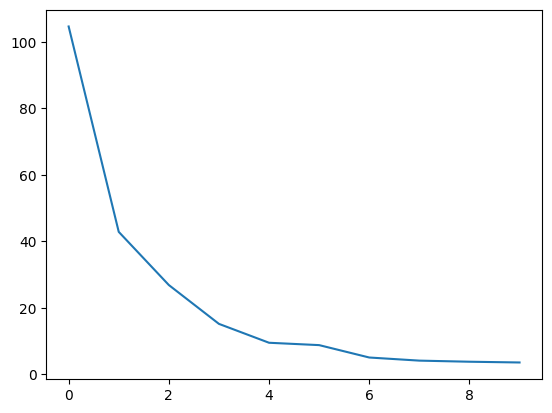

In [716]:
plt.plot(pca.singular_values_)

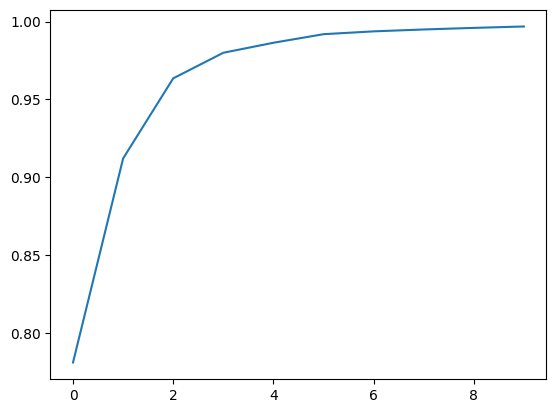

In [717]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [706]:
feats = np.arange(X.shape[1])
added = np.zeros_like(feats, dtype=bool)
added[features] = True

In [512]:
added

array([False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [513]:
X_corr[[1,7,15,19], :]

array([[0.90066277, 1.        , 0.31989412, 0.41061036, 0.45981024,
        0.51110546, 0.53129297, 0.54551079, 0.55226763, 0.53660947,
        0.53457714, 0.53001096, 0.52734792, 0.53380674, 0.52765248,
        0.55089075, 0.56329653, 0.60638294, 0.61795891, 0.63214792,
        0.64579805, 0.67172434, 0.68319102, 0.68483095, 0.67720343,
        0.68207456, 0.68634178, 0.69356938, 0.71003951, 0.71751224,
        0.73077403, 0.7010526 ],
       [0.36999772, 0.54551079, 0.88209573, 0.92492591, 0.95937156,
        0.98260345, 0.99469685, 1.        , 0.99427298, 0.98624395,
        0.97506744, 0.96248188, 0.94987966, 0.93875917, 0.91266459,
        0.88889687, 0.84828242, 0.81975699, 0.78719038, 0.76847203,
        0.76319607, 0.74992761, 0.7119182 , 0.68655016, 0.66578878,
        0.64894831, 0.63722414, 0.62064275, 0.61518737, 0.60592179,
        0.60314108, 0.53325513],
       [0.35015978, 0.55089075, 0.65238251, 0.71349399, 0.77621017,
        0.82812701, 0.86335914, 0.88889687, 0.9128

In [170]:
path = "../workdir/output_layers_4/qa/google/gemma-2b/sciq/2024-07-24/12-56-50/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/14-59-35/ue_manager_seed1"
#path = "../workdir/output_layers_4/qa/google/gemma-2b/['trivia_qa', 'rc.nocontext']/2024-07-24/13-57-18/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/15-30-12/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/16-57-07/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/17-11-48/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/18-28-27/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-2b/samsum/2024-07-24/19-56-02/ue_manager_seed1"
path = "../workdir/output_layers_6/qa/google/gemma-7b/sciq/2024-07-24/17-12-33/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-25/11-17-14/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-25/12-08-13/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-2b/xsum/2024-07-25/12-51-21/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/coqa/2024-07-25/15-12-30/ue_manager_seed1" 
#path = "../workdir/output_layers_9/ats/google/gemma-7b/xsum/2024-07-29/18-25-10/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-29/18-25-10/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-31/21-50-20/ue_manager_seed1" 

man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
#metric_names = ['Rouge_rougeL', 'AlignScore']

df = {}

for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_3414/269688129.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [ ]:
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-25/17-28-29/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-25/17-32-51/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-7b/sciq/2024-07-26/14-00-03/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-7b/sciq/2024-07-26/14-26-56/ue_manager_seed1"

man = torch.load(path)
metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

In [580]:
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-25/17-44-05/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-25/19-50-43/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-29/17-28-04/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-29/17-28-05/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-29/17-28-04/ue_manager_seed1"

man = torch.load(path)
metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

In [1817]:
for col in df0.columns:
    if "_2" in col:
        print(col, df0[col].values, df0[col.replace("_2", "_1")].values)

LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Accuracy, Accuracy, 0.3, , norm, tgt_norm, remove_corr_2) [0.58221278 0.50645799] [0.48817567 0.36950299]
LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Accuracy, Accuracy, 0.3, , unnorm, tgt_norm, remove_corr_2) [0.6418334  0.52580416] [0.47358899 0.30291891]
LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Accuracy, Accuracy, 0.3, , orig, tgt_norm, remove_corr_2) [0.53236078 0.3453716 ] [0.48627024 0.36169126]
LinRegTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Accuracy, Accuracy, 0.3, , scaler, tgt_norm, remove_corr_2) [0.55019862 0.37398822] [0.49214725 0.37187018]
LinRegRelativeTokenMahalanobisDistance_decoder16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,-1 (mean, Accuracy, Accuracy, 0.3, , norm, tgt_norm, remove_corr_2) [0.69549588 0.52006524] [0.63605177 0.46002505]
LinRegRelativ

In [1422]:
a = np.load('../workdir/output_layers_5/density_stats/mmlu_all/gemma-2b/train_dists_LinRegTokenMahalanobisDistance_decoder16,15,14,13,0,-1 (mean, AlignScore, AlignScore, 0.3, , orig, ).npy')
a.shape

(100, 6)

In [1822]:
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-24/14-59-35/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/sciq/2024-07-25/00-04-50/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-2b/samsum/2024-07-25/00-04-41/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/bigbio/pubmed_qa/2024-07-25/13-59-23/ue_manager_seed1"
path = "../workdir/output_layers_5/ats/google/gemma-2b/samsum/2024-07-25/13-59-41/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

In [1810]:
df0["LinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,-1 (mean, Rouge-L, Rouge-L, 0.3, , orig, tgt_norm, )"]

CoQA, Rouge_rougeL, PRR    0.292205
CoQA, AlignScore, PRR      0.176660
Name: LinRegRelativeTokenMahalanobisDistance_decoder0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,-1 (mean, Rouge-L, Rouge-L, 0.3, , orig, tgt_norm, ), dtype: float64

In [443]:
(regressor.coef_ < 0).sum()

6

In [1397]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train_seq_metrics[len(train_dists):][N:], regressor.predict(X)[N:])

0.8376571826759385

In [1398]:
rankdata(regressor.predict(X)[N:])

array([ 9.,  1.,  4.,  5.,  2.,  7., 10.,  6.,  8.,  3.])

In [1399]:
rankdata(regressor.predict(X)[N:])

array([ 9.,  1.,  4.,  5.,  2.,  7., 10.,  6.,  8.,  3.])

In [1400]:
regressor.predict(X)[N:][:3]

array([1.052066  , 0.34904107, 0.9070724 ], dtype=float32)

In [1382]:
regressor.predict(X)[N:][:3]

array([1.1077576, 0.5981131, 1.104537 ], dtype=float32)

In [997]:
coef

array([0.0000000e+00, 0.0000000e+00, 5.7525793e-04, 0.0000000e+00,
       0.0000000e+00, 1.9314510e-04, 0.0000000e+00, 2.6539839e-03,
       0.0000000e+00, 3.2963606e-03, 4.1821768e-04, 0.0000000e+00,
       5.9619069e-04, 0.0000000e+00, 3.0369248e-04, 0.0000000e+00,
       0.0000000e+00, 1.0892872e-05], dtype=float32)

In [650]:
a = regressor.coef_

In [651]:
b = regressor.coef_

In [575]:
a, b

(array([0.        , 0.        , 0.09437179, 0.0329783 , 0.        ,
        0.        , 0.        , 0.        , 0.13218577, 0.        ],
       dtype=float32),
 array([0.0000000e+00, 0.0000000e+00, 1.3487255e-04, 1.1729562e-06,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.5959019e-04, 0.0000000e+00], dtype=float32))

In [579]:
a[a>0]/a.sum(), b[b>0]/b.sum()

(array([0.36361754, 0.12706643, 0.509316  ], dtype=float32),
 array([0.34090087, 0.00296474, 0.6561344 ], dtype=float32))

In [1249]:
path = "../workdir/output_layers/qa/google/gemma-2b/coqa/2024-07-11/11-03-35/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-11/11-48-15/ue_manager_seed1"
#path = "../workdir/output_layers/ats/google/gemma-2b/samsum/2024-07-11/12-27-30/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-11/13-55-30/ue_manager_seed1"
path = "../workdir/output_layers/ats/google/gemma-2b/xsum/2024-07-11/13-55-01/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-11/15-52-01/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-11/17-11-59/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-11/18-28-53/ue_manager_seed1"
path = "../workdir/output_layers/ats/google/gemma-2b/xsum/2024-07-11/18-52-53/ue_manager_seed1"
###########
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-11/19-31-57/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-12/11-58-51/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-11/21-27-05/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/coqa/2024-07-11/23-50-44/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-12/13-15-59/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-12/13-27-41/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-12/13-37-36/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-12/13-48-10/ue_manager_seed1"
#path = "../workdir/output_layers/ats/google/gemma-2b/xsum/2024-07-12/14-10-41/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/bigbio/pubmed_qa/2024-07-12/14-37-03/ue_manager_seed1"
#path = "../workdir/output_layers/ats/google/gemma-2b/xsum/2024-07-12/14-37-03/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/sciq/2024-07-12/15-34-18/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-2b/coqa/2024-07-12/15-52-48/ue_manager_seed1"
path = "../workdir/output_layers/ats/google/gemma-2b/samsum/2024-07-12/16-12-18/ue_manager_seed1"
##########

path = "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-07-12/19-40-16/ue_manager_seed1"
path = "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-12/20-56-33/ue_manager_seed1"
path = "../workdir/output_layers/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-07-12/21-37-44/ue_manager_seed1"
#########
path = "../workdir/output_layers_3/qa/google/gemma-7b/sciq/2024-07-22/17-30-13/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-22/18-49-46/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-23/19-02-52/ue_manager_seed1"
# path = "../workdir/output_layers_3/ats/google/gemma-2b/samsum/2024-07-23/13-10-07/ue_manager_seed1"
# path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-23/14-54-15/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-23/20-40-34/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-2b/['trivia_qa', 'rc.nocontext']/2024-07-23/21-06-19/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-23/22-17-51/ue_manager_seed1"
#####
path = "../workdir/output_layers_3/qa/google/gemma-2b/sciq/2024-07-24/10-37-44/ue_manager_seed1"
path = "../workdir/output_layers_4/qa/google/gemma-2b/sciq/2024-07-24/12-56-50/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-2b/['cais/mmlu', 'all']/2024-07-24/14-30-51/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

In [1416]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, , 0)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder"]
suf = "(mean, , 0)"#"(mean, Accuracy, 0.3)"
i = 1
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name, suf)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 17 for x in cols]
    plt.plot(layers, df0[cols].values[i], label=name)

suf = "(mean, Accuracy, 0.3)"
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name, suf)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 17 for x in cols]
    plt.plot(layers, df0[cols].values[i], label=name + " clean")
    
plt.plot(layers, [df0['MaximumSequenceProbability'][i]]*len(layers), label="MSP")
for c in df0.columns[-16:]:
    if "relative" in c.lower():
        continue
    label = "LinReg"
    if "pos" in c:
        label += " pos."
    if "Accuracy, Accuracy" in c:
        label += " T:Acc; C:Acc"
    if "AlignScore, Accuracy" in c:
        label += " T:AlS; C:Acc"
    if "Accuracy, AlignScore" in c:
        label += " T:Acc; C:AlS"
    if "AlignScore, AlignScore" in c:
        label += " T:AlS; C:AlS"
        
    plt.plot(layers, [df0[c][i]]*len(layers), label=label)

plt.xlabel("Layer")
plt.ylabel("AlignScore, PRR")
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))

/tmp/ipykernel_722/3760590682.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][i]]*len(layers), label="MSP")
/tmp/ipykernel_722/3760590682.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0[c][i]]*len(layers), label=label)


In [827]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, , 0)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder"]
suf = "(mean, , 0)"#"(mean, Accuracy, 0.3)"
i = 0
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name, suf)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 17 for x in cols]
    plt.plot(layers, df0[cols].values[i], label=name)

suf = "(mean, Accuracy, 0.3)"
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name, suf)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 17 for x in cols]
    plt.plot(layers, df0[cols].values[i], label=name + " clean")
    
plt.plot(layers, [df0['MaximumSequenceProbability'][i]]*len(layers), label="MSP")
for c in df0.columns[-16:]:
    if "relative" in c.lower():
        continue
    label = "LinReg"
    if "pos" in c:
        label += " pos."
    if "Accuracy, Accuracy" in c:
        label += " T:Acc; C:Acc"
    if "AlignScore, Accuracy" in c:
        label += " T:AlS; C:Acc"
    if "Accuracy, AlignScore" in c:
        label += " T:Acc; C:AlS"
    if "AlignScore, AlignScore" in c:
        label += " T:AlS; C:AlS"
        
    plt.plot(layers, [df0[c][i]]*len(layers), label=label)

plt.xlabel("Layer")
plt.ylabel("Accuracy, PRR")
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))

/tmp/ipykernel_722/3933423135.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][i]]*len(layers), label="MSP")
/tmp/ipykernel_722/3933423135.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0[c][i]]*len(layers), label=label)


In [783]:
len(man["stats"]["greedy_texts"])

100

In [165]:
path = "../workdir/output_layers/qa/google/gemma-2b/coqa/2024-07-11/11-03-35/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-11/11-48-15/ue_manager_seed1"
path = "../workdir/output_layers/ats/google/gemma-2b/samsum/2024-07-11/13-21-44/ue_manager_seed1"
#./workdir/output_layers_5/qa/google/gemma-7b/sciq/2024-08-23/11-47-24/ue_manager_seed1  ./workdir/output_layers_5/qa/google/gemma-7b/sciq/2024-08-23/11-52-02/ue_manager_seed1
path = "../workdir/output_layers_5/qa/google/gemma-7b/sciq/2024-08-23/12-07-48/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_8818/2890954247.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [166]:
path = "../workdir/output_layers/qa/google/gemma-2b/coqa/2024-07-11/11-03-35/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-2b/['truthful_qa', 'generation']/2024-07-11/11-48-15/ue_manager_seed1"
path = "../workdir/output_layers/ats/google/gemma-2b/samsum/2024-07-11/13-21-44/ue_manager_seed1"
path = "../workdir/output_layers_5/qa/google/gemma-7b/sciq/2024-08-23/12-25-18/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_8818/1744909085.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [712]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.47

/tmp/ipykernel_722/2464449270.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


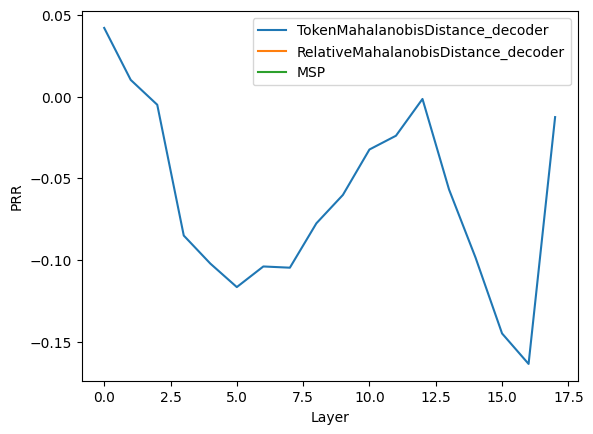

In [719]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, , 0)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 17 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

# SciQ

## Vicuna 7b

In [66]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/sciq/2024-04-09/22-25-46/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AttributeError: 'NoneType' object has no attribute 'model'

In [ ]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

## Vicuna 13b

In [61]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-13b-v1.5/sciq/2024-04-09/22-25-26/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [62]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.518

## Mistral 7b

In [124]:
path = "lm-polygraph/workdir/output/qa/alpindale/Mistral-7B-v0.2-hf/sciq/2024-04-10/05-00-23/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [64]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.146

## LLama 3 8b

In [173]:
path = "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-03/15-43-35/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

In [174]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.395

/tmp/ipykernel_45993/1744307022.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


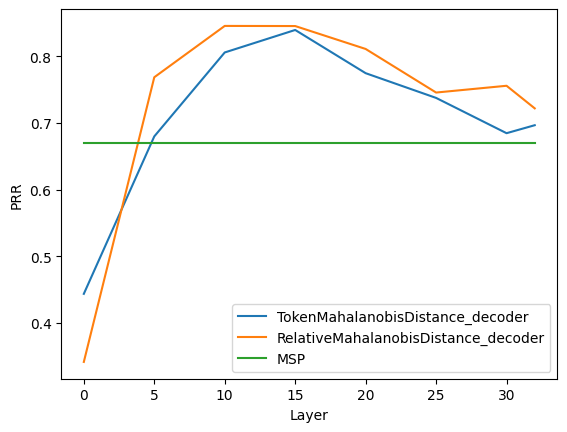

In [175]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, accuracy, 0.5)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

## Gemma 7b

In [100]:
path = "../workdir/output/qa/google/gemma-7b/sciq/2024-07-03/22-16-46/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

In [5]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.549

/tmp/ipykernel_45993/3417078518.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


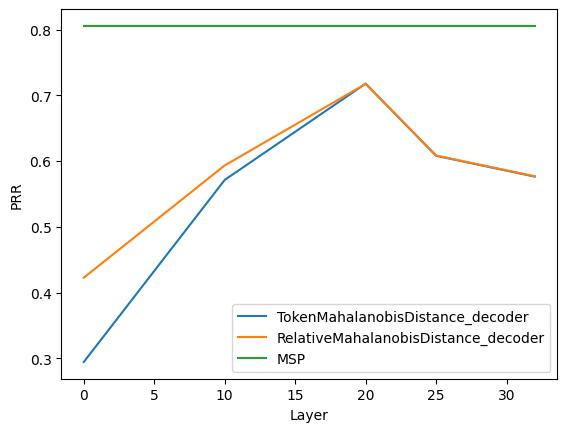

In [102]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

# TriviaQA

## Vicuna 7b

In [65]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/['trivia_qa', 'rc.nocontext']/2024-04-09/22-25-24/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'TriviaQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"TriviaQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [66]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.335

## Vicuna 13b

In [67]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-13b-v1.5/['trivia_qa', 'rc.nocontext']/2024-04-09/22-25-24/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'TriviaQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"TriviaQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [68]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.528

## Mistral 7b

In [126]:
path = "lm-polygraph/workdir/output/qa/alpindale/Mistral-7B-v0.2-hf/['trivia_qa', 'rc.nocontext']/2024-04-10/05-00-05/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'TriviaQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"TriviaQA, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [127]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.558

## Gemma

In [107]:
path = "../workdir/output/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-04/01-41-50/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_45993/806350166.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


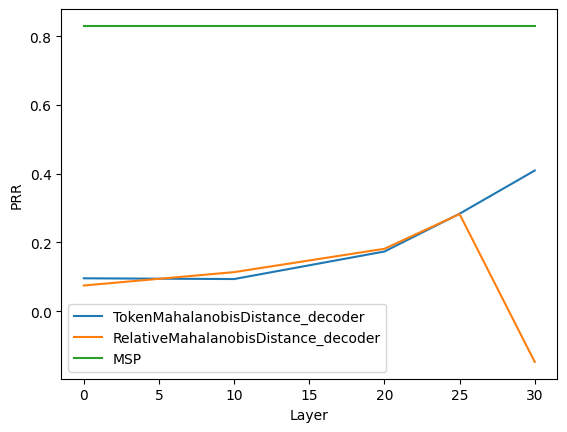

In [110]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 30 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

In [14]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.551

# MMLU

## Vicuna 7b

In [74]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/['cais/mmlu', 'all']/2024-04-09/22-25-26/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'MMLU, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"MMLU, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [75]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.403

## Vicuna 13b

In [76]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-13b-v1.5/['cais/mmlu', 'all']/2024-04-09/22-25-26/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'MMLU, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"MMLU, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [77]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.4865

## Mistral 7b

In [129]:
path = "lm-polygraph/workdir/output/qa/alpindale/Mistral-7B-v0.2-hf/['cais/mmlu', 'all']/2024-04-10/05-00-23/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'MMLU, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"MMLU, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [79]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.5575

# GSM8k

## Vicuna 7b

In [80]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-7b-v1.5/['gsm8k', 'main']/2024-04-09/23-14-31/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'GSM8k, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"GSM8k, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [81]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.129

## Vicuna 13b

In [82]:
path = "lm-polygraph/workdir/output/qa/lmsys/vicuna-13b-v1.5/['gsm8k', 'main']/2024-04-09/23-14-30/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'GSM8k, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"GSM8k, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [83]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.191

## Mistral 7b

In [131]:
path = "lm-polygraph/workdir/output/qa/alpindale/Mistral-7B-v0.2-hf/['gsm8k', 'main']/2024-04-09/23-14-29/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Accuracy']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'GSM8k, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"GSM8k, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [85]:
np.mean(man.gen_metrics[('sequence', 'Accuracy')])

0.323

## Gemma 7b

In [156]:
path = "../workdir/output/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-03/18-32-16/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_45993/3417078518.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


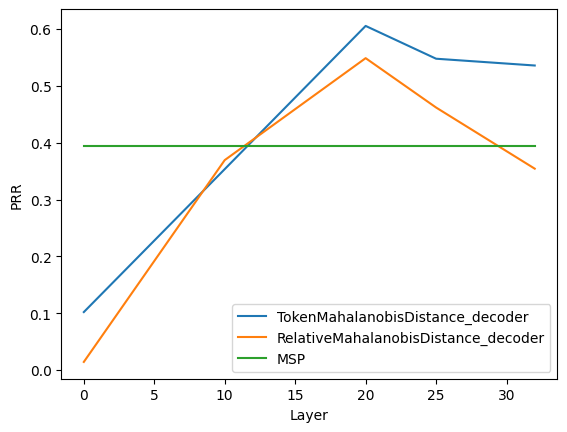

In [157]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

In [158]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.568

## Llama 3

In [6]:
path = "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-07-09/10-13-16/ue_manager_seed1"
man = torch.load(path)
metric_names = ['Accuracy']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

In [8]:
man["estimations"][('sequence', 'TokenMahalanobisDistance_decoder (mean, , 0)')]

[1709.782958984375,
 1588.97314453125,
 1667.5653076171875,
 1943.2642822265625,
 1752.0635986328125,
 1769.36669921875,
 1841.2806396484375,
 1886.8526611328125,
 1250.525634765625,
 1611.755859375]

In [159]:
path = "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-07-04/04-09-02/ue_manager_seed1"
man = torch.load(path)
metric_names = ['Accuracy']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_45993/3417078518.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


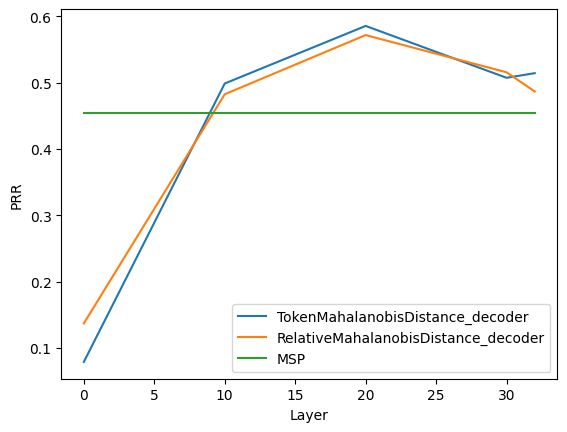

In [160]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

In [93]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.536

# XSUM

## Vicuna 7b

In [87]:
path = "lm-polygraph/workdir/output/ats/lmsys/vicuna-7b-v1.5/xsum/2024-04-09/23-14-30/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'XSUM, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"XSUM, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [88]:
np.mean(man.gen_metrics[('sequence', 'AlignScore')])

0.0621609894928406

## Vicuna 13b

In [89]:
path = "lm-polygraph/workdir/output/ats/lmsys/vicuna-13b-v1.5/xsum/2024-04-09/23-14-29/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'XSUM, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"XSUM, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [90]:
np.mean(man.gen_metrics[('sequence', 'AlignScore')])

0.08629431277797267

## Mistral 7b

In [133]:
path = "lm-polygraph/workdir/output/ats/alpindale/Mistral-7B-v0.2-hf/xsum/2024-04-09/23-14-31/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'XSUM, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"XSUM, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [134]:
np.mean(man.gen_metrics[('sequence', 'AlignScore')]), np.mean(man.gen_metrics[('sequence', 'Rouge_rougeL')])

(0.034991165048508265, 0.20618126565166967)

## Stablm 12b

In [136]:
path = "lm-polygraph/workdir/output/ats/stabilityai/stablelm-2-12b/xsum/2024-04-10/05-39-18/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'XSUM, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"XSUM, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [137]:
np.mean(man.gen_metrics[('sequence', 'AlignScore')])

0.08725634816825187

## LLama 

In [175]:
path = "../workdir/output/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-07-04/04-09-02/ue_manager_seed1"
path = "../workdir/output_layers_6/qa/google/gemma-7b/sciq/2024-08-27/14-52-16/ue_manager_seed1"
path = "../workdir/output_layers_6/qa/google/gemma-7b/sciq/2024-08-27/15-06-26/ue_manager_seed1"
man = torch.load(path)

metric_names = ['RougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_298440/3162481331.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


/tmp/ipykernel_45993/1930615668.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][1]]*len(layers), label="MSP")


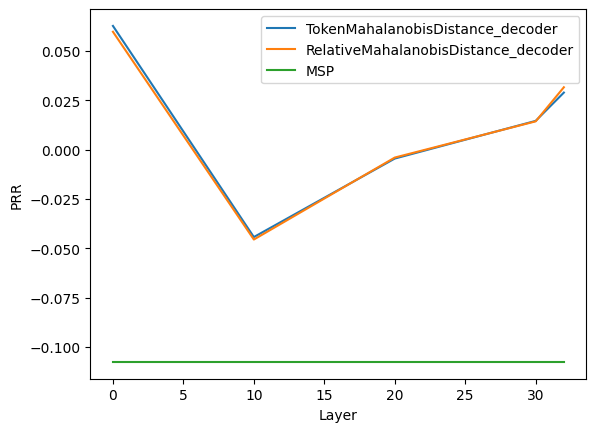

In [127]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, AlignScore, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[1], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][1]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

## Gemma 7b

In [131]:
path = "../workdir/output/ats/google/gemma-7b/xsum/2024-07-03/18-32-16/ue_manager_seed1"
man = torch.load(path)

metric_names = ['RougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_45993/2702456290.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][1]]*len(layers), label="MSP")


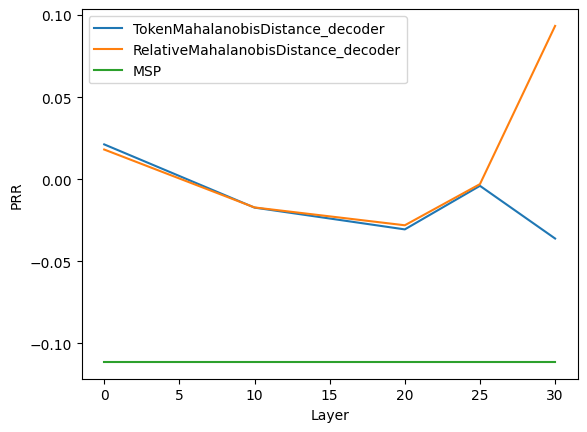

In [133]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, AlignScore, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 30 for x in cols]
    
    plt.plot(layers, df0[cols].values[1], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][1]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

In [19]:
np.mean(man['gen_metrics'][('sequence', 'AlignScore')])

0.03941326216568268

# WMT 14 De-En

## Vicuna 7b

In [110]:
path = "lm-polygraph/workdir/output/nmt/lmsys/vicuna-7b-v1.5/['wmt14', 'de-en']/2024-04-09/23-14-31/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Comet', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'WMT14 De-En, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"WMT14 De-En, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [111]:
np.mean(man.gen_metrics[('sequence', 'Comet')])

0.8373594695329666

In [112]:
path = "lm-polygraph/workdir/output/nmt/lmsys/vicuna-13b-v1.5/['wmt14', 'de-en']/2024-04-09/23-14-31/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Comet', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'WMT14 De-En, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"WMT14 De-En, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [113]:
np.mean(man.gen_metrics[('sequence', 'Comet')])

0.8482999328076839

## Mistral 7b

In [114]:
path = "lm-polygraph/workdir/output/nmt/alpindale/Mistral-7B-v0.2-hf/['wmt14', 'de-en']/2024-04-10/05-39-15/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Comet', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'WMT14 De-En, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"WMT14 De-En, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [116]:
np.mean(man.gen_metrics[('sequence', 'Comet')])

0.5119356378316879

## Stablm 12b

In [119]:
path = "lm-polygraph/workdir/output/nmt/stabilityai/stablelm-2-12b/['wmt14', 'de-en']/2024-04-10/05-39-15/ue_manager_seed1"
man = UEManager.load(path)

metric_names = ['Comet', 'AlignScore']
df = {}
for key in man.metrics.keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man.metrics[key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'WMT14 De-En, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"WMT14 De-En, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7fc48b67cf40>]


In [120]:
np.mean(man.gen_metrics[('sequence', 'Comet')])

0.822441279232502

## Gemma 7b

In [21]:
path = "../workdir/output/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-07-04/00-23-51/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Comet', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

In [22]:
np.mean(man['gen_metrics'][('sequence', 'Comet')])

0.8509953519105912

# MMLU

In [9]:
path = "../workdir/output/qa/{'path': 'google/gemma-7b', 'ensemble': False, 'mc': False, 'mc_seeds': None, 'dropout_rate': None, 'device_map': 'auto', 'attn_implementation': 'eager'}/['cais/mmlu', 'all']/2024-07-04/00-23-51/ue_manager_seed1"
# path = "../../polygraph_tacl_fixed/workdir/output/qa/{'path': 'alpindale//Mistral-7B-v0.2-hf', 'ensemble': False, 'mc': False, 'mc_seeds': None, 'dropout_rate': None, 'type': 'CausalLM', 'path_to_load_script': 'model/default_causal.py', 'load_model_args': {'device_map': 'auto'}, 'load_tokenizer_args': {}}/['cais/mmlu', 'all']/2024-08-24/13-48-35/ue_manager_seed1"
# path = "../../polygraph_tacl_fixed/workdir/output/qa/{'path': 'stabilityai//stablelm-2-12b', 'ensemble': False, 'mc': False, 'mc_seeds': None, 'dropout_rate': None, 'type': 'CausalLM', 'path_to_load_script': 'model/default_causal.py', 'load_model_args': {'device_map': 'auto'}, 'load_tokenizer_args': {}}/['cais/mmlu', 'all']/2024-08-24/13-48-35/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_298440/4042604227.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


FileNotFoundError: [Errno 2] No such file or directory: "../workdir/output/qa/{'path': 'google/gemma-7b', 'ensemble': False, 'mc': False, 'mc_seeds': None, 'dropout_rate': None, 'device_map': 'auto', 'attn_implementation': 'eager'}/['cais/mmlu', 'all']/2024-07-04/00-23-51/ue_manager_seed1"

In [8]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.6319298245614036

/tmp/ipykernel_45993/1771217357.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")


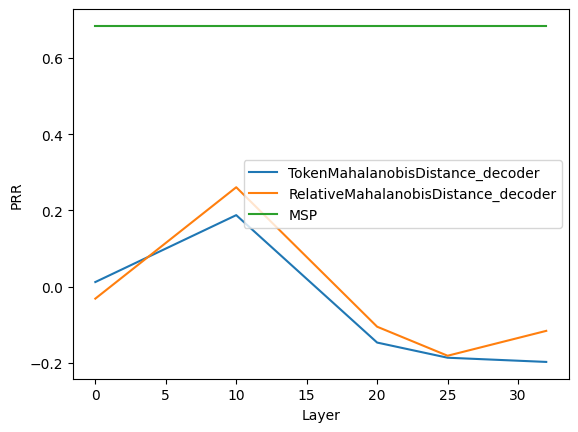

In [136]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, AlignScore, 0.3)"):
    return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]
for name in names:
    cols = [x for x in df0.columns if check_cond(x, name)]
    layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
    
    plt.plot(layers, df0[cols].values[0], label=name)
plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.legend()

In [62]:
from sklearn.model_selection import train_test_split

train_test_split(list(range(10)), shuffle=False, train_size=0.5, random_state=2)

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]

# TruthFulQA 

In [2]:
#path = "../workdir/output/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-04/09-12-59/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-08/17-39-19/ue_manager_seed1"
path = "../workdir/output_layers_6/qa/google/gemma-7b/sciq/2024-08-27/15-23-59/ue_manager_seed1" 
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-27/18-22-50/ue_manager_seed1"
path = "../workdir/output_layers_7/ats/google/gemma-7b/xsum/2024-08-28/17-46-55/ue_manager_seed1"
path = "../workdir/output_layers_7/qa/google/gemma-7b/sciq/2024-08-29/10-31-32/ue_manager_seed1"
path = "../workdir/output_layers_7/qa/google/gemma-7b/sciq/2024-08-29/10-58-18/ue_manager_seed1"
path = "../workdir/output_layers_7/qa/google/gemma-7b/sciq/2024-08-29/13-57-34/ue_manager_seed1"
path = "../workdir/output_layers_7/qa/google/gemma-7b/sciq/2024-08-29/18-11-53/ue_manager_seed1"

path = "../workdir/output_layers_/qa/google/gemma-7b/sciq/2024-08-30/16-32-32/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-30/19-03-41/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-31/04-11-37/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-31/12-16-38/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-31/18-17-22/ue_manager_seed1"
# path = "../workdir/output_layers_internal/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-30/19-03-34/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-30/19-03-39/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-31/16-56-18/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-03/21-25-45/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-02/18-42-09/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-09-04/06-27-17/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-09-04/04-41-36/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-09-04/00-05-18/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-04/13-44-24/ue_manager_seed1"
#path = "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-17/00-46-31/ue_manager_seed1"
path = "../workdir/output_layers_internal/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-09-04/13-58-55/ue_manager_seed1"
# path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-04/13-56-33/ue_manager_seed1"
# path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-09-04/14-28-48/ue_manager_seed1"
# path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-09-04/13-56-33/ue_manager_seed1"
# path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-09-04/14-42-27/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-09-04/15-18-08/ue_manager_seed1"
path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-09-04/13-56-32/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-09-04/16-17-20/ue_manager_seed1"
path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/qa/meta-llama/Meta-Llama-3-8B/bigbio/pubmed_qa/2024-09-04/15-46-22/ue_manager_seed1"
# path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-09-04/15-30-01/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-09-04/17-37-31/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-04/17-44-05/ue_manager_seed1"
# path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-09-04/17-55-36/ue_manager_seed1"
#path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-09-04/13-56-32/ue_manager_seed1"
# path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/ats/meta-llama/Meta-Llama-3-8B/['cnn_dailymail', '3.0.0']/2024-09-04/18-55-10/ue_manager_seed1"
# path = "/home/jovyan/artemvazhentsev/llm-tad-uncertainty/workdir/final_cv_output_new/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-09-05/11-12-16/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-05/15-05-49/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-05/16-38-11/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-05/00-39-23/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-07/09-21-56/ue_manager_seed1"
# path = "../workdir/output_layers_internal/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-09-09/18-06-14/ue_manager_seed1"
# path = "../workdir/output_layers_internal/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-09-09/23-37-38/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-10/04-53-08/ue_manager_seed1"
# path = "../workdir/output_layers_internal/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-09-10/14-31-32/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/keivalya/MedQuad-MedicalQnADataset/2024-09-10/06-44-57/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-09-11/11-44-17/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-09-11/12-18-26/ue_manager_seed1"
path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-11/15-24-35/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-11/18-29-11/ue_manager_seed1"

path = "/home/jovyan/artemvazhentsev/lmp_verb/emprical_baselines/workdir/output/coqa_ling_1s/qa/meta-llama/Meta-Llama-3.1-8B-Instruct/coqa/2024-09-11/18-20-52/ue_manager_seed1"
path = "/home/jovyan/artemvazhentsev/lmp_verb/emprical_baselines/workdir/output/coqa_verb_1s_top1/qa/meta-llama/Meta-Llama-3.1-8B-Instruct/coqa/2024-09-11/20-18-18/ue_manager_seed1"
path = "/home/jovyan/artemvazhentsev/lmp_verb/emprical_baselines/workdir/output/coqa_verb_1s_top1/qa/meta-llama/Meta-Llama-3.1-8B-Instruct/coqa/2024-09-11/20-18-18/ue_manager_seed1"
path = "/home/jovyan/artemvazhentsev/lmp_verb/emprical_baselines/workdir/output/coqa_verb_2s_top1/qa/meta-llama/Meta-Llama-3.1-8B-Instruct/coqa/2024-09-11/22-13-59//ue_manager_seed1"

path = "/home/jovyan/artemvazhentsev/lmp_verb/emprical_baselines/workdir/output/mmlu_verb_2s_top1/qa/meta-llama/Meta-Llama-3.1-8B-Instruct/['cais/mmlu', 'all']/2024-09-12/05-18-00/ue_manager_seed1"
path = "/home/jovyan/artemvazhentsev/lmp_verb/emprical_baselines/workdir/output/mmlu_ling_1s/qa/meta-llama/Meta-Llama-3.1-8B-Instruct/['cais/mmlu', 'all']/2024-09-11/18-21-09/ue_manager_seed1"
path = "/home/jovyan/artemvazhentsev/lmp_verb/emprical_baselines/workdir/output/mmlu_verb_1s_top1/qa/meta-llama/Meta-Llama-3.1-8B-Instruct/['cais/mmlu', 'all']/2024-09-11/23-52-17/ue_manager_seed1"


path = "/home/jovyan/artemvazhentsev/lmp_verb/emprical_baselines/workdir/output/triviaqa_ling_1s/qa/meta-llama/Meta-Llama-3.1-8B-Instruct/['trivia_qa', 'rc.nocontext']/2024-09-12/10-54-31/ue_manager_seed1"
path = "/home/jovyan/artemvazhentsev/polygraph_tacl/workdir/mistral_triviaqa_all_options.man"
path = "../workdir/output_layers_internal/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-12/10-19-03/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-09-12/16-06-12/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-13/11-34-42/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-13/15-18-57/ue_manager_seed1"
path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-14/12-10-04/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-16/11-34-27/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-16/12-07-45/ue_manager_seed1"
path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/bigbio/pubmed_qa/2024-09-14/12-10-00/ue_manager_seed1"
path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/coqa/2024-09-15/07-47-14/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/16-04-20/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/23-17-21/ue_manager_seed1"
# path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['gsm8k', 'main']/2024-09-17/23-17-19/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['gsm8k', 'main']/2024-09-18/02-44-04/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/16-16-13/ue_manager_seed1"

# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/coqa/2024-09-17/23-35-32/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_test/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-18/11-36-19/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_test/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-18/11-42-04/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_test/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-18/11-47-51/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['gsm8k', 'main']/2024-09-17/16-16-16/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_test/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-18/12-19-37/ue_manager_seed1"
# path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-18/17-19-09/ue_manager_seed1"
# path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/coqa/2024-09-18/19-59-22/ue_manager_seed1"
# path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/coqa/2024-09-19/04-49-07/ue_manager_seed1"
# path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['trivia_qa', 'rc.nocontext']/2024-09-18/23-01-26/ue_manager_seed1"
# path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-09-19/01-36-23/ue_manager_seed1"
# path = "../workdir/gen_output_loo/ats/meta-llama/Meta-Llama-3.1-8B/xsum/2024-09-18/17-19-24/ue_manager_seed1"
# path = "../workdir/gen_output_loo/ats/meta-llama/Meta-Llama-3.1-8B/xsum/2024-09-19/00-38-26/ue_manager_seed1"
# path = "../workdir/gen_output_loo/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-19/12-59-34/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-19/13-01-43/ue_manager_seed1"
# path = "../workdir/gen_output_loo/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-19/16-00-25/ue_manager_seed1"
# path = "../workdir/gen_output_loo/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-19/23-19-40/ue_manager_seed1"
# path =  "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/keivalya/MedQuad-MedicalQnADataset/2024-08-11/16-34-44/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-21/13-14-10/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['gsm8k', 'main']/2024-09-21/13-13-18/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-09-22/05-46-18/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-22/11-47-10/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/bigbio/pubmed_qa/2024-09-21/13-13-18/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/coqa/2024-09-21/17-35-26/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['trivia_qa', 'rc.nocontext']/2024-09-22/00-20-00/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-09-22/09-46-08/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/nmt/meta-llama/Meta-Llama-3.1-8B/['wmt14', 'fr-en']/2024-09-22/16-02-15/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/nmt/meta-llama/Meta-Llama-3.1-8B/['wmt19', 'de-en']/2024-09-23/13-54-29/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/xsum/2024-09-24/09-59-21/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/['cnn_dailymail', '3.0.0']/2024-09-23/16-37-53/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/keivalya/MedQuad-MedicalQnADataset/2024-09-26/09-25-56/ue_manager_seed1"

# path = "../workdir/output_layers_internal_final/qa/google/gemma-2-9b/coqa/2024-09-22/21-51-38/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/google/gemma-2-9b/sciq/2024-09-22/17-41-53/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/google/gemma-2-9b/['trivia_qa', 'rc.nocontext']/2024-09-23/05-01-04/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/google/gemma-2-9b/['cais/mmlu', 'all']/2024-09-23/10-20-47/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/ats/google/gemma-2-9b/samsum/2024-09-23/16-47-40/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/google/gemma-2-9b/['truthful_qa', 'generation']/2024-09-23/14-21-03/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/nmt/google/gemma-2-9b/['wmt14', 'fr-en']/2024-09-24/04-38-27/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['cais/mmlu', 'all']/2024-09-25/12-34-15/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['cais/mmlu', 'all']/2024-09-25/12-38-01/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/sciq/2024-09-25/13-06-44/ue_manager_seed1"


# path = "../workdir/output_layers_3/nmt/meta-llama/Meta-Llama-3-8B/['wmt14', 'de-en']/2024-08-23/22-52-33/ue_manager_seed1"
# path = "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/['cnn_dailymail', '3.0.0']/2024-08-24/17-55-46/ue_manager_seed1"

# path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['cais/mmlu', 'all']/2024-09-25/14-07-32/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/sciq/2024-09-26/09-25-56/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/coqa/2024-09-26/17-54-44/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/bigbio/pubmed_qa/2024-09-28/01-21-29/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['trivia_qa', 'rc.nocontext']/2024-09-27/08-52-14/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['truthful_qa', 'generation']/2024-09-27/20-41-49/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/ats/Qwen/Qwen2.5-7B/xsum/2024-09-29/17-22-43/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/ats/Qwen/Qwen2.5-7B/samsum/2024-09-28/01-54-42/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/nmt/Qwen/Qwen2.5-7B/['wmt19', 'de-en']/2024-09-29/10-09-33/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/['cnn_dailymail', '3.0.0']/2024-09-23/16-37-53/ue_manager_seed1"

path = "../workdir/gen_output_loo/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-20/00-31-47/ue_manager_seed1"
path = "../workdir/gen_output_loo/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-19/12-59-34/ue_manager_seed1"
path = "../workdir/gen_output_loo/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-10-03/13-23-05/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-10-03/13-00-50/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-10-03/18-10-26/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-10-04/12-38-50/ue_manager_seed1"
# path = "../workdir/gen_output_loo_final_2/qa/meta-llama/Meta-Llama-3.1-8B/keivalya/MedQuad-MedicalQnADataset/2024-10-07/11-28-51/ue_manager_seed1"
# path = "../workdir/gen_output_loo_final/qa/google/gemma-2-9b/keivalya/MedQuad-MedicalQnADataset/2024-10-07/23-19-47/ue_manager_seed1"
# path = "../workdir/gen_output_loo_final_2/qa/google/gemma-2-9b/keivalya/MedQuad-MedicalQnADataset/2024-10-08/05-46-33/ue_manager_seed1"
path = "../workdir/lig/gemma/ue_manager_seed1"


# path = "../workdir/gen_output_loo_final_2/ats/google/gemma-2-9b/samsum/2024-10-09/04-56-04/ue_manager_seed1"
# path = "../workdir/gen_output_loo_final_2/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-10-08/17-59-20/ue_manager_seed1"
# path = "../workdir/gen_output_loo_final_2/qa/google/gemma-2-9b/['cais/mmlu', 'all']/2024-10-08/20-30-18/ue_manager_seed1"
# path = "../workdir/gen_output_loo_final_2/qa/google/gemma-2-9b/sciq/2024-10-09/02-56-52/ue_manager_seed1"
# path = "../workdir/gen_output_loo_final_2/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-10-08/16-00-34/ue_manager_seed1"

# path = "../workdir/gen_output_loo_final/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-10-04/18-03-50/ue_manager_seed1"
# path = "../workdir/gen_output_loo_final/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-10-05/04-52-21/ue_manager_seed1"




#################
path = "../workdir/output_stable_test/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-10-25/19-15-38/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['gsm8k', 'main']/2024-11-02/18-11-10/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['gsm8k', 'main']/2024-11-14/16-04-15/ue_manager_seed1"
# path = "../workdir/output_stable_test/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-11-05/15-40-17/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['gsm8k', 'main']/2024-09-21/13-13-18/ue_manager_seed1"
path = "../workdir/gen_output_loo_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-11-18/11-24-57/ue_manager_seed1"
path = "../workdir/gen_output_loo_final/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-11-18/15-40-35/ue_manager_seed1"
# path = "../workdir/gen_output_loo_final/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-11-18/19-44-14/ue_manager_seed1"
path = "../workdir/gen_output_loo_new/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-11-20/16-14-13/ue_manager_seed1"
path = "../workdir/gen_output_loo_new/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-11-20/18-13-25/ue_manager_seed1" # sim ds
path = "../workdir/gen_output_loo_new/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-11-20/20-25-06/ue_manager_seed1" # all ds
path = "../workdir/gen_output_loo_new/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-11-21/15-24-15/ue_manager_seed1" # sim 1k
path = "../workdir/gen_output_loo_new_on_pubmedqa/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-11-22/20-17-38/ue_manager_seed1"
path = "../workdir/gen_output_loo_new/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-11-26/16-36-13/ue_manager_seed1"
# 
# path = "../workdir/gen_output_loo_new/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-11-20/20-23-57/ue_manager_seed1" # sim
# path = "../workdir/gen_output_loo_new/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-11-21/01-15-39/ue_manager_seed1" # all
# path = "../workdir/gen_output_loo_new/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-11-21/20-28-18/ue_manager_seed1" # sim 1k
# path = "../workdir/gen_output_loo_new_on_xsum/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-11-22/22-51-15/ue_manager_seed1"
# path = "../workdir/gen_output_loo_new_on_cnn/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-11-25/17-44-29/ue_manager_seed1"
# path = "../workdir/gen_output_loo_new/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-11-27/00-11-56/ue_manager_seed1"
# 
# path = "../workdir/gen_output_loo_new/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-11-20/22-49-27/ue_manager_seed1" # sim
# path = "../workdir/gen_output_loo_new/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-11-21/05-41-06/ue_manager_seed1" # all
# path = "../workdir/gen_output_loo_new/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-11-22/00-42-39/ue_manager_seed1" # sim 1k 
# path = "../workdir/gen_output_loo_new_on_coqa/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-11-23/02-20-30/ue_manager_seed1"
# path = "../workdir/gen_output_loo_new_on_triviaqa/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-11-25/22-57-49/ue_manager_seed1"
# path = "../workdir/gen_output_loo_new_on_mmlu/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-11-26/02-39-21/ue_manager_seed1"

# path = "../workdir/gen_output_loo_new/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-11-21/12-58-46/ue_manager_seed1" # sim 1k
path = "../workdir/gen_output_loo_new/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-11-22/11-03-27/ue_manager_seed1" # all
# path = "../workdir/gen_output_loo_new_on_coqa/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-11-23/03-51-14/ue_manager_seed1"
# path = "../workdir/gen_output_loo_new_on_sciq/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-11-22/18-05-53/ue_manager_seed1"
# path = "../workdir/gen_output_loo_new_on_triviaqa/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-11-26/00-36-28/ue_manager_seed1"

path = "../workdir/gen_output_mix/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-11-28/11-18-40/ue_manager_seed1"
path = "/home/jovyan/artemvazhentsev/test_tad/llm-tad-uncertainty/workdir/output/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-11-28/16-28-12/ue_manager_seed1"
path = "../workdir/gen_output_mix/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-12-03/11-27-18/ue_manager_seed1"
# 

#############
path = "../workdir/output_layers_internal_final_factoscope/qa/meta-llama/Meta-Llama-3.1-8B/coqa/2024-12-16/17-34-17/ue_manager_seed1"
path = "../workdir/output_layers_internal_final_factoscope/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-12-16/15-25-42/ue_manager_seed1"
path = "../workdir/output_layers_internal_final_factoscope/qa/meta-llama/Meta-Llama-3.1-8B/['trivia_qa', 'rc.nocontext']/2024-12-16/20-17-13/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_factoscope/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-12-16/22-36-51/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_factoscope/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-12-16/23-43-19/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_factoscope/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-12-17/00-51-56/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_factoscope/ats/meta-llama/Meta-Llama-3.1-8B/['cnn_dailymail', '3.0.0']/2024-12-17/03-36-49/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_factoscope/ats/meta-llama/Meta-Llama-3.1-8B/xsum/2024-12-17/09-16-31/ue_manager_seed1"
path = "../workdir/output_layers_internal_final_factoscope/qa/meta-llama/Meta-Llama-3.1-8B/keivalya/MedQuad-MedicalQnADataset/2024-12-18/01-37-14/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/keivalya/MedQuad-MedicalQnADataset/2024-09-26/09-25-56/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_factoscope/qa/meta-llama/Meta-Llama-3.1-8B/bigbio/pubmed_qa/2024-12-17/21-35-57/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final_factoscope/qa/meta-llama/Meta-Llama-3.1-8B/['gsm8k', 'main']/2024-12-17/13-26-47/ue_manager_seed1"
############
path = "../workdir/output_layers_internal_final_100/qa/meta-llama/Meta-Llama-3.1-8B/keivalya/MedQuad-MedicalQnADataset/2024-10-13/14-04-50/ue_manager_seed1"


man = torch.load(path)

metric_names = ["Accuracy", "AlignScore"]#
metric_names = ['Rouge_rougeL', 'AlignScoreMean']
# metric_names = ['Accuracy', 'AlignScoreMean']
# metric_names = ['Rouge_rougeL', 'AlignScore']
# metric_names = ['AlignScoreMean', "Comet"]
# metric_names = ['AlignScore', "Comet"]
# metric_names = ["Accuracy"]

df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        # if "Fact" not in key[1]:
        #     continue
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'{m}, PRR' for m in metric_names])  
df1 = df0.T
# df1["Mean"] = df1.mean(axis=1)
df1.sort_values(f"{metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)
# df1.sort_values(f"Mean", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_301690/2892779994.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [78]:
from scipy.special import expit, logit
x = np.array([-2, 0.1, 2])
expit(x), 1-expit(x)

(array([0.11920292, 0.52497919, 0.88079708]),
 array([0.88079708, 0.47502081, 0.11920292]))

In [33]:
from sys import getsizeof

x = np.random.randn(10000, 10000)
nel = 1
for s in list(x.shape):
    nel *= s
size_in_bytes = nel * x.nbytes
size_in_bytes / 1024 ** 3

74505805.96923828

In [43]:
y = np.array([1]*100+[0,0,0])
preds = np.random.randn(100).tolist() + [2,2,2]
roc_auc_score(y, preds)

0.0

In [29]:
gt1 = np.array(man["stats"]["greedy_texts"])
len(gt1)

2000

In [8]:
man["gen_metrics"].keys()

dict_keys([('sequence', 'Rouge_rougeL'), ('sequence', 'Accuracy'), ('sequence', 'AlignScoreMean')])

In [7]:
x = np.array([1., 0, 0.5])
weight = np.random.randn(3, 3)
(np.array(x)[None, :] * weight).sum(0)

array([-0.44079596,  0.        ,  0.34180339])

In [8]:
token_ue = []
for i, token_weights in enumerate(weight):
    ue = x[i]
    if len(token_ue):
        ue += (np.array(token_ue) * token_weights[:len(token_ue)]).sum()
    token_ue.append(ue)

In [9]:
token_ue

[1.0, 0.7528746226681272, -0.9416035721033817]

In [13]:
np.mean(man["gen_metrics"][('sequence', 'Accuracy')]), np.mean(man["gen_metrics"][('sequence', 'AlignScore')])

(0.7345, 0.8164194797378878)

In [18]:
man["stats"]['greedy_texts'][:10]

['Trago Mills has officially begun construction on a new store, cafe, and garden centre next to Cyfarthfa Retail Park in Merthyr, with completion expected by spring 2018, after a lengthy delay since obtaining planning permission in 1999.',
 'A 23-year-old man from Cardiff has been arrested on suspicion of sexually assaulting a 19-year-old woman at Gorsedd Gardens near Cardiff Civic Centre early Thursday morning.',
 'The British Horseracing Authority is considering the introduction of racing on Good Friday for the first time, which could generate over £1 million for the sport, but faces opposition from jockeys and organizers of traditional charity events who argue it disrupts important rest days and religious observances.',
 "The article discusses UK Prime Minister David Cameron's proposed in-work benefits ban for migrants, intended to curb immigration, and the surrounding political dynamics as the UK prepares for a referendum on EU membership, highlighting concerns among MPs about pote

In [20]:
np.array(man["estimations"][('sequence', 'MahalanobisDistanceSeq_decoder_23')])

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       19339.01171875,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
      

In [11]:
gt1 = np.array(man["stats"]["greedy_texts"])
np.sum(["None" in x for x in gt1]), len(gt1)

(0, 2000)

In [27]:
# path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['cais/mmlu', 'all']/2024-09-25/12-34-15/ue_manager_seed1"
# man = torch.load(path)
np.mean(man["gen_metrics"][('sequence', 'Accuracy')])

0.443

In [22]:
path = "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['cais/mmlu', 'all']/2024-09-25/12-38-01/ue_manager_seed1"
man2 = torch.load(path)
np.mean(man2["gen_metrics"][('sequence', 'Accuracy')])

/tmp/ipykernel_818/2471435303.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man2 = torch.load(path)


FileNotFoundError: [Errno 2] No such file or directory: "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['cais/mmlu', 'all']/2024-09-25/12-38-01/ue_manager_seed1"

In [27]:
np.array(man2["estimations"][('sequence', 'MaximumSequenceProbability')]) != np.array(man["estimations"][('sequence', 'MaximumSequenceProbability')])

array([False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False,  True,  True,  True,
       False])

In [28]:
gt1 = np.array(man["stats"]["greedy_texts"])
gt2 = np.array(man2["stats"]["greedy_texts"])

In [29]:
gt1[np.array(man2["estimations"][('sequence', 'MaximumSequenceProbability')]) != np.array(man["estimations"][('sequence', 'MaximumSequenceProbability')])]

array(['None of the above\n\n',
       'None of the provided options match the correct answer. The correct answer should be calculated as follows:\n\n',
       ' principles of Jefferson and Lincoln, we pledge ourselves to the maintenance of the Constitution as the supreme law of',
       'esies, schisms, and all false and wicked opinions, contrary to the true and Catholic faith',
       'None of the above.\n\n',
       'esies, schisms, and all false and wicked opinions, contrary to the true and Catholic faith',
       'esies, schisms, and all false and wicked opinions, contrary to the true and Catholic faith',
       'None of the above', 'None of the above\n\n', 'None of the above',
       'Answer: A\n\n',
       'None of the above options are correct. The correct answer is: Not wrong, Wrong.',
       'esies, schisms, and all false and wicked opinions, contrary to the true and Catholic faith',
       'Q = 6012\n\n', 'None of the above\n\n'], dtype='<U118')

In [30]:
gt2[np.array(man2["estimations"][('sequence', 'MaximumSequenceProbability')]) != np.array(man["estimations"][('sequence', 'MaximumSequenceProbability')])]

array(['None of the', 'None of the', ' principles of Jefferson', 'esies,',
       'None of the', 'esies,', 'esies,', 'None of the', 'None of the',
       'None of the', 'Answer: A', 'None of the', 'esies,', 'Q = ',
       'None of the'], dtype='<U24')

In [24]:
man["estimations"][('sequence', 'MaximumSequenceProbability')][:5]

[0.8563010692596436,
 0.21909354627132416,
 1.3121671676635742,
 0.3086360991001129,
 2.2815005779266357]

In [ ]:
    "gemma": [
        "../workdir/output_layers_3/ats/google/gemma-7b/['cnn_dailymail', '3.0.0']/2024-08-16/08-50-48/ue_manager_seed1",
        "../workdir/output_layers_3/ats/google/gemma-7b/xsum/2024-08-10/11-20-43/ue_manager_seed1",
        "../workdir/output_layers_3/ats/google/gemma-7b/samsum/2024-08-14/19-48-38/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/bigbio/pubmed_qa/2024-08-15/02-48-12/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-08-11/02-18-34/ue_manager_seed1",
        "../workdir/output_layers_3/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-08-15/13-47-58/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-08-14/12-24-16/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/['gsm8k', 'main']/2024-08-10/11-20-43/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/coqa/2024-08-13/19-16-24/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/sciq/2024-08-13/12-40-22/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-08-14/05-46-11/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-08-14/13-54-26/ue_manager_seed1"
    ],
    "llama": [
        "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/['cnn_dailymail', '3.0.0']/2024-08-24/17-55-46/ue_manager_seed1",
        "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-08-11/16-34-45/ue_manager_seed1",
        "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-18/05-34-35/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/bigbio/pubmed_qa/2024-08-23/07-04-09/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/keivalya/MedQuad-MedicalQnADataset/2024-08-11/16-34-44/ue_manager_seed1",
        "../workdir/output_layers_3/nmt/meta-llama/Meta-Llama-3-8B/['wmt14', 'de-en']/2024-08-23/22-52-33/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-17/21-27-43/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-11/02-18-35/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-17/05-30-16/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-17/00-46-31/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-17/13-38-44/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-17/23-22-40/ue_manager_seed1",

In [159]:
path = "../workdir/output_layers_internal_final/qa/google/gemma-2-9b/['trivia_qa', 'rc.nocontext']/2024-09-23/05-01-04/ue_manager_seed1"

man = torch.load(path)
np.mean(man["gen_metrics"][('sequence', 'Accuracy')])

/tmp/ipykernel_356798/2792030235.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


0.681

In [157]:
path = "../workdir/output_layers_3/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-08-14/05-46-11/ue_manager_seed1"

man = torch.load(path)
np.mean(man["gen_metrics"][('sequence', 'Accuracy')])

/tmp/ipykernel_356798/506341704.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


0.5475

In [27]:
dataset = ['truthful_qa', 'generation']
dataset not in ["keivalya/MedQuad-MedicalQnADataset", "bigbio/pubmed_qa", ['truthful_qa', 'generation']]

False

In [19]:
x = torch.tensor([1,1,1,1,1,0,0,0,0,0,0,0])

In [21]:
np.argwhere(x == 0).flatten()

tensor([ 5,  6,  7,  8,  9, 10, 11])

In [26]:
np.random.choice(np.argwhere(x == 0).flatten())

5

In [5]:
man["gen_metrics"].keys()

dict_keys([('sequence', 'Rouge_rougeL'), ('sequence', 'Accuracy'), ('sequence', 'AlignScore')])

In [93]:
path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/16-16-13/ue_manager_seed1"
path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-21/13-14-10/ue_manager_seed1"
path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-09-22/05-46-18/ue_manager_seed1"


man = torch.load(path)

metric_names = ["Accuracy"]#, "AlignScore"]#
#metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        if ("LinReg" not in key[1]) and ("Max" not in key[1]):
            continue
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'MMLU, {m}, PRR' for m in metric_names])  
df1 = df0.T
# df1["Mean"] = df1.mean(axis=1)
# df1.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_356798/1645281036.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [94]:
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/23-17-21/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-18/17-19-09/ue_manager_seed1"
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-09-19/01-36-23/ue_manager_seed1"

# path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/16-04-20/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/16-16-13/ue_manager_seed1"

man = torch.load(path)

metric_names = ["Accuracy"]#, "AlignScore"]#
#metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        if ("LinReg" not in key[1]) and ("Max" not in key[1]):
            continue
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'OOD MMLU, {m}, PRR' for m in metric_names])  
df2 = df0.T
# df1["Mean"] = df1.mean(axis=1)
# df1.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)
# df1.sort_values(f"Mean", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_356798/131548171.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [95]:
pd.concat([df1, df2], axis=1).sort_values(f"OOD MMLU, Accuracy, PRR", ascending=False).style.background_gradient(axis=0)

In [107]:
path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/16-16-13/ue_manager_seed1"
path = "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-22/11-47-10/ue_manager_seed1"


man = torch.load(path)

# metric_names = ["Accuracy"]#, "AlignScore"]#
metric_names = ['AlignScoreMean']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        if ("LinReg" not in key[1]) and ("Max" not in key[1]):
            continue
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SamSum, {m}, PRR' for m in metric_names])  
df1 = df0.T
# df1["Mean"] = df1.mean(axis=1)
# df1.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_356798/650876026.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [110]:
path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/23-17-21/ue_manager_seed1"
path = "../workdir/gen_output_loo/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-19/16-00-25/ue_manager_seed1"

# path = "../workdir/gen_output_loo/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/16-04-20/ue_manager_seed1"
# path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-17/16-16-13/ue_manager_seed1"

man = torch.load(path)

metric_names = ["Accuracy"]#, "AlignScore"]#
#metric_names = ['Rouge_rougeL', 'AlignScore']
metric_names = ['AlignScoreMean']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        if ("LinReg" not in key[1]) and ("Max" not in key[1]):
            continue
        if ("Rouge-L" in key[1]):
            continue
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'OOD SamSum, {m}, PRR' for m in metric_names])  
df2 = df0.T
# df1["Mean"] = df1.mean(axis=1)
# df1.sort_values(f"SciQ, {metric_names[-1]}, PRR", ascending=False).style.background_gradient(axis=0)
# df1.sort_values(f"Mean", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_356798/2082818531.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [111]:
pd.concat([df1, df2], axis=1).sort_values(f"OOD SamSum, AlignScoreMean, PRR", ascending=False).style.background_gradient(axis=0)

In [1]:
import numpy as np
import torch

array = [np.random.randn(100, 4096), np.random.randn(100, 4096)]
torch.from_numpy(np.concatenate(array)).shape

torch.Size([200, 4096])

In [2]:
def f():
    array = [np.random.randn(10000, 4096), np.random.randn(10000, 4096)]
    return {"res": [item for sublist in array for item in sublist]}

In [130]:
g = f()

In [131]:
s = {"res": g.pop("res")}

In [132]:
s = {}

In [4]:
from contextlib import closing

with closing(f()) as g:
    print(len(g["res"]))

20000


AttributeError: 'dict' object has no attribute 'close'

In [25]:
len([item for sublist in array for item in sublist])

200

In [27]:
np.concatenate(array).shape

(200, 4096)

In [81]:
x = {"x": torch.randn(100, 2000, 2000)}

In [62]:
y = x.pop("x")

In [65]:
y = {}

In [64]:
del x

In [82]:
del x["x"]

In [2]:
def f():
    array = [np.random.randn(10000, 4096), np.random.randn(10000, 4096)]
    return [item for sublist in array for item in sublist]
    
class LargeResourceManager:
    def __enter__(self):
        self.resource = f()
        return self.resource

    def __exit__(self, exc_type, exc_val, exc_tb):
        del self.resource

with LargeResourceManager() as resource:
    print(len(resource))

20000


In [15]:
import gc

# Force garbage collection
gc.collect()

489

In [7]:
import ctypes

ctypes.CDLL("libc.so.6").malloc_trim(0) 

1

In [6]:
np.mean(man["gen_metrics"][('sequence', "Rouge_rougeL")])

0.6122844517588123

In [7]:
man["gen_metrics"].keys()

dict_keys([('sequence', 'Rouge_rougeL'), ('sequence', 'Accuracy'), ('sequence', 'AlignScore')])

In [8]:
len(man['stats']["greedy_texts"])

1000

In [9]:
man['stats']["greedy_texts"][:10]

[' Charles Darwin\n\n',
 ' amino acids\n\n',
 ' nucleotides\n\n',
 ' A wetland is an area that is wet for all or part of the year.\n\n',
 ' Sun\n\n',
 ' Blood vessels are examples of blood vessels.\n\n',
 ' Catabolic reactions and anabolic reactions.\n\n',
 ' volcanic ash\n\n',
 ' The brain\n\n',
 ' A lariat can refer to a rope in the form of a lasso. But it is also']

In [51]:
man['time_stats'].keys()

dict_keys(['input_tokens', 'greedy_log_probs', 'greedy_tokens', 'greedy_tokens_alternatives', 'greedy_texts', 'greedy_log_likelihoods', 'attention_features', 'embeddings_all_decoder', 'entropy', 'embeddings_decoder_0', 'token_embeddings_decoder_0', 'embeddings_decoder_1', 'token_embeddings_decoder_1', 'embeddings_decoder_2', 'token_embeddings_decoder_2', 'embeddings_decoder_3', 'token_embeddings_decoder_3', 'embeddings_decoder_4', 'token_embeddings_decoder_4', 'embeddings_decoder_5', 'token_embeddings_decoder_5', 'embeddings_decoder_6', 'token_embeddings_decoder_6', 'embeddings_decoder_7', 'token_embeddings_decoder_7', 'embeddings_decoder_8', 'token_embeddings_decoder_8', 'embeddings_decoder_9', 'token_embeddings_decoder_9', 'embeddings_decoder_10', 'token_embeddings_decoder_10', 'embeddings_decoder_11', 'token_embeddings_decoder_11', 'embeddings_decoder_12', 'token_embeddings_decoder_12', 'embeddings_decoder_13', 'token_embeddings_decoder_13', 'embeddings_decoder_14', 'token_embedding

In [97]:
path = "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-19/13-01-43/ue_manager_seed1"
key = 'embeddings_decoder_21'
man = torch.load(path)

np.median(man['time_stats'][key][1:]), np.mean(man['time_stats'][key][1:]), np.max(man['time_stats'][key])

/tmp/ipykernel_32815/3706409567.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


(0.757744312286377, 1.2354518589195427, 8.298413038253784)

In [98]:
path = "../workdir/gen_output_loo/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-19/16-00-25/ue_manager_seed1"
man = torch.load(path)

np.median(man['time_stats'][key][1:]), np.mean(man['time_stats'][key][1:]), np.max(man['time_stats'][key])

/tmp/ipykernel_32815/2809069523.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


(0.2811380624771118, 0.31511760544951795, 1.4866507053375244)

In [57]:
import matplotlib.pyplot as plt

In [89]:
# plt.hist(man['time_stats']["RDESeq_decoder_3"], bins=20)

In [90]:
plt.hist(man['time_stats']["sample_embeddings_last_token_27"], bins=40)

(array([1.210e+02, 1.268e+03, 1.440e+02, 2.800e+01, 4.400e+01, 1.000e+00,
        2.800e+01, 4.000e+00, 1.500e+01, 3.200e+01, 1.000e+00, 3.400e+01,
        4.000e+00, 3.700e+01, 7.200e+01, 2.000e+00, 6.200e+01, 1.000e+00,
        3.200e+01, 2.400e+01, 0.000e+00, 1.700e+01, 2.000e+00, 5.000e+00,
        6.000e+00, 0.000e+00, 6.000e+00, 0.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.01938915, 0.07889557, 0.13840199, 0.1979084 , 0.25741482,
        0.31692123, 0.37642765, 0.43593407, 0.49544048, 0.5549469 ,
        0.61445332, 0.67395973, 0.73346615, 0.79297256, 0.85247898,
        0.9119854 , 0.97149181, 1.03099823, 1.09050465, 1.15001106,
        1.20951748, 1.2690239 , 1.32853031, 1.38803673, 1.44754314,
        1.50704956, 1.56655598, 1.62606239, 1.68556881, 1.74507523,
        1.80458164, 1.86408806, 1.92359447, 1.98310089, 2.04260731,
        2.10211372, 2.1616

In [91]:
np.mean(man['time_stats']["sample_embeddings_last_token_14"])# / 5 * 32

0.2637528201341629

In [92]:
np.median(man['time_stats']["RDESeq_decoder_18"]) * 5

0.9218853712081909

In [64]:
vals = []
keys = []
for k in man['time_stats'].keys():
    vals.append(np.mean(man['time_stats'][k][:]))
    keys.append(k)

keys = np.array(keys)
vals = np.array(vals)

keys[np.argsort(vals)[:]]

array(['MeanTokenEntropy', 'MaximumSequenceProbability', 'Perplexity',
       'TokenMahalanobisDistance_decoder_2 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_27 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_14 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_16 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_25 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_18 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_23 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_5 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_10 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_28 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_4 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_22 (mean, AlignScore, 0.3)',
       'TokenMahalanobisDistance_decoder_11 (mean, AlignScore, 0.3)',
       'TokenMahalanob

In [66]:
man['time_stats']["greedy_log_probs"]

[0.1424856185913086,
 4.428979158401489,
 0.18832898139953613,
 0.7188200950622559,
 0.08399844169616699,
 0.3336942195892334,
 0.39266085624694824,
 0.1663494110107422,
 0.21103692054748535,
 1.5699193477630615,
 0.5840640068054199,
 0.4840407371520996,
 0.24480247497558594,
 0.14189720153808594,
 0.708381175994873,
 0.8148407936096191,
 0.7551178932189941,
 0.08461427688598633,
 0.4940638542175293,
 0.23292279243469238,
 0.7327876091003418,
 0.7335398197174072,
 0.08480501174926758,
 0.14501476287841797,
 0.21486163139343262,
 0.8373990058898926,
 0.12266325950622559,
 0.5593974590301514,
 1.5179986953735352,
 0.28584980964660645,
 1.2969834804534912,
 1.155534267425537,
 0.2641785144805908,
 0.7053258419036865,
 0.9710209369659424,
 1.2353286743164062,
 0.24732351303100586,
 0.34421634674072266,
 0.6025485992431641,
 0.20778226852416992,
 0.36911916732788086,
 1.9507825374603271,
 0.14653468132019043,
 0.33527302742004395,
 0.23096060752868652,
 0.46247220039367676,
 0.2283530235290

In [26]:
from sklearn.model_selection import train_test_split

n_samples = 1000000
max_train_size = 5000
if n_samples > max_train_size:
    size = max_train_size / n_samples
    _, train_indices = train_test_split(list(range(n_samples)), test_size=size, random_state=42)
else:
    train_indices = list(range(len(self.token_metrics)))

In [28]:
len(train_indices)

5000

In [56]:
vals[np.argsort(vals)[-4:]].sum()/60/60

2.3577098877562417

In [250]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-large-mnli")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-large-mnli")

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [249]:
np.unique(vals).sum()

29.19385186998217

In [145]:
def MCD_covariance(X, y=None, label=None, seed=42):
    try:
        if label is None:
            cov = MinCovDet(random_state=seed).fit(X)
        else:
            cov = MinCovDet(random_state=seed).fit(X[y == label])
    except ValueError:
        print(
            "****************Try fitting covariance with support_fraction=0.9 **************"
        )
        try:
            if label is None:
                cov = MinCovDet(random_state=seed, support_fraction=0.9).fit(X)
            else:
                cov = MinCovDet(random_state=seed, support_fraction=0.9).fit(
                    X[y == label]
                )
        except ValueError:
            print(
                "****************Try fitting covariance with support_fraction=1.0 **************"
            )
            if label is None:
                cov = MinCovDet(random_state=seed, support_fraction=1.0).fit(X)
            else:
                cov = MinCovDet(random_state=seed, support_fraction=1.0).fit(
                    X[y == label]
                )
    return cov

In [233]:
from typing import Dict
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import KernelCenterer
from sklearn.covariance import MinCovDet

embeds = np.random.randn(5000, 4096)
pca = KernelPCA(n_components=50, kernel="rbf", random_state=42, gamma=None)
pca.fit(embeds[:1000])
X_pca_train = pca.transform(embeds)
# X_pca_train = pca.fit_transform(embeds)

MCD = MCD_covariance(X_pca_train)

In [234]:
embeddings = np.random.randn(5, 4096)

In [235]:
%%time

X_pca_test = pca.transform(embeddings)

CPU times: user 154 ms, sys: 591 ms, total: 745 ms
Wall time: 57.1 ms


In [226]:
%%time

X_pca_test = pca.transform(embeddings)

# compute MD in space of reduced dimensionality
dists = MCD.mahalanobis(X_pca_test)

CPU times: user 258 ms, sys: 621 ms, total: 879 ms
Wall time: 9.24 ms


In [154]:
%%timeit

X_pca_test = pca.transform(embeddings)

# compute MD in space of reduced dimensionality
dists = MCD.mahalanobis(X_pca_test)

106 ms ± 4.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [156]:
cov = torch.tensor(MCD.covariance_)
loc = torch.tensor(MCD.location_)
X_pca_test_t = torch.tensor(X_pca_test).float()

In [158]:
%%timeit

dists_0 = mahalanobis_distance_with_known_centroids_sigma_inv(
                loc.float(),
                None,
                cov.float(),
                X_pca_test_t.float(),
            )[:, 0].cpu().detach().numpy()

115 μs ± 204 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [159]:
%%timeit
# X_pca_test = pca.transform(embeddings)

# compute MD in space of reduced dimensionality
dists = MCD.mahalanobis(X_pca_test)

285 μs ± 708 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [160]:
%%timeit
X_pca_test = pca.transform(embeddings)

# compute MD in space of reduced dimensionality
# dists = MCD.mahalanobis(X_pca_test)

100 ms ± 582 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
embeddings = np.random.randn(5, 4096)

In [63]:
%%timeit

sentence_embeddings = np.array(embeddings)
dim = sentence_embeddings.shape[-1]

12.2 μs ± 3.06 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [66]:
%%timeit

J_d = np.eye(dim)

10.2 ms ± 979 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
%%timeit

J_d = np.eye(dim) - 1 / dim * np.ones((dim, dim))

150 ms ± 746 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
%%timeit

J_d = np.eye(dim) - 1 / dim * np.ones((dim, dim))

149 ms ± 548 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
%%timeit

covariance = sentence_embeddings @ J_d @ sentence_embeddings.T

1.17 ms ± 266 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%%timeit

reg_covariance = covariance + 1e-3 * np.eye(covariance.shape[0])

3.28 μs ± 10.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [59]:
%%timeit

eigenvalues, _ = np.linalg.eig(reg_covariance)
np.mean(np.log([val if val > 0 else 1e-10 for val in eigenvalues]))

80.2 μs ± 1.58 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [72]:
J_d = np.eye(dim) - 1 / dim * np.ones((dim, dim))

In [76]:
%%timeit

sentence_embeddings = np.array(embeddings)
J_d = np.eye(dim) - 1 / dim * np.ones((dim, dim))
covariance = sentence_embeddings @ J_d @ sentence_embeddings.T
reg_covariance = covariance + 1e-3 * np.eye(covariance.shape[0])
eigenvalues, _ = np.linalg.eig(reg_covariance)
np.mean(np.log([val if val > 0 else 1e-10 for val in eigenvalues]))

324 ms ± 66.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
from lm_polygraph.estimators.mahalanobis_distance import (
    compute_inv_covariance,
    mahalanobis_distance_with_known_centroids_sigma_inv,
    MahalanobisDistanceSeq,
    create_cuda_tensor_from_numpy,
)

embeddings = torch.randn(200, 500).cpu()
embeddings16 = embeddings.to(torch.float16)

In [21]:
centroid = embeddings.mean(0)[:, None]
centroid16 = embeddings16.mean(0)[:, None]

cov, _ = compute_inv_covariance(centroid, embeddings, jitters=None)
cov16, _ = compute_inv_covariance(centroid16, embeddings16, jitters=None)

In [22]:
embeddings = torch.randn(20, 500).cpu()
embeddings16 = embeddings.to(torch.float16)

In [23]:
%%time
dists16 = mahalanobis_distance_with_known_centroids_sigma_inv(
                centroid16.float().cpu(),
                None,
                cov16.float().cpu(),
                embeddings16.float(),
            )[:, 0].cpu().detach().numpy()

CPU times: user 3.01 s, sys: 617 ms, total: 3.63 s
Wall time: 215 ms


In [24]:
%%time
dists = mahalanobis_distance_with_known_centroids_sigma_inv(
                centroid.cpu(),
                None,
                cov.cpu(),
                embeddings,
            )[:, 0].cpu().detach().numpy()

CPU times: user 778 ms, sys: 347 ms, total: 1.12 s
Wall time: 14.4 ms


In [25]:
dists16, dists

(array([645.8751 , 620.6449 , 673.09357, 592.38873, 617.2462 , 651.56104,
        629.947  , 598.30615, 593.7261 , 672.5548 , 635.43896, 619.3662 ,
        570.4973 , 620.78143, 627.97345, 708.7165 , 672.77454, 610.36554,
        624.26825, 657.7132 ], dtype=float32),
 array([5615.1987, 5436.001 , 5525.5884, 5166.836 , 5351.9263, 5477.119 ,
        5453.5522, 5251.73  , 5174.852 , 5915.252 , 5333.531 , 5270.008 ,
        4938.645 , 5304.9307, 5435.901 , 5878.657 , 5460.157 , 5403.9595,
        5317.474 , 5525.606 ], dtype=float32))

In [26]:
np.corrcoef(dists16, dists)

array([[1.        , 0.88860282],
       [0.88860282, 1.        ]])

In [270]:
%%timeit 

embeddings.cuda().cpu()

148 μs ± 9.35 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [281]:
%%timeit
dists_0 = mahalanobis_distance_with_known_centroids_sigma_inv(
                centroid_0.float(),
                None,
                sigma_inv_0.float(),
                embeddings.cpu().float(),
            )[:, 0].cpu().detach().numpy()

The slowest run took 33.63 times longer than the fastest. This could mean that an intermediate result is being cached.
103 ms ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [282]:
cov = compute_inv_covariance(centroid_0, embeddings, jitters=None)

In [283]:
cov

(tensor([[ 1.0033e+01,  1.5730e-02, -2.6390e-03,  ...,  3.3662e-03,
          -3.5229e-02, -8.7515e-05],
         [ 1.5730e-02,  9.9761e+00,  1.3087e-02,  ...,  1.7478e-04,
          -1.9014e-03, -7.9056e-03],
         [-2.6390e-03,  1.3087e-02,  1.0030e+01,  ..., -3.2043e-04,
          -1.9284e-02, -8.5368e-03],
         ...,
         [ 3.3662e-03,  1.7478e-04, -3.2043e-04,  ...,  1.0003e+01,
           2.8640e-04, -1.9587e-02],
         [-3.5229e-02, -1.9014e-03, -1.9284e-02,  ...,  2.8640e-04,
           1.0015e+01, -1.3390e-04],
         [-8.7515e-05, -7.9056e-03, -8.5368e-03,  ..., -1.9587e-02,
          -1.3390e-04,  1.0018e+01]], device='cuda:0'),
 0.1)

In [280]:
%%timeit
dists_0 = mahalanobis_distance_with_known_centroids_sigma_inv(
                centroid_0,
                None,
                sigma_inv_0,
                embeddings,
            )[:, 0].cpu().detach().numpy()

33.7 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [276]:
dists_0 = mahalanobis_distance_with_known_centroids_sigma_inv(
                centroid_0.float(),
                None,
                sigma_inv_0.float(),
                embeddings.cpu().float(),
            )[:, 0].cpu().detach().numpy()

In [277]:
dists_0

array([       nan, 106.69787 ,        nan,  82.01487 ,        nan,
        72.75416 ,  94.046715,  86.357346,        nan,  86.8638  ],
      dtype=float32)

In [279]:
dists_0 = mahalanobis_distance_with_known_centroids_sigma_inv(
                centroid_0,
                None,
                sigma_inv_0,
                embeddings.cpu(),
            )[:, 0].cpu().detach().numpy()

dists_0

array([   nan, 106.7 ,    nan,  82.  ,    nan,  72.75,  94.06,  86.4 ,
          nan,  86.9 ], dtype=float16)

In [352]:
embeddings = embeddings.cpu() 

In [353]:
%%time
dists_0 = mahalanobis_distance_with_known_centroids_sigma_inv(
                centroid_0.float(),
                None,
                sigma_inv_0.float(),
                embeddings.float(),
            )[:, 0].cpu().detach().numpy()

CPU times: user 858 ms, sys: 0 ns, total: 858 ms
Wall time: 88.9 ms


In [264]:
centroid_0 = centroid_0.cuda()
sigma_inv_0 = sigma_inv_0.cuda()
embeddings = embeddings.cuda()

In [265]:
%%timeit 

dists_0 = mahalanobis_distance_with_known_centroids_sigma_inv(
                centroid_0.float(),
                None,
                sigma_inv_0.float(),
                embeddings.float(),
            )[:, 0].cpu().detach().numpy()

562 μs ± 125 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [266]:
centroid_0 = centroid_0.cpu()
sigma_inv_0 = sigma_inv_0.cpu()

In [267]:
%%timeit

dists_0 = mahalanobis_distance_with_known_centroids_sigma_inv(
                centroid_0.cuda().float(),
                None,
                sigma_inv_0.cuda().float(),
                embeddings.float(),
            )[:, 0].cpu().detach().numpy()

8.77 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [233]:
%%time

centroid_0 = centroid_0.cuda()
sigma_inv_0 = sigma_inv_0.cuda()

dists_0 = mahalanobis_distance_with_known_centroids_sigma_inv(
                centroid_0.float(),
                None,
                sigma_inv_0.float(),
                embeddings.float(),
            )[:, 0].cpu().detach().numpy()

centroid_0 = centroid_0.cpu()
sigma_inv_0 = sigma_inv_0.cpu()

CPU times: user 13.9 ms, sys: 41.4 ms, total: 55.3 ms
Wall time: 54.4 ms


In [151]:
tensor = torch.randn(4096, 4096).cpu()

In [146]:
%%timeit
tensor.cuda().cpu()

69.9 ms ± 7.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
np.unique(man['estimations'][list(man['estimations'].keys())[0]])

array([0.05, 0.1 , 0.2 , 0.8 , 0.9 ])

In [99]:
np.isnan(man['estimations'][list(man['estimations'].keys())[0]]).mean()

0.0

In [69]:
np.bincount(man["estimations"][("sequence", "Factoscope_Accuracy")])

array([], dtype=int64)

In [188]:
metrics = np.array(man["gen_metrics"][("sequence", "Accuracy")])
ues = man["estimations"][("sequence", "Factoscope_Accuracy")]
for val in np.unique(ues):
    print(val, metrics[ues == val])

0 [1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1
 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0
 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0
 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1
 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0
 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0
 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1
 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1
 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0]
1 [0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1
 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1

In [193]:
import numpy as np

from typing import List

from lm_polygraph.ue_metrics.ue_metric import UEMetric, normalize


def bootstraping_for_std(ue, metric, ue_metric, num_runs: int = 1000, return_string: bool = False):
    idx = np.arange(0, len(ue))
    all_samples = np.random.choice(idx, num_runs * len(ue), True)
    samples = np.array(np.array_split(all_samples, num_runs))
    mean_values = []
    for s in samples:
        mean_values.append(ue_metric(ue[s], metric[s]))
    mean_values = np.array(mean_values)
    sorted_mean_values = np.array(sorted(mean_values))
    return sorted_mean_values[int(0.05*num_runs):int(0.95*num_runs)].std()

def get_random_scores(function, metrics, num_iter=1000, seed=42, is_bartscore=False):
    np.random.seed(seed)
    rand_scores = np.arange(len(metrics))

    value, scores = [], []
    for i in range(num_iter):
        np.random.shuffle(rand_scores)
        rand_val = function(rand_scores, metrics)
        value.append(rand_val)
    return np.mean(value)


class PredictionRejectionAreaNew(UEMetric):
    """
    Calculates area under Prediction-Rejection curve.
    """
    def __init__(self, max_rejection: float = 1.0):
        super().__init__()
        self.max_rejection = max_rejection

    def __str__(self):
        return "prr"

    def __call__(self, estimator: List[float], target: List[float]) -> float:
        """
        Measures the area under the Prediction-Rejection curve between `estimator` and `target`.

        Parameters:
            estimator (List[int]): a batch of uncertainty estimations.
                Higher values indicate more uncertainty.
            target (List[int]): a batch of ground-truth uncertainty estimations.
                Higher values indicate less uncertainty.
        Returns:
            float: area under the Prediction-Rejection curve.
                Higher values indicate better uncertainty estimations.
        """
        target = normalize(target)
        # ue: greater is more uncertain
        ue = np.array(estimator)
        num_obs = len(ue)
        num_rej = int(self.max_rejection * num_obs)
        # Sort in ascending order: the least uncertain come first
        ue_argsort = np.argsort(ue, kind="stable")#kind{‘quicksort’, ‘mergesort’, ‘heapsort’, ‘stable’}
        # want sorted_metrics to be increasing => smaller scores is better
        sorted_metrics = np.array(target)[ue_argsort]
        # Since we want all plots to coincide when all the data is discarded
        cumsum = np.cumsum(sorted_metrics)[-num_rej:]
        scores = (cumsum / np.arange((num_obs - num_rej) + 1, num_obs + 1))[::-1]
        prr_score = np.sum(scores) / num_rej
        return prr_score

prr = PredictionRejectionAreaNew()
mean_val = prr(ues, metrics)
oracle = prr(-metrics, metrics)
random = get_random_scores(prr, metrics)
final_score = (mean_val - random) / (oracle - random) 
final_score

0.21946571748065347

/tmp/ipykernel_5376/1784181288.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), "r--", label="MSP")


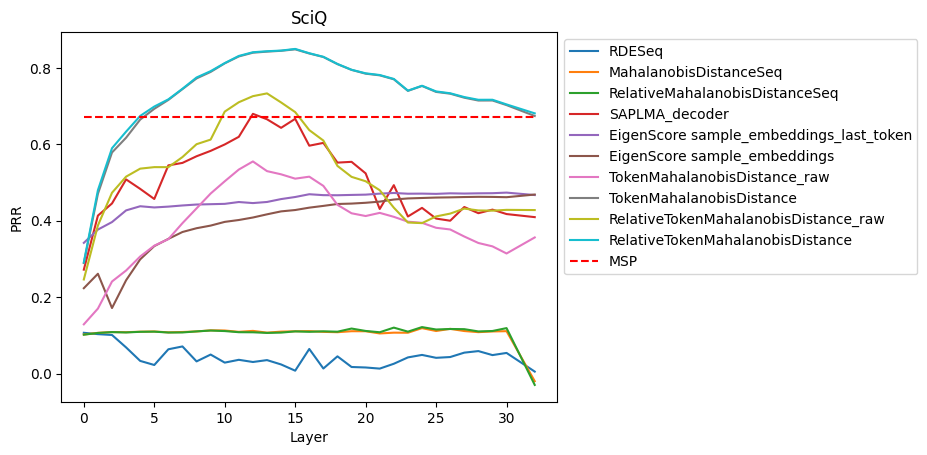

In [42]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    if "Mahalanobis" in name and "Relative" not in name:
        return (name in col) and (suf in col) and ("Relative" not in col)
    if "last_token" not in name:
        return (name in col) and (suf in col) and ("last_token" not in col)
    return (name in col) and (suf in col)
    
names = ["RDESeq", "MahalanobisDistanceSeq", "RelativeMahalanobisDistanceSeq", "SAPLMA_decoder", "EigenScore sample_embeddings_last_token", "EigenScore sample_embeddings", "TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]
for name in names:
    if "TokenMahalanobis" in name:
        thrs = [0.0, 0.3]
    else:
        thrs = [0.3]
    for thr in thrs:
        if "SAPLMA_decoder" in name:
            cols = [x for x in df0.columns if check_cond(x, name, "cv, Accuracy")]
        elif ("SAPLMA_truefalse" in name) or ("Token" not in name):
            cols = [x for x in df0.columns if check_cond(x, name, "")]
        else:
            if thr == 0:
                cols = [x for x in df0.columns if check_cond(x, name, f"(mean, , {thr})")]
            else:
                cols = [x for x in df0.columns if check_cond(x, name, f"(mean, Accuracy, {thr})")]
        layers = []
        for x in cols:
            try:
                layers.append(int(x.split("_")[-1].split(" ")[0]))
            except:
                layers.append(len(layers)+1)
        if thr == 0:
            plt.plot(layers, df0[cols].values[0], label=name+"_raw")
        else:
            plt.plot(layers, df0[cols].values[0], label=name)
    
# for c in df0.columns:
#     if "LinReg" not in c:
#         continue
#     if ("HUQ" not in c) and ("Hybrid" not in c):
#         continue
#     if "Accuracy" not in c:
#         continue

#     if "HUQ" in c:
#         label = "HUQ-LinRegTMD"
#     elif "Hybrid" in c:
#         label = "LinRegMSP+TMD"
#     else:
#         label = "LinReg"
        
#     if "relative" in c.lower():
#         label += " Rel."
#     if "remove_corr_3" not in c:
#         continue   
#     #label += f" {metric}"  
#     plt.plot(layers, [df0[c].iloc[0]]*len(layers), label=label)

# for c in df0.columns:
#     if "Factoscope" not in c:
#         continue
#     if "Accuracy" not in c:
#         continue
#     label = c 
#     plt.plot(layers, [df0[c].iloc[0]]*len(layers), label=label)

plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), "r--", label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.title("SciQ")
plt.legend(bbox_to_anchor=(1, 1))

/tmp/ipykernel_5376/329511553.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), "r--", label="MSP")


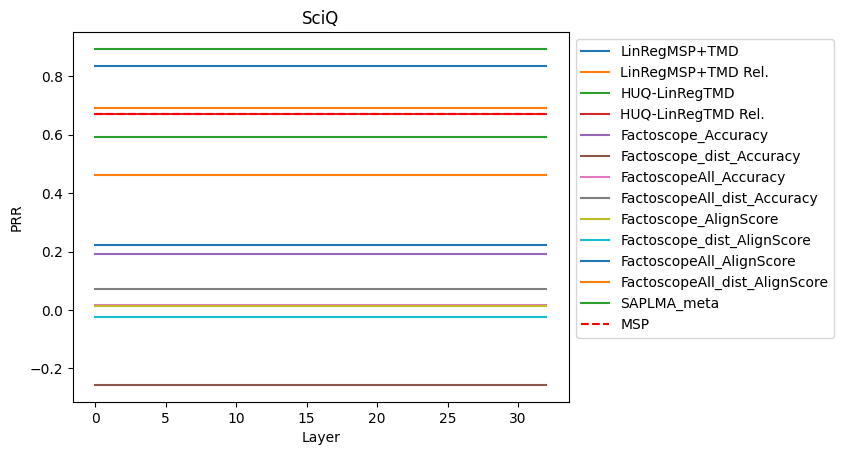

In [43]:
import matplotlib.pyplot as plt

col_to_use = ['MaximumSequenceProbability']
for i, c in enumerate(df0.columns):
    if "LinReg" not in c:
        continue
    if ("HUQ" not in c) and ("Hybrid" not in c):
        continue
    if "Accuracy" not in c:
        continue

    if "HUQ" in c:
        label = "HUQ-LinRegTMD"
    elif "Hybrid" in c:
        label = "LinRegMSP+TMD"
    else:
        label = "LinReg"
        
    if "relative" in c.lower():
        label += " Rel."
    if "remove_corr_3" not in c:
        continue   
    col_to_use.append(c)
    plt.plot(layers, [df0[c].iloc[0]]*len(layers), label=label)

for i, c in enumerate(df0.columns):
    if "Factoscope" not in c:
        continue
    # if "Accuracy" not in c:
    #     continue
    label = c 
    col_to_use.append(c)
    plt.plot(layers, [df0[c].iloc[0]]*len(layers), label=label)

for i, c in enumerate(df0.columns):
    if "SAPLMA_meta_decoder" not in c:
        continue
    if "Accuracy" not in c:
        continue
    label = "SAPLMA_meta"
    col_to_use.append(c)
    plt.plot(layers, [df0[c].iloc[0]]*len(layers), label=label)

plt.plot(layers, [df0['MaximumSequenceProbability'][0]]*len(layers), "r--", label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.title("SciQ")
plt.legend(bbox_to_anchor=(1, 1))

In [56]:
df1 = df0[col_to_use].T
idx = df1.index
new_idx = []
for i in idx:
    if "MaximumSequenceProbability" in i:
        new_idx.append(i)
    if "HybridLinRegToken" in i:
        new_idx.append("LinRegMSP+TMD")
    if "HybridLinRegRelative" in i:
        new_idx.append("LinRegMSP+TRMD")
    if "HUQ-LinRegRelative" in i:
        new_idx.append("HUQ-RTMD")
    if "HUQ-LinRegToken" in i:
        new_idx.append("HUQ-TMD")
    if "SAPLMA_meta" in i:
        new_idx.append("SAPLMA_meta")
    if "Factoscope" in i:
        new_idx.append(i)
df1.index = new_idx

In [59]:
df1.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

In [12]:
#path = "../workdir/output/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-04/09-12-59/ue_manager_seed1"
path = "../workdir/output/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-05/13-17-07/ue_manager_seed1"
# path = "../workdir/output_layers_saplma/qa/google/gemma-7b/sciq/2024-08-22/19-28-15/ue_manager_seed1"
# path = "../workdir/output_layers_saplma/qa/google/gemma-7b/sciq/2024-08-22/19-42-20/ue_manager_seed1"
# path = "../workdir/output_layers_5/qa/google/gemma-7b/sciq/2024-08-23/16-31-58/ue_manager_seed1"

path = "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-23/19-21-13/ue_manager_seed1"
path = "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-23/22-55-18/ue_manager_seed1"
path = "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-25/01-23-34/ue_manager_seed1"
path = "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/bigbio/pubmed_qa/2024-08-25/16-58-06/ue_manager_seed1"
# path = "../workdir/output_layers_saplma/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-25/04-18-43/ue_manager_seed1"
# path = "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-24/13-04-28/ue_manager_seed1"
# path = "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-24/03-29-47/ue_manager_seed1"
# path = "../workdir/output_layers_saplma/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-25/04-18-43/ue_manager_seed1"
# path = "../workdir/output_layers_saplma/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-08-27/12-44-46/ue_manager_seed1"
#path = "../workdir/output_layers_saplma/nmt/meta-llama/Meta-Llama-3-8B/['wmt14', 'de-en']/2024-08-26/07-27-11/ue_manager_seed1"
#path = "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-27/00-58-52/ue_manager_seed1"
path = "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/keivalya/MedQuad-MedicalQnADataset/2024-08-28/04-10-38/ue_manager_seed1"

# path = "../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-24/21-12-15/ue_manager_seed1"
# path = "../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-24/13-04-30/ue_manager_seed1"
# path = "../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-25/11-15-22/ue_manager_seed1"
# path = "../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-26/23-22-34/ue_manager_seed1"
# path = "../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-26/17-51-44/ue_manager_seed1"
# path = "../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-27/03-16-47/ue_manager_seed1"
#path = "../workdir/output_layers_saplma_ds/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-27/15-14-53/ue_manager_seed1"

# path = "../workdir/output_layers_6/ats/google/gemma-7b/samsum/2024-08-27/16-04-53/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Rouge_rougeL', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_322004/1944692688.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [177]:
np.mean(man['gen_metrics'][('sequence', 'Accuracy')])

0.537

In [260]:
path = ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-27/03-16-47/ue_manager_seed1",
        "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-25/01-23-34/ue_manager_seed1"]

dfs = []
for p in path:
    man = torch.load(p)
    
    metric_names = ['Accuracy']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    dfs.append(pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names]))
    
df = pd.concat([df if i==0 else df[df.columns[5:]] for i, df in enumerate(dfs)], axis=1)
df = df[list(df.columns[~df.columns.duplicated(keep=False)])]

/tmp/ipykernel_298440/4010219423.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(p)


In [191]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    if "Relative" not in name:
        return (name in col) and (suf in col) and ("Relative" not in col)
    return (name in col) and (suf in col)
    
names = ["SAPLMA_truefalse", "SAPLMA_decoder", "TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]
for name in names:
    if "SAPLMA_decoder" in name:
        cols = [x for x in df.columns if check_cond(x, name, "cv, Accuracy")]
    elif "SAPLMA_truefalse" in name:
        cols = [x for x in df.columns if check_cond(x, name, "")]
    else:
        cols = [x for x in df.columns if check_cond(x, name)]
    layers = [int(x.split("_")[-1].split(" ")[0]) if "decoder" not in x.split("_")[-1] else 31 for x in cols]
    
    plt.plot(layers, df[cols].values[0], label=name)
plt.plot(layers, [df['MaximumSequenceProbability'][0]]*len(layers), "r--", label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.title("MMLU")
plt.legend()

AttributeError: 'dict' object has no attribute 'columns'

In [225]:
path = ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-24/21-12-15/ue_manager_seed1",
        "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-23/22-55-18/ue_manager_seed1"]

dfs = []
for p in path:
    man = torch.load(p)
    
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    dfs.append(pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names]))
    
df = pd.concat([df if i==0 else df[df.columns[5:]] for i, df in enumerate(dfs)], axis=1)
df = df[list(df.columns[~df.columns.duplicated(keep=False)])]

/tmp/ipykernel_298440/794937451.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(p)


/tmp/ipykernel_298440/1667645670.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df['MaximumSequenceProbability'][1]]*len(layers), "r--", label="MSP")


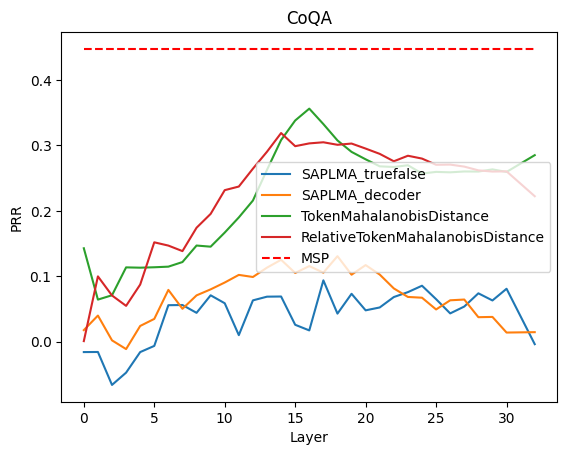

In [228]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, AlignScore, 0.3)"):
    if "Relative" not in name:
        return (name in col) and (suf in col) and ("Relative" not in col)
    return (name in col) and (suf in col)
    
names = ["SAPLMA_truefalse", "SAPLMA_decoder", "TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]
for name in names:
    if "SAPLMA_decoder" in name:
        cols = [x for x in df.columns if check_cond(x, name, "cv, AlignScore")]
    elif "SAPLMA_truefalse" in name:
        cols = [x for x in df.columns if check_cond(x, name, "")]
    else:
        cols = [x for x in df.columns if check_cond(x, name)]
    layers = [int(x.split("_")[-1].split(" ")[0]) if "decoder" not in x.split("_")[-1] else 32 for x in cols]
    
    plt.plot(layers, df[cols].values[1], label=name)
plt.plot(layers, [df['MaximumSequenceProbability'][1]]*len(layers), "r--", label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.title("CoQA")
plt.legend()

In [232]:
path = ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-24/13-04-30/ue_manager_seed1",
        "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-23/19-21-13/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-17/00-46-31/ue_manager_seed1"]

dfs = []
for p in path:
    man = torch.load(p)
    
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    dfs.append(pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names]))
    
df = pd.concat([df if i==0 else df[df.columns[5:]] for i, df in enumerate(dfs[:2])] + [dfs[-1][dfs[-1].columns[-12:]]], axis=1)
df = df[list(df.columns[~df.columns.duplicated(keep=False)])]

/tmp/ipykernel_298440/3576618629.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(p)


/tmp/ipykernel_298440/2058714089.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df['MaximumSequenceProbability'][1]]*len(layers), "r--", label="MSP")


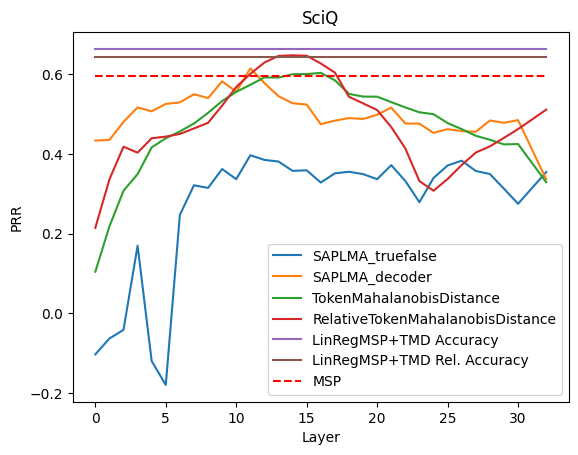

In [233]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, AlignScore, 0.3)"):
    if "Relative" not in name:
        return (name in col) and (suf in col) and ("Relative" not in col)
    return (name in col) and (suf in col)
    
names = ["SAPLMA_truefalse", "SAPLMA_decoder", "TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]
for name in names:
    if "SAPLMA_decoder" in name:
        cols = [x for x in df.columns if check_cond(x, name, "cv, AlignScore")]
    elif "SAPLMA_truefalse" in name:
        cols = [x for x in df.columns if check_cond(x, name, "")]
    else:
        cols = [x for x in df.columns if check_cond(x, name)]
    layers = [int(x.split("_")[-1].split(" ")[0]) if "decoder" not in x.split("_")[-1] else 32 for x in cols]
    
    plt.plot(layers, df[cols].values[1], label=name)
    
for c in df.columns:
    if "HybridLinReg" not in c:
        continue
    if "AlignScore" not in c:
        continue

    if "HUQ" in c:
        label = "HUQ-LinRegTMD"
    elif "Hybrid" in c:
        label = "LinRegMSP+TMD"
    else:
        label = "LinReg"
        
    if "relative" in c.lower():
        label += " Rel."
    if "remove_corr_3" not in c:
        continue   
    label += f" {metric}"  
    plt.plot(layers, [df[c].iloc[1]]*len(layers), label=label)
    
plt.plot(layers, [df['MaximumSequenceProbability'][1]]*len(layers), "r--", label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.title("SciQ")
plt.legend()

In [234]:
path = ["../workdir/output_layers_saplma/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-25/04-18-43/ue_manager_seed1",
        "../workdir/output_layers_saplma_ds/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-27/15-14-53/ue_manager_seed1",
        "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-18/05-34-35/ue_manager_seed1",]

dfs = []
for p in path:
    man = torch.load(p)
    
    metric_names = ["AlignScore"]#['Accuracy']# 'AlignScore'
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    dfs.append(pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names]))
    
df = pd.concat([df if i==0 else df[df.columns[5:]] for i, df in enumerate(dfs[:2])] + [dfs[-1][dfs[-1].columns[-12:]]], axis=1)
df = df[list(df.columns[~df.columns.duplicated(keep=False)])]

/tmp/ipykernel_298440/4053997220.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(p)


/tmp/ipykernel_298440/83962847.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df['MaximumSequenceProbability'][0]]*len(layers), "r--", label="MSP")


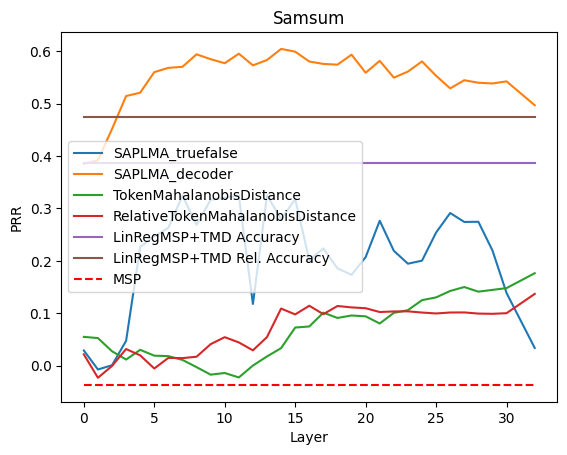

In [237]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, AlignScore, 0.3)"):
    if "Relative" not in name:
        return (name in col) and (suf in col) and ("Relative" not in col)
    return (name in col) and (suf in col)
    
names = ["SAPLMA_truefalse", "SAPLMA_decoder", "TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]
for name in names:
    if "SAPLMA_decoder" in name:
        cols = [x for x in df.columns if check_cond(x, name, "cv, AlignScore")]
    elif "SAPLMA_truefalse" in name:
        cols = [x for x in df.columns if check_cond(x, name, "")]
    else:
        cols = [x for x in df.columns if check_cond(x, name)]
    layers = [int(x.split("_")[-1].split(" ")[0]) if "decoder" not in x.split("_")[-1] else 32 for x in cols]
    
    plt.plot(layers, df[cols].values[0], label=name)
    
for c in df.columns:
    if "HybridLinReg" not in c:
        continue
    if "AlignScore" not in c:
        continue

    if "HUQ" in c:
        label = "HUQ-LinRegTMD"
    elif "Hybrid" in c:
        label = "LinRegMSP+TMD"
    else:
        label = "LinReg"
        
    if "relative" in c.lower():
        label += " Rel."
    if "remove_corr_3" not in c:
        continue   
    label += f" {metric}"  
    plt.plot(layers, [df[c].iloc[0]]*len(layers), label=label)

plt.plot(layers, [df['MaximumSequenceProbability'][0]]*len(layers), "r--", label="MSP")
plt.xlabel("Layer")
plt.ylabel("PRR")
plt.title("Samsum")
plt.legend()

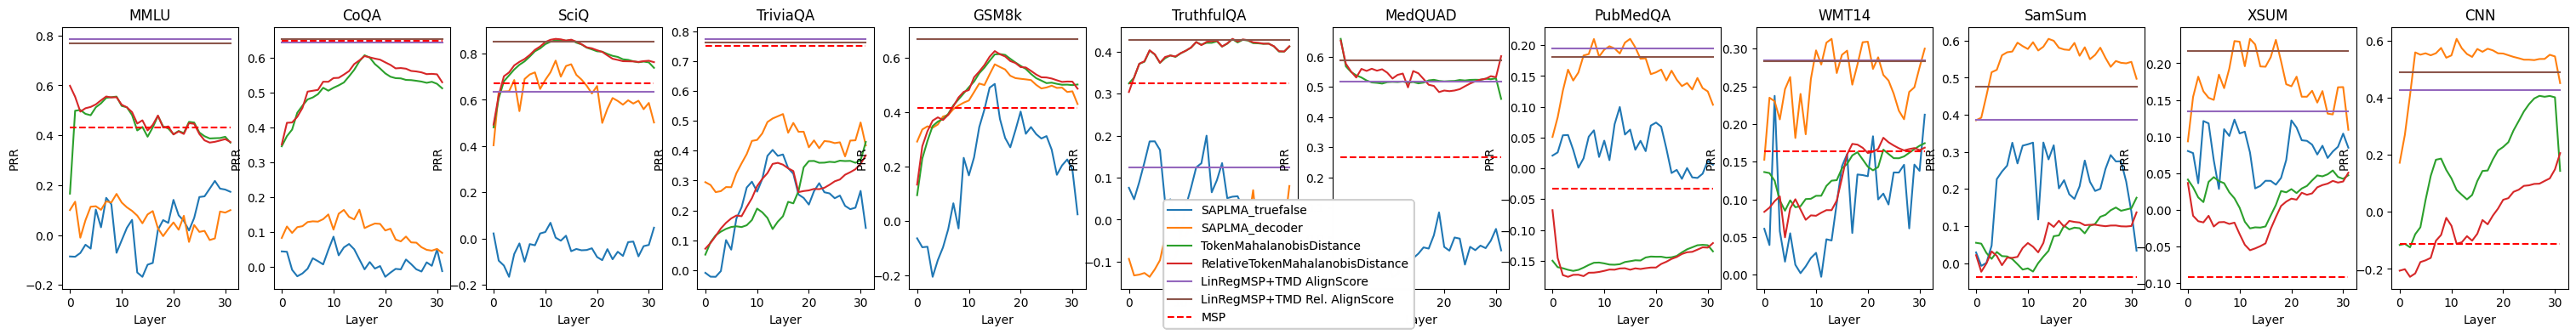

In [32]:
import matplotlib.pyplot as plt


paths = [
   
    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-27/03-16-47/ue_manager_seed1",
        "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-25/01-23-34/ue_manager_seed1",
    "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-17/23-22-40/ue_manager_seed1"],

    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-24/21-12-15/ue_manager_seed1",
        "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-23/22-55-18/ue_manager_seed1",
     "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-17/05-30-16/ue_manager_seed1"],
    
    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-24/13-04-30/ue_manager_seed1",
        "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-23/19-21-13/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-17/00-46-31/ue_manager_seed1"],

    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-25/11-15-22/ue_manager_seed1",
    "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-24/03-29-47/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-17/13-38-44/ue_manager_seed1"],

    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-26/17-51-44/ue_manager_seed1",
     "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-27/00-58-52/ue_manager_seed1",
    "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-11/02-18-35/ue_manager_seed1"],

    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-26/23-22-34/ue_manager_seed1",
    "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-24/13-04-28/ue_manager_seed1",
    "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-17/21-27-43/ue_manager_seed1"],

    ["../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/keivalya/MedQuad-MedicalQnADataset/2024-08-28/04-10-38/ue_manager_seed1",
    "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/keivalya/MedQuad-MedicalQnADataset/2024-08-11/16-34-44/ue_manager_seed1"],

    ["../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/bigbio/pubmed_qa/2024-08-25/16-58-06/ue_manager_seed1",
    "../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/bigbio/pubmed_qa/2024-08-29/09-59-34/ue_manager_seed1",
     "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/bigbio/pubmed_qa/2024-08-23/07-04-09/ue_manager_seed1"],

    ["../workdir/output_layers_saplma/nmt/meta-llama/Meta-Llama-3-8B/['wmt14', 'de-en']/2024-08-26/07-27-11/ue_manager_seed1",
    "../workdir/output_layers_saplma_ds/nmt/meta-llama/Meta-Llama-3-8B/['wmt14', 'de-en']/2024-08-27/16-20-33/ue_manager_seed1",
    "../workdir/output_layers_3/nmt/meta-llama/Meta-Llama-3-8B/['wmt14', 'de-en']/2024-08-23/22-52-33/ue_manager_seed1"],
    
    ["../workdir/output_layers_saplma/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-25/04-18-43/ue_manager_seed1",
        "../workdir/output_layers_saplma_ds/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-27/15-14-53/ue_manager_seed1",
        "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-18/05-34-35/ue_manager_seed1",],
    
    ["../workdir/output_layers_saplma/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-08-27/12-44-46/ue_manager_seed1",
     "../workdir/output_layers_saplma_ds/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-08-27/12-56-41/ue_manager_seed1",
    "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-08-11/16-34-45/ue_manager_seed1"],

    ["../workdir/output_layers_saplma_ds/ats/meta-llama/Meta-Llama-3-8B/['cnn_dailymail', '3.0.0']/2024-08-29/10-05-19/ue_manager_seed1",
     "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/['cnn_dailymail', '3.0.0']/2024-08-24/17-55-46/ue_manager_seed1"]
]

ds = ["MMLU", "CoQA", 'SciQ', "TriviaQA", "GSM8k", "TruthfulQA", "MedQUAD", "PubMedQA", "WMT14", "SamSum", "XSUM", "CNN"]

fig, ax = plt.subplots(nrows=1, ncols=len(ds), figsize=(38, 4))

for k, (d_name, path) in enumerate(zip(ds, paths)):
    dfs = []
    for p in path:
        man = torch.load(p, weights_only=False)
        metric = "Accuracy" if d_name in ["MMLU", "CoQA", 'SciQ', "GSM8k", "TriviaQA", "TruthfulQA"] else "AlignScore"
        metric_names = [metric]
        df = {}
        for key in man['metrics'].keys():
            if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
                scores = df.get(key[1], [])
                scores.append(man["metrics"][key])
                df[key[1]] = scores
                
        dfs.append(pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names]))

    if len(dfs) > 2:
        df = pd.concat([df if i==0 else df[df.columns[5:]] for i, df in enumerate(dfs[:2])] + [dfs[-1][dfs[-1].columns[-12:]]], axis=1)
    else:
        df = pd.concat([df if i==0 else df[df.columns[5:]] for i, df in enumerate(dfs)], axis=1)
    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    #df = df[list(df.columns[~df.columns.duplicated(keep=False)])]

    def check_cond(col, name="TokenMahalanobisDistance_decoder", suf=f"(mean, {metric}, 0.3)"):
        if "Relative" not in name:
            return (name in col) and (suf in col) and ("Relative" not in col)
        return (name in col) and (suf in col)
        
    names = ["SAPLMA_truefalse", "SAPLMA_decoder", "TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]
    for name in names:
        if "SAPLMA_decoder" in name:
            cols = [x for x in df.columns if check_cond(x, name, f"cv, {metric}")]
        elif "SAPLMA_truefalse" in name:
            cols = [x for x in df.columns if check_cond(x, name, "")]
        else:
            cols = [x for x in df.columns if check_cond(x, name)]
        layers = [int(x.split("_")[-1].split(" ")[0]) if "decoder" not in x.split("_")[-1] else 31 for x in cols]
        
        ax[k].plot(layers, df[cols].values[0], label=name)
        
    for c in df.columns:
        if "HybridLinReg" not in c:
            continue
        if metric not in c:
            continue
    
        if "HUQ" in c:
            label = "HUQ-LinRegTMD"
        elif "Hybrid" in c:
            label = "LinRegMSP+TMD"
        else:
            label = "LinReg"
            
        if "relative" in c.lower():
            label += " Rel."
        if "remove_corr_3" not in c:
            continue   
        label += f" {metric}"  
        ax[k].plot(layers, [df[c].iloc[0]]*len(layers), label=label)
    
    ax[k].plot(layers, [df['MaximumSequenceProbability'].iloc[0]]*len(layers), "r--", label="MSP")
    ax[k].set_xlabel("Layer")
    ax[k].set_ylabel("PRR")
    ax[k].set_title(d_name)
    handles, labels = ax[k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')

In [58]:
import matplotlib.pyplot as plt


paths = [
   
    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-27/03-16-47/ue_manager_seed1",
        "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-25/01-23-34/ue_manager_seed1",
    "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-17/23-22-40/ue_manager_seed1",
    "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-31/18-17-22/ue_manager_seed1"],

    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-24/21-12-15/ue_manager_seed1",
        "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-23/22-55-18/ue_manager_seed1",
     "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-17/05-30-16/ue_manager_seed1",
     "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-31/04-11-37/ue_manager_seed1"],
    
    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-24/13-04-30/ue_manager_seed1",
        "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-23/19-21-13/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-17/00-46-31/ue_manager_seed1",
       "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-30/19-03-41/ue_manager_seed1"],

    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-25/11-15-22/ue_manager_seed1",
    "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-24/03-29-47/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-17/13-38-44/ue_manager_seed1",
     "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-31/12-16-38/ue_manager_seed1"],

    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-26/17-51-44/ue_manager_seed1",
     "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-27/00-58-52/ue_manager_seed1",
    "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-11/02-18-35/ue_manager_seed1",
     "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-30/19-03-39/ue_manager_seed1"],

    ["../workdir/output_layers_saplma_ds/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-26/23-22-34/ue_manager_seed1",
    "../workdir/output_layers_saplma/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-24/13-04-28/ue_manager_seed1",
    "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-17/21-27-43/ue_manager_seed1",
    "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-31/16-56-18/ue_manager_seed1"],
    
    ["../workdir/output_layers_saplma/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-25/04-18-43/ue_manager_seed1",
        "../workdir/output_layers_saplma_ds/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-27/15-14-53/ue_manager_seed1",
        "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-18/05-34-35/ue_manager_seed1",
    "../workdir/output_layers_internal/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-30/19-03-34/ue_manager_seed1"],
]

ds = ["MMLU", "CoQA", 'SciQ', "TriviaQA", "GSM8k", "TruthfulQA", "SamSum"]

fig, ax = plt.subplots(nrows=1, ncols=len(ds), figsize=(24, 4))

for k, (d_name, path) in enumerate(zip(ds, paths)):
    dfs = []
    for p in path[:3]:
        man = torch.load(p, weights_only=False)
        metric = "Accuracy" if d_name in ["MMLU", "CoQA", 'SciQ', "GSM8k", "TriviaQA", "TruthfulQA"] else "AlignScore"
        metric_names = [metric]
        df = {}
        for key in man['metrics'].keys():
            if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
                scores = df.get(key[1], [])
                scores.append(man["metrics"][key])
                df[key[1]] = scores
                
        dfs.append(pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names]))

    if len(dfs) > 2:
        df = pd.concat([df if i==0 else df[df.columns[5:]] for i, df in enumerate(dfs[:2])] + [dfs[-1][dfs[-1].columns[-12:]]], axis=1)
    else:
        df = pd.concat([df if i==0 else df[df.columns[5:]] for i, df in enumerate(dfs)], axis=1)
    df = df.loc[:, ~df.columns.duplicated(keep="first")]

    if len(path) > 3:
        man = torch.load(path[-1], weights_only=False)
        metric = "Accuracy" if d_name in ["MMLU", "CoQA", 'SciQ', "GSM8k", "TriviaQA", "TruthfulQA"] else "AlignScore"
        metric_names = [metric]
        df_int = {}
        for key in man['metrics'].keys():
            if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
                if "fact" in key[1].lower() or "eigen" in key[1].lower():
                    scores = df_int.get(key[1], [])
                    scores.append(man["metrics"][key])
                    df_int[key[1]] = scores
        df_int = pd.DataFrame(df_int, index=[f'{d_name}, {m}, PRR' for m in metric_names])
        df = pd.concat([df, df_int], axis=1)
                
    #df = df[list(df.columns[~df.columns.duplicated(keep=False)])]

    def check_cond(col, name="TokenMahalanobisDistance_decoder", suf=f"(mean, {metric}, 0.3)"):
        if "Relative" not in name:
            return (name in col) and (suf in col) and ("Relative" not in col)
        return (name in col) and (suf in col)
        
    names = ["SAPLMA_truefalse", "SAPLMA_decoder", "TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]
    for name in names:
        if "SAPLMA_decoder" in name:
            cols = [x for x in df.columns if check_cond(x, name, f"cv, {metric}")]
        elif "SAPLMA_truefalse" in name:
            cols = [x for x in df.columns if check_cond(x, name, "")]
        else:
            cols = [x for x in df.columns if check_cond(x, name)]
        layers = [int(x.split("_")[-1].split(" ")[0]) if "decoder" not in x.split("_")[-1] else 31 for x in cols]
        
        ax[k].plot(layers, df[cols].values[0], label=name)
        
    for c in df.columns:
        if "HybridLinReg" not in c:
            continue
        if metric not in c:
            continue
    
        if "HUQ" in c:
            label = "HUQ-LinRegTMD"
        elif "Hybrid" in c:
            label = "LinRegMSP+TMD"
        else:
            label = "LinReg"
            
        if "relative" in c.lower():
            label += " Rel."
        if "remove_corr_3" not in c:
            continue   
        label += f" {metric}"  
        ax[k].plot(layers, [df[c].iloc[0]]*len(layers), label=label)
        
    for c in df.columns:
        if ("Fact" not in c) and ("Eigen" not in c):
            continue
        label = c
        ax[k].plot(layers, [df[c].iloc[0]]*len(layers), label=label)
    
    ax[k].plot(layers, [df['MaximumSequenceProbability'].iloc[0]]*len(layers), "r--", label="MSP")
    ax[k].set_xlabel("Layer")
    ax[k].set_ylabel("PRR")
    ax[k].set_title(d_name)
    handles, labels = ax[k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')

In [80]:
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-02/18-42-09/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-09-04/04-41-36/ue_manager_seed1"
# path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-09-04/00-05-18/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_559276/2122520020.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [55]:
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-09-03/21-25-45/ue_manager_seed1"
path = "../workdir/output_layers_internal/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-09-04/04-41-36/ue_manager_seed1"

man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man["metrics"][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'SciQ, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"SciQ, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_559276/4140543125.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


# Average

In [3]:
import matplotlib.pyplot as plt


paths_g = [
    "../workdir/output/qa/google/gemma-7b/sciq/2024-07-03/22-16-46/ue_manager_seed1",
    "../workdir/output/qa/google/gemma-7b/coqa/2024-07-03/18-32-21/ue_manager_seed1",
    "../workdir/output/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-04/01-41-50/ue_manager_seed1",
    "../workdir/output/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-04/09-12-59/ue_manager_seed1",
    "../workdir/output/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-03/18-32-16/ue_manager_seed1",
    "../workdir/output/qa/{'path': 'google/gemma-7b', 'ensemble': False, 'mc': False, 'mc_seeds': None, 'dropout_rate': None, 'device_map': 'auto', 'attn_implementation': 'eager'}/['cais/mmlu', 'all']/2024-07-04/00-23-51/ue_manager_seed1",
    "../workdir/output/ats/google/gemma-7b/xsum/2024-07-03/18-32-16/ue_manager_seed1",
]

paths_l = [
    "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-03/15-43-35/ue_manager_seed1",
    "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-07-04/11-11-14/ue_manager_seed1",
    "",
    "",
    "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-07-04/04-09-02/ue_manager_seed1",    
    "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-07-04/10-30-58/ue_manager_seed1",
    "../workdir/output/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-07-04/04-09-02/ue_manager_seed1"
]
ds = ['SciQ', "CoQA", "TriviaQA", "TruthfulQA", "GSM8k", "MMLU", "XSum"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 8))

for k, (d_name, path) in enumerate(zip(ds, paths_g)):
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name == "SciQ":
        suf = "(mean, Accuracy, 0.3)"
        i = 0
    elif d_name == "XSum":
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 30 for x in cols]
        
        ax[0, k].plot(layers, df0[cols].values[i], label=name)
        
    ax[0, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")
    ax[0, k].set_xlabel("Layer")
    ax[0, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[0, k].set_title(d_name)
    handles, labels = ax[0, k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')

for k, (d_name, path) in enumerate(zip(ds, paths_l)):
    if not len(path):
        continue
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name == "SciQ":
        suf = "(mean, accuracy, 0.5)"
        i = 0
    elif d_name == "XSum":
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]
        
        ax[1, k].plot(layers, df0[cols].values[i], label=name)
        
    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")
    ax[1, k].set_xlabel("Layer")
    ax[1, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[1, k].set_title(d_name)
    #handles, labels = ax[1, k].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center')

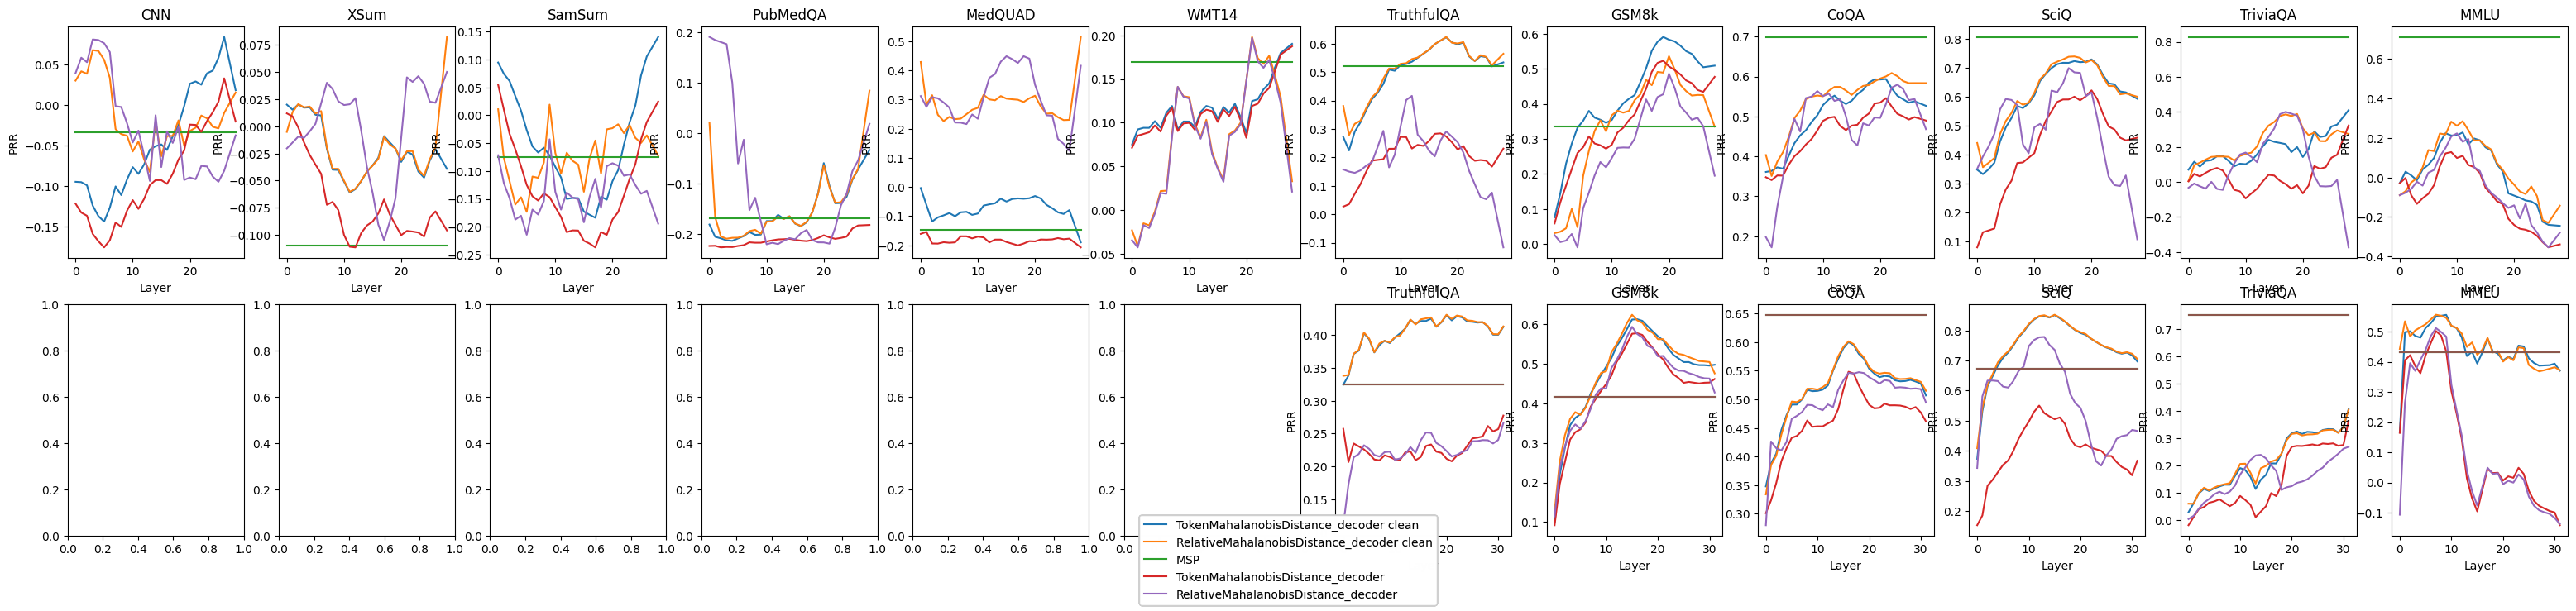

In [798]:
import matplotlib.pyplot as plt


paths_g = [
    "../workdir/output_layers/ats/google/gemma-7b/['cnn_dailymail', '3.0.0']/2024-07-07/11-41-26/ue_manager_seed1",
    "../workdir/output_layers/ats/google/gemma-7b/xsum/2024-07-06/11-31-14/ue_manager_seed1",
    "../workdir/output_layers/ats/google/gemma-7b/samsum/2024-07-08/12-16-27/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/bigbio/pubmed_qa/2024-07-08/12-16-27/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-07-06/22-55-47/ue_manager_seed1",
    "../workdir/output_layers/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-07-06/22-55-47/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-08/01-42-11/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-06/11-31-14/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-07-05/17-04-45/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/sciq/2024-07-06/07-38-03/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-06/14-26-48/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-07-08/05-16-14/ue_manager_seed1"
]

paths_l = [
    "",
    "",
    "",
    "",
    "",
    "",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-07-11/05-58-43/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-07-07/22-06-40/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-07-08/16-59-16/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-11/10-38-50/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-07-09/12-59-17/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-07-11/19-17-27/ue_manager_seed1",
]

ds = ["CNN", "XSum", "SamSum", "PubMedQA", "MedQUAD", "WMT14", "TruthfulQA", "GSM8k", "CoQA", 'SciQ', "TriviaQA", "MMLU"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=2, ncols=12, figsize=(39, 8))

for k, (d_name, path) in enumerate(zip(ds, paths_g)):
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf = "(mean, Accuracy, 0.3)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]    
        ax[0, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[0, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")


    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, , 0)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, , 0)"
        i = 1
    else:
        suf = "(mean, , 0)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]
        ax[0, k].plot(layers, df0[cols].values[i], label=name)
        
    ax[0, k].set_xlabel("Layer")
    ax[0, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[0, k].set_title(d_name)
    handles, labels = ax[0, k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')

for k, (d_name, path) in enumerate(zip(ds, paths_l)):
    if not len(path):
        continue
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, Accuracy, 0.3)"
        i = 0
    else:
        suf = "(mean, Accuracy, 0.3)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in cols]    
        ax[1, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")


    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, , 0)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, , 0)"
        i = 0
    else:
        suf = "(mean, , 0)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in cols]
        ax[1, k].plot(layers, df0[cols].values[i], label=name)
        
    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")
    ax[1, k].set_xlabel("Layer")
    ax[1, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[1, k].set_title(d_name)
    #handles, labels = ax[1, k].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center')

In [1231]:
import matplotlib.pyplot as plt


paths_g = [
    "../workdir/output_layers_2/ats/google/gemma-7b/['cnn_dailymail', '3.0.0']/2024-07-20/14-52-35/ue_manager_seed1",
    "../workdir/output_layers_2/ats/google/gemma-7b/xsum/2024-07-19/10-28-33/ue_manager_seed1",
    "../workdir/output_layers_2/ats/google/gemma-7b/samsum/2024-07-20/14-52-34/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/bigbio/pubmed_qa/2024-07-21/03-41-01/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-07-19/23-55-48/ue_manager_seed1",
    "../workdir/output_layers_2/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-07-19/23-55-48/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-20/18-09-09/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-19/10-28-33/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/coqa/2024-07-19/10-28-38/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-07-19/20-55-43/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-20/01-17-01/ue_manager_seed1",
    "../workdir/output_layers_2/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-07-20/20-46-43/ue_manager_seed1"
]

paths_l = [
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
]

ds = ["CNN", "XSum", "SamSum", "PubMedQA", "MedQUAD", "WMT14", "TruthfulQA", "GSM8k", "CoQA", 'SciQ', "TriviaQA", "MMLU"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=2, ncols=12, figsize=(39, 8))

for k, (d_name, path) in enumerate(zip(ds, paths_g)):
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf = "(mean, Accuracy, 0.3)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]    
        ax[0, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[0, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP", linestyle="--", color="r", linewidth=2)


    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, , 0)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, , 0)"
        i = 1
    else:
        suf = "(mean, , 0)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]
        ax[0, k].plot(layers, df0[cols].values[i], label=name)

    for c in df0.columns:
        if "LinReg" not in c:
            continue
        label = "LinReg"
    
        if "relative" in c.lower():
            label += " Rel."
        
        if "unnorm" in c:
            label += " unnorm."
        elif "norm" in c:
            label += " norm."
        elif "orig" in c:
            label += " orig."
            
        if "Accuracy, Accuracy" in c:
            label += " Acc"
        if "AlignScore, AlignScore" in c:
            label += " AlS"        
        ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
            
    ax[0, k].set_xlabel("Layer")
    ax[0, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[0, k].set_title(d_name)
    handles, labels = ax[0, k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')

for k, (d_name, path) in enumerate(zip(ds, paths_l)):
    if not len(path):
        continue
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, Accuracy, 0.3)"
        i = 0
    else:
        suf = "(mean, Accuracy, 0.3)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in cols]    
        ax[1, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")


    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, , 0)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, , 0)"
        i = 0
    else:
        suf = "(mean, , 0)"
        #suf="(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in cols]
        ax[1, k].plot(layers, df0[cols].values[i], label=name)
        
    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP")
    ax[1, k].set_xlabel("Layer")
    ax[1, k].set_ylabel("PRR")
    #ax[0, k].legend()
    ax[1, k].set_title(d_name)
    #handles, labels = ax[1, k].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center')

/tmp/ipykernel_450/1147347277.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
/tmp/ipykernel_450/1147347277.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
/tmp/ipykernel_450/1147347277.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
/tmp

/tmp/ipykernel_313746/1121971049.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
/tmp/ipykernel_313746/1121971049.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
/tmp/ipykernel_313746/1121971049.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label

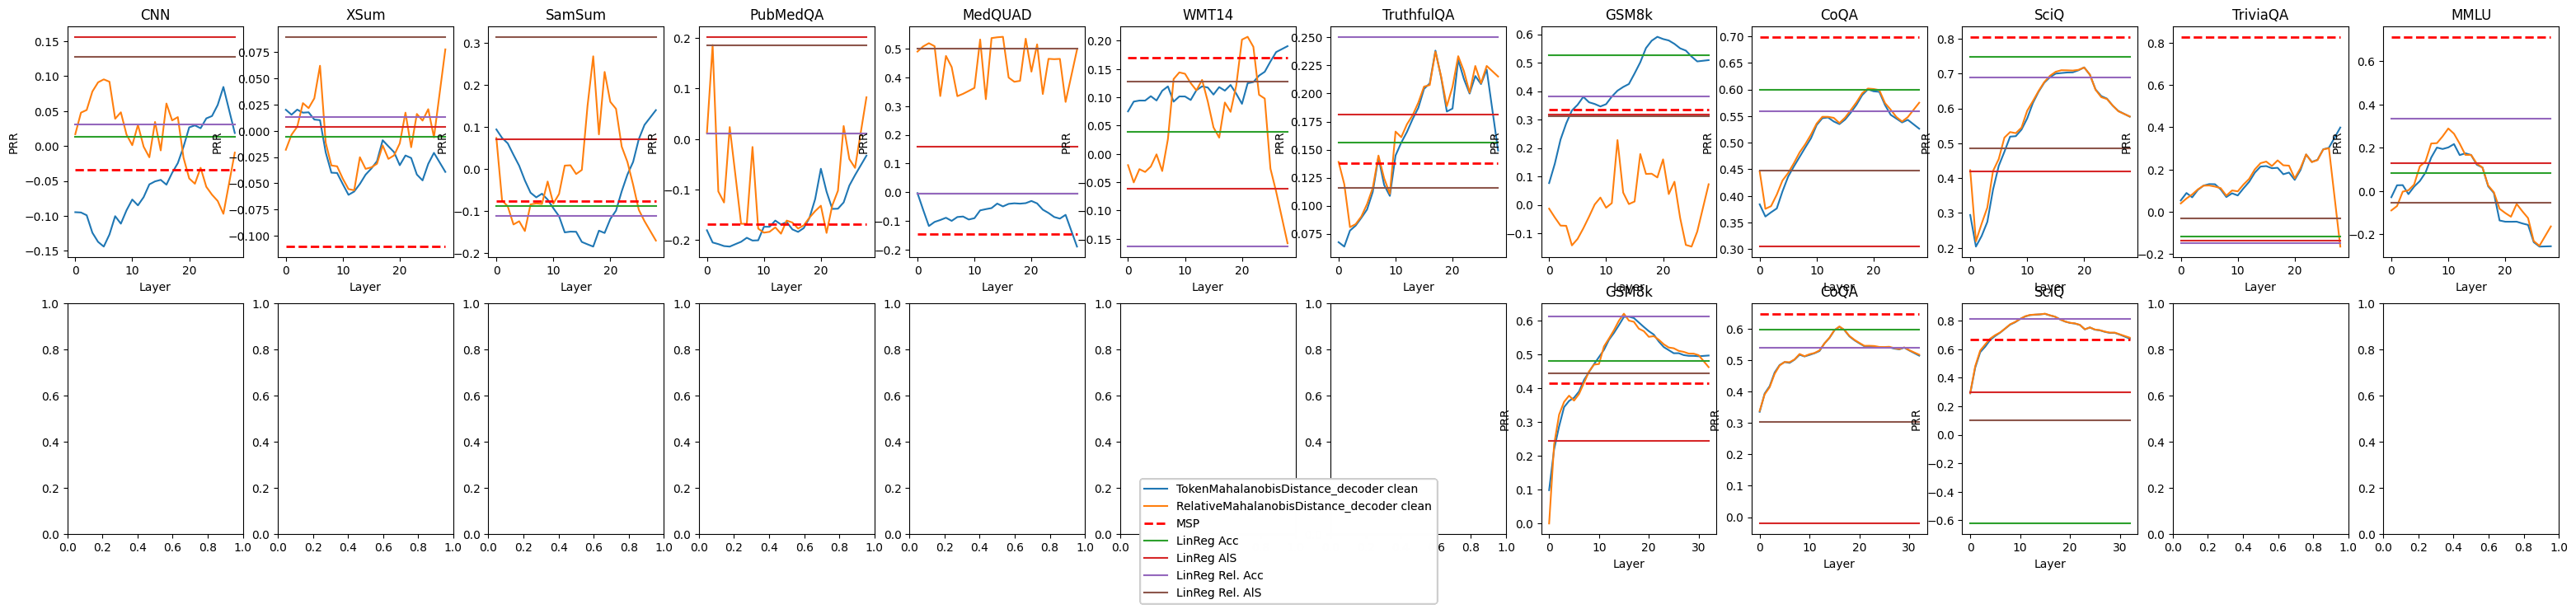

In [718]:
import matplotlib.pyplot as plt

paths_g = [
    "../workdir/output_layers_9/ats/google/gemma-7b/['cnn_dailymail', '3.0.0']/2024-07-28/17-47-41/ue_manager_seed1",
    "../workdir/output_layers_9/ats/google/gemma-7b/xsum/2024-07-27/14-36-27/ue_manager_seed1",
    #"../workdir/output_layers_9/ats/google/gemma-7b/xsum/2024-07-29/23-47-29/ue_manager_seed1",
    "../workdir/output_layers_9/ats/google/gemma-7b/samsum/2024-07-28/17-47-41/ue_manager_seed1",
    "../workdir/output_layers_9/qa/google/gemma-7b/bigbio/pubmed_qa/2024-07-29/03-57-10/ue_manager_seed1",
    "../workdir/output_layers_9/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-07-28/03-58-23/ue_manager_seed1",
    "../workdir/output_layers_9/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-07-28/03-58-23/ue_manager_seed1",
    "../workdir/output_layers_9/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-07-28/13-11-37/ue_manager_seed1",
    "../workdir/output_layers_9/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-27/14-36-27/ue_manager_seed1",
    "../workdir/output_layers_9/qa/google/gemma-7b/coqa/2024-07-27/14-36-52/ue_manager_seed1",
    "../workdir/output_layers_9/qa/google/gemma-7b/sciq/2024-07-28/00-56-15/ue_manager_seed1",
    "../workdir/output_layers_9/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-07-28/04-06-52/ue_manager_seed1",
    "../workdir/output_layers_9/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-07-28/15-01-18/ue_manager_seed1"
]

paths_l = [
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "../workdir/output_layers_9/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-07-29/03-57-10/ue_manager_seed1",
    "../workdir/output_layers_9/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-07-28/21-36-10/ue_manager_seed1",
    "../workdir/output_layers_9/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-29/07-23-24/ue_manager_seed1",
    "",
    "",
]

ds = ["CNN", "XSum", "SamSum", "PubMedQA", "MedQUAD", "WMT14", "TruthfulQA", "GSM8k", "CoQA", 'SciQ', "TriviaQA", "MMLU"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (name in col) and (suf in col)
names = ["TokenMahalanobisDistance_decoder", "RelativeMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=2, ncols=12, figsize=(39, 8))

for k, (d_name, path) in enumerate(zip(ds, paths_g)):
    if not len(path):
        continue
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf = "(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]    
        ax[0, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[0, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP", linestyle="--", color="r", linewidth=2)

    for c in df0.columns:
        if "LinReg" not in c:
            continue
        label = "LinReg"
        if "relative" in c.lower():
            label += " Rel."
            
        if "Accuracy, Accuracy" in c:
            label += " Acc"
        if "AlignScore, AlignScore" in c:
            label += " AlS"        
        ax[0, k].plot(layers, [df0[c][i]]*len(layers), label=label)
            
    ax[0, k].set_xlabel("Layer")
    ax[0, k].set_ylabel("PRR")
    ax[0, k].set_title(d_name)
    handles, labels = ax[0, k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')

for k, (d_name, path) in enumerate(zip(ds, paths_l)):
    if not len(path):
        continue
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf = "(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]    
        ax[1, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP", linestyle="--", color="r", linewidth=2)

    for c in df0.columns:
        if "LinReg" not in c:
            continue
        label = "LinReg"
        if "relative" in c.lower():
            label += " Rel."
            
        if "Accuracy, Accuracy" in c:
            label += " Acc"
        if "AlignScore, AlignScore" in c:
            label += " AlS"        
        ax[1, k].plot(layers, [df0[c][i]]*len(layers), label=label)
            
    ax[1, k].set_xlabel("Layer")
    ax[1, k].set_ylabel("PRR")
    ax[1, k].set_title(d_name)
    handles, labels = ax[0, k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')

/tmp/ipykernel_850378/3934477077.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)
/tmp/ipykernel_850378/3934477077.py:99: FutureWarning: You are u

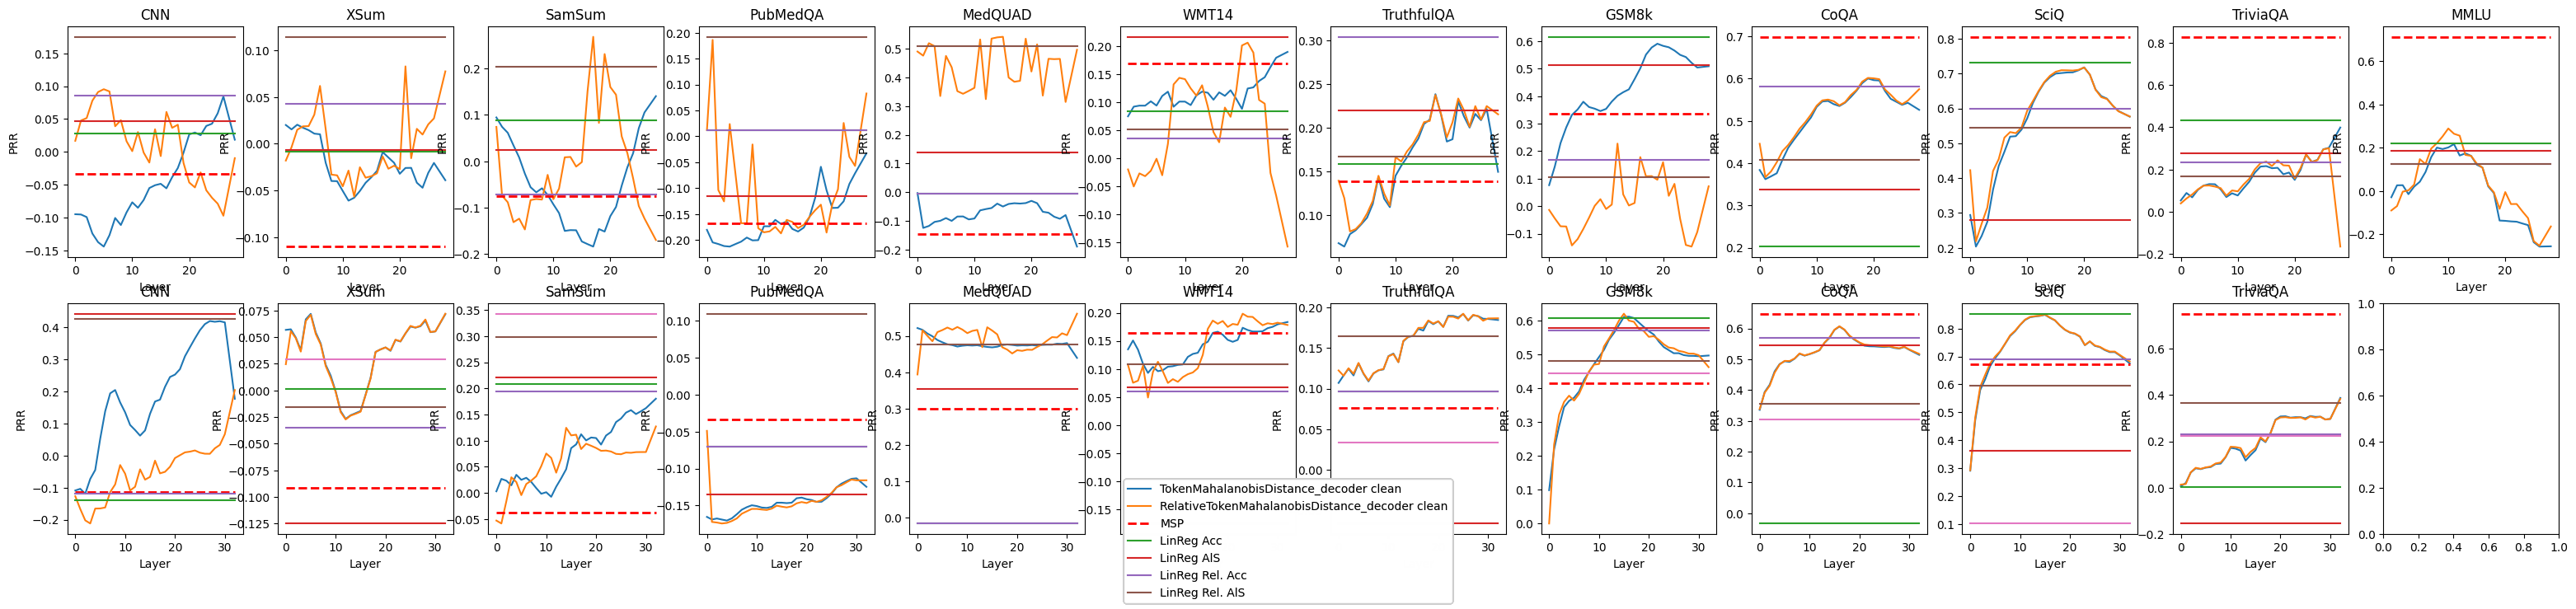

In [11]:
import matplotlib.pyplot as plt

paths_g = [
    "../workdir/output_layers/ats/google/gemma-7b/['cnn_dailymail', '3.0.0']/2024-08-02/02-00-24/ue_manager_seed1",
    "../workdir/output_layers/ats/google/gemma-7b/xsum/2024-07-31/21-50-20/ue_manager_seed1",
    "../workdir/output_layers/ats/google/gemma-7b/samsum/2024-08-01/08-16-08/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/bigbio/pubmed_qa/2024-08-01/08-16-08/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-08-01/14-54-57/ue_manager_seed1",
    "../workdir/output_layers/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-08-01/14-54-57/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-08-01/11-36-00/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-31/21-50-20/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-08-01/00-57-10/ue_manager_seed1",
    #"../workdir/output_layers_2/qa/google/gemma-7b/coqa/2024-08-02/21-30-03/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/sciq/2024-07-31/21-50-20/ue_manager_seed1",
    #"../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-08-02/19-07-04/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-08-01/06-39-42/ue_manager_seed1",
    #"../workdir/output_layers_2/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-08-03/04-13-11/ue_manager_seed1",
    "../workdir/output_layers/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-08-01/12-53-17/ue_manager_seed1"
]

paths_l = [
    "../workdir/output_layers/ats/meta-llama/Meta-Llama-3-8B/['cnn_dailymail', '3.0.0']/2024-08-03/11-49-32/ue_manager_seed1",
    "../workdir/output_layers/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-08-02/12-47-19/ue_manager_seed1",
    "../workdir/output_layers/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-02/12-47-19/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/bigbio/pubmed_qa/2024-08-02/23-39-56/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/keivalya/MedQuad-MedicalQnADataset/2024-08-03/11-49-32/ue_manager_seed1",
    "../workdir/output_layers/nmt/meta-llama/Meta-Llama-3-8B/['wmt14', 'de-en']/2024-08-02/23-39-56/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-02/10-31-57/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-02/02-00-24/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-01/21-33-22/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-01/18-23-12/ue_manager_seed1",
    "../workdir/output_layers/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-02/03-57-21/ue_manager_seed1",
    "",
]

ds = ["CNN", "XSum", "SamSum", "PubMedQA", "MedQUAD", "WMT14", "TruthfulQA", "GSM8k", "CoQA", 'SciQ', "TriviaQA", "MMLU"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (col.startswith(name)) and (suf in col)
    
names = ["TokenMahalanobisDistance_decoder", "RelativeTokenMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=2, ncols=12, figsize=(39, 8))

for k, (d_name, path) in enumerate(zip(ds, paths_g)):
    if not len(path):
        continue
    man = torch.load(path, weights_only=False)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf = "(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 28 for x in cols]    
        ax[0, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[0, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP", linestyle="--", color="r", linewidth=2)

    for c in df0.columns:
        if "LinReg" not in c:
            continue
        label = "LinReg"
        if "relative" in c.lower():
            label += " Rel."
        if "remove_corr_3" not in c:
            continue   
        if "Accuracy" in c:
            label += " Acc"
        if "AlignScore" in c:
            label += " AlS"   
            
        ax[0, k].plot(layers, [df0[c].iloc[i]]*len(layers), label=label)
            
    ax[0, k].set_xlabel("Layer")
    ax[0, k].set_ylabel("PRR")
    ax[0, k].set_title(d_name)
    handles, labels = ax[0, k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    

for k, (d_name, path) in enumerate(zip(ds, paths_l)):
    if not len(path):
        continue
    man = torch.load(path)
    metric_names = ['Accuracy', 'AlignScore']
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    elif d_name in ["TruthfulQA"]:
        suf = "(mean, AlignScore, 0.3)"
        i = 1
    else:
        suf = "(mean, Accuracy, 0.3)"
        i = 0
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 32 for x in cols]    
        ax[1, k].plot(layers, df0[cols].values[i], label=name +" clean")

    ax[1, k].plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP", linestyle="--", color="r", linewidth=2)

    for c in df0.columns:
        if "LinReg" not in c:
            continue
        label = "LinReg"
        if "relative" in c.lower():
            label += " Rel."
        if "remove_corr_4" in c:
            continue  
            
        ax[1, k].plot(layers, [df0[c].iloc[i]]*len(layers), label=label)
            
    ax[1, k].set_xlabel("Layer")
    ax[1, k].set_ylabel("PRR")
    ax[1, k].set_title(d_name)
    handles, labels = ax[0, k].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')

In [103]:
path = "../workdir/output_layers_9/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-29/07-23-24/ue_manager_seed1"
#path = "../workdir/output_layers_9/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-29/13-10-56/ue_manager_seed1"
path= "../workdir/output_layers_9/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-07-28/03-58-23/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-07-29/13-36-52/ue_manager_seed1"
path = "../workdir/output_layers_9/ats/google/gemma-7b/xsum/2024-07-29/23-47-29/ue_manager_seed1"
#path = "../workdir/output_layers_9/ats/google/gemma-7b/xsum/2024-07-27/14-36-27/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-29/23-47-29/ue_manager_seed1"
path = "../workdir/output_layers_9/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-27/14-36-27/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/sciq/2024-07-31/21-50-20/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/coqa/2024-08-01/00-57-10/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-31/21-50-20/ue_manager_seed1"
# path = "../workdir/output_layers/ats/google/gemma-7b/xsum/2024-07-31/21-50-20/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-08-01/06-39-42/ue_manager_seed1"
# path = "../workdir/output_layers/ats/google/gemma-7b/samsum/2024-08-01/08-16-08/ue_manager_seed1"
# path = "../workdir/output_layers/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-08-01/11-36-00/ue_manager_seed1"
path = "../workdir/output_layers/qa/google/gemma-7b/bigbio/pubmed_qa/2024-08-01/08-16-08/ue_manager_seed1"
#path = "../workdir/output_layers/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-08-01/12-53-17/ue_manager_seed1"
path = "../workdir/output_layers/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-08-01/14-54-57/ue_manager_seed1"
path = "../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-08-02/19-07-04/ue_manager_seed1"
#path = "../workdir/output_layers_2/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-08-03/04-13-11/ue_manager_seed1"
#path = "../workdir/output_layers_2/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-08-03/09-04-20/ue_manager_seed1"


path = "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-05/15-48-58/ue_manager_seed1" ##10k
#path = "../workdir/output_layers_2/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-03/15-45-25/ue_manager_seed1" ##2k

path = "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-06/16-48-44/ue_manager_seed1" ##10k
path = "../workdir/output_layers_2/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-03/19-28-22/ue_manager_seed1" ##2k

path = "../workdir/output_layers_2/qa/stabilityai/stablelm-2-12b/sciq/2024-08-07/16-03-49/ue_manager_seed1"
path = "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-08/18-43-26/ue_manager_seed1"
path = "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-09/15-39-26/ue_manager_seed1"
path = "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-09/16-20-50/ue_manager_seed1"
path = "../workdir/output/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-08-09/17-31-06/ue_manager_seed1"
path = "../workdir/output/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-09/18-38-22/ue_manager_seed1"


# '../workdir/output_layers_2/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-08-03/10-17-16/ue_manager_seed1'
#  ../workdir/output_layers_2/qa/google/gemma-7b/coqa/2024-08-02/21-30-03/ue_manager_seed1
#  ../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-08-02/19-07-04/ue_manager_seed1
# '../workdir/output_layers_2/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-08-03/04-13-11/ue_manager_seed1'
# '../workdir/output_layers_2/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-08-03/09-04-20/ue_manager_seed1'
# '../workdir/output_layers_2/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-04/09-23-01/ue_manager_seed1'
#  ../workdir/output_layers_2/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-03/19-28-22/ue_manager_seed1
#  ../workdir/output_layers_2/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-03/15-45-25/ue_manager_seed1
# '../workdir/output_layers_2/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-04/01-53-37/ue_manager_seed1'
# '../workdir/output_layers_2/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-04/07-50-44/ue_manager_seed1'

###############

path = "../workdir/output_layers_3/qa/google/gemma-7b/sciq/2024-08-13/12-40-22/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-7b/['gsm8k', 'main']/2024-08-10/11-20-43/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-7b/coqa/2024-08-13/19-16-24/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-08-14/05-46-11/ue_manager_seed1"
path = "../workdir/output_layers_3/ats/google/gemma-7b/samsum/2024-08-14/19-48-38/ue_manager_seed1"
path = "../workdir/output_layers_3/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-08-15/13-47-58/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-08-14/13-54-26/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-08-14/12-24-16/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-17/05-30-16/ue_manager_seed1"
path = "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-06/16-48-44/ue_manager_seed1"
path = '../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-08-11/16-34-45/ue_manager_seed1'

man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_8717/517428120.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [99]:
len(man["stats"]['target_texts'])

2000

In [63]:
path = "/home/jovyan/artemvazhentsev/lm-polygraph/workdir/output/qa/stabilityai/stablelm-2-12b/coqa/2024-08-08/17-21-24/ue_manager_seed1"
man = torch.load(path)

metric_names = ['Accuracy', 'AlignScore']
df = {}
for key in man['metrics'].keys():
    if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
        scores = df.get(key[1], [])
        scores.append(man['metrics'][key])
        df[key[1]] = scores
        
df0 = pd.DataFrame(df, index=[f'CoQA, {m}, PRR' for m in metric_names])  
df0.T.sort_values(f"CoQA, {metric_names[-2]}, PRR", ascending=False).style.background_gradient(axis=0)

/tmp/ipykernel_128/1182242931.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  man = torch.load(path)


In [2]:
import torch

def preproc_method_name(x):
    return x
    
def get_table(path, metric_names=["Rouge_rougeL", 'AlignScore'], dataset="CoQA", ue_metric="prr_normalized", 
              update_alignscore=False, aggregated=False, return_score=False, level="sequence"):
    man = torch.load(path)
    df = {}
    methods = np.unique([x[1] for x in man['metrics'].keys() if "2side" not in x[1]])
    for method in methods:
        for metric in metric_names:
            key = (level, method, metric, ue_metric)
            scores = df.get(method, [])
            scores.append(man['metrics'][key])
            df[method] = scores

    if update_alignscore:
        greedy_texts = [x if len(x.strip())>0 else "-" for x in man['stats']["greedy_texts"]]
        greedy_texts = np.array(greedy_texts)
        target_texts = man['stats']["target_texts"]

        alignscores_1 = man['gen_metrics'][('sequence', 'AlignScore')]
        if aggregated:
            alignscores_2 = []
            for i, greedy_text in tqdm(enumerate(greedy_texts)):
                scores = []
                for j, target_text in enumerate(target_texts[i]):
                    scores.append(scorer({"greedy_texts": [target_text], "target_texts": [greedy_text]}, [greedy_text], [greedy_text]))
                alignscores_2.append(np.max(scores))
            alignscores_2 = np.array(alignscores_2)
        else:
            alignscores_2 = scorer({"greedy_texts": target_texts, "target_texts": greedy_texts}, greedy_texts, greedy_texts)
        
        alignscores_0 = np.mean([alignscores_1, alignscores_2], axis=0)
        for method in methods:
            key = (level, method, "", ue_metric)
            estimator_values = np.array(man['estimations'][('sequence', key[1])])         
            rec_metrics_val = np.array(alignscores_0)
    
            ue = np.array(estimator_values)
            mean_val = prr(ue, rec_metrics_val) 
            oracle = prr(-rec_metrics_val, rec_metrics_val)
            random = get_random_scores(prr, rec_metrics_val)
            final_score = (mean_val - random) / (oracle - random)
            scores = df.get(method, [])
            scores.append(final_score)
            df[method] = scores
        metric_names += ["AlignScore (2side)"]

    df0 = pd.DataFrame(df, index=pd.MultiIndex.from_tuples([(dataset, m) for m in metric_names])).T

    for metric in metric_names:
        if metric == "AlignScore (2side)":
            print(f"{metric}:", np.mean(alignscores_0))
        else:
            print(f"{metric}:", np.mean(man['gen_metrics'][('sequence', metric)]))

    if return_score:
        return df0, alignscores_1, alignscores_2 

    aggregation = ["mean" if "mean" in x else "sum(log(p_i))" if "sum(log(p_i))" in x else "-" for x in df0.index]
    method = [preproc_method_name(x) for x in df0.index]
    df0.loc[:, (dataset, 'Aggregation')] = aggregation
    df0.loc[:, (dataset, 'Method')] = method
    return df0.reset_index(drop=True)

In [71]:
seed = 1

base_path = "../workdir/fc/bio/mistralai/Mistral-7B-Instruct-v0.1/['rediska0123/person-bio']/"
time = "2024-08-08/12-05-53"
data = {}


for fold in [0,2]:
    path1 = f"{base_path}/{time}/ue_manager_seed{seed}_fold{fold}"

    data1 = torch.load(path1)
    
    for k in data1.keys():
        if isinstance(data1[k], dict):
            if k not in data.keys():
                data[k] = {}
            for k1 in data1[k].keys():
                if isinstance(data1[k][k1], list):
                    if k1 not in data[k].keys():
                        data[k][k1] = data1[k][k1]
                    else:
                        data[k][k1] += data1[k][k1]
                else:
                    if k1 not in data[k].keys():
                        data[k][k1] = data1[k][k1]
                    else:
                        data[k][k1] += data1[k][k1]
                        
        elif isinstance(data1[k], list):
            data[k] = data1[k] + data2[k]
        else:
            print(k)

/tmp/ipykernel_128/1237318547.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data1 = torch.load(path1)


In [72]:
from lm_polygraph.ue_metrics import *

rocauc = ROCAUC()
prauc = PRAUC()

def get_table_upd(man, metric_names=['PR-AUC', "ROC-AUC"], dataset="CoQA", ue_metric="prr_normalized", 
                  update_alignscore=False, aggregated=False, return_score=False, level="claim"):
    df = {}
    methods = np.unique([x[1] for x in man['metrics'].keys() if "2side" not in x[1]])
    metric = np.array(man['gen_metrics'][('claim', 'OpenAIFactCheck')])  
    for method in methods:
        key = (level, method, "", ue_metric)
        estimator_values = np.array(man['estimations'][(level, key[1])])         
        rec_metrics_val = np.array(metric)

        ue = np.array(estimator_values)
        final_score = prauc(ue, rec_metrics_val) 
        scores = df.get(method, [])
        scores.append(final_score)
        df[method] = scores

    for method in methods:
        key = (level, method, "", ue_metric)
        estimator_values = np.array(man['estimations'][(level, key[1])])         
        rec_metrics_val = np.array(metric)

        ue = np.array(estimator_values)
        final_score = rocauc(ue, rec_metrics_val) 
        scores = df.get(method, [])
        scores.append(final_score)
        df[method] = scores

    df0 = pd.DataFrame(df, index=pd.MultiIndex.from_tuples([(dataset, m) for m in metric_names])).T
    aggregation = ["mean" if "mean" in x else "sum(log(p_i))" if "sum(log(p_i))" in x else "-" for x in df0.index]
    method = [preproc_method_name(x) for x in df0.index]
    df0.loc[:, (dataset, 'Aggregation')] = aggregation
    df0.loc[:, (dataset, 'Method')] = method
    return df0.reset_index(drop=True)

get_table_upd(data).style.background_gradient(axis=0)

In [15]:
path = "../workdir/output_layers_9/qa/google/gemma-7b/coqa/2024-07-27/14-36-52/ue_manager_seed1"
path = "../workdir/output_layers_2/qa/google/gemma-7b/coqa/2024-07-19/10-28-38/ue_manager_seed1"
data = torch.load(path)
data["metrics"][('sequence', 'MaximumSequenceProbability', 'Accuracy', 'prr_normalized')]

0.6990838594736303

In [ ]:
path = "../workdir/output_layers_2/qa/google/gemma-7b/['gsm8k', 'main']/2024-07-19/10-28-33/ue_manager_seed1"
data = torch.load(path)
len(data["stats"]["input_texts"])

In [1673]:
path = "../workdir/output_layers_2/qa/google/gemma-7b/sciq/2024-07-19/20-55-43/ue_manager_seed1"
data = torch.load(path)
layers = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,-1]
X_eval = []
y_eval = np.array(data["gen_metrics"][("sequence", "AlignScore")])
for l in layers:
    if l != -1:
        X_eval.append(data["estimations"][('sequence', f'TokenMahalanobisDistance_decoder_{l} (mean, AlignScore, 0.3)')])
    else:
        X_eval.append(data["estimations"][('sequence', f'TokenMahalanobisDistance_decoder (mean, AlignScore, 0.3)')])
    print(l, get_prr(X_eval[-1], y_eval))

X_eval = np.array(X_eval).T
X_eval.shape, y_eval.shape

0 0.0846615929447472
1 0.11570557060217707
2 0.12664693761274978
3 0.13247704407642288
4 0.19486437966892772
5 0.2512488317800179
6 0.2873305388431099
7 0.38362934602790755
8 0.39590912407928097
9 0.4107450323677575
10 0.4510566849456764
11 0.48839500525659985
12 0.5331265511591103
13 0.5607132151016239
14 0.6031154398298
15 0.6034399651797946
16 0.6169025319550842
17 0.6245717718451471
18 0.6458798757154246
19 0.654332226179254
20 0.656527230983212
21 0.6351964154857757
22 0.603703555660411
23 0.5758738960418482
24 0.568882268190312
25 0.5363229122148064
26 0.5310399592119046
-1 0.5538333713530977


((1000, 28), (1000,))

In [1674]:
import numpy as np
from scipy import stats

In [1675]:
bad_indices = []

for i in range(X_eval.shape[1]):
    bad_indices.append(np.argwhere((np.abs(np.corrcoef(X_eval.T)[i]) > 0.98) & (np.arange(X_eval.shape[1]) != i)).flatten())

In [1677]:
feats = np.arange(X_eval.shape[1])
removed = np.zeros_like(feats, dtype=bool)
added = np.zeros_like(feats, dtype=bool)

for f in feats:
    if removed[f]:
        continue
    added[f] = True
    # corrs = np.array([stats.pearsonr(x, X_eval.T[f]).statistic for x in X_eval.T])
    # corr_idx = np.argwhere((np.abs(corrs) > 0.9) & (np.arange(X_eval.shape[1]) != f)).flatten()
    
    # corr_idx = np.argwhere((np.abs(np.corrcoef(X_eval.T)[f]) > 0.8) & (np.arange(X_eval.shape[1]) != f)).flatten()
    corr_idx = np.argwhere((np.abs(np.corrcoef(X_eval.T)[f]) > 0.9)).flatten()
    removed[corr_idx] = True
    print(f, corr_idx)

0 [0 1 2 3]
4 [2 3 4 5 6]
7 [5 6 7 8 9]
10 [ 8  9 10 11 12]
13 [11 12 13 14 15 16 17]
18 [14 15 16 17 18 19 20 21]
22 [20 21 22 23 24 25]
26 [23 24 25 26]
27 [27]


In [1643]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import copy

def calculate_vif(X, thresh=200.0):
    # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
    dropped = True
    drp_ind = []
    X_cp = copy.deepcopy(X)
    while dropped:
        feats = np.arange(X.shape[1])
        dropped = False
        vif = [variance_inflation_factor(X, f) for f in feats]
        print(vif)
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = np.argmax(vif)
            for i in np.arange(X_cp.shape[1]):
                if all(X_cp[:, i] == X[:, maxloc]):
                    drp_ind.append(i)
                    print(i, maxloc)
            X = np.delete(X, maxloc, 1)
            dropped=True
    return X, drp_ind

X_eval_, drp_ind = calculate_vif(copy.deepcopy(X_eval))

[144.2160593733191, 212.09915214445283, 511.5929478953443, 471.9479795292741, 659.6520706375576, 538.5239194254546, 557.3467254096881, 498.6438217329804, 446.85475764034067, 870.2313226992526, 1409.2136995534604, 1832.402206649668, 1681.417458272221, 1871.0691585110562, 2287.296652826098, 2320.773105864338, 2527.5174878011653, 1954.9752490656101, 1747.2898237633474, 1983.3272851662746, 1618.2388386179703, 1032.297662331271, 1035.152314369401, 1285.6421858281446, 1559.8747655725413, 2205.3449456556064, 1464.6947716944671, 77.07678845080517]
16 16
[143.82857154873423, 212.00093930985116, 510.08464274203027, 470.5510962544803, 659.2333362791977, 538.4316543035709, 556.5494563023087, 495.1934751675588, 445.7969448244801, 868.8312036944856, 1409.0185454646248, 1788.0211430037127, 1627.7161735561099, 1854.300648168718, 2259.8843428843074, 1822.8474995711856, 1296.6470443120154, 1733.8447091783435, 1969.6911916402978, 1616.7161986154122, 1025.4379139943005, 1034.3338596898188, 1285.3420097696

In [1644]:
X_eval_

array([[197.74499512, 761.94512939, 212.89677429, ...,  90.44390869,
        114.43184662, 139.28994751],
       [ 25.50933838,  36.32373428,  44.68458176, ...,  76.04582977,
         72.24446869,  65.41980743],
       [140.3447113 , 496.5904541 , 127.41162872, ...,  63.63002777,
         69.2456665 ,  76.33733368],
       ...,
       [ 51.02603149,  66.74905396,  73.14386749, ...,  68.17565155,
         70.13173676,  66.29410553],
       [108.36135864, 332.43234253, 129.1191864 , ...,  67.63922882,
         69.77747345,  68.56338501],
       [104.65659332, 345.16140747,  93.35748291, ...,  71.61834717,
         81.45282745,  84.51960754]])

In [1645]:
np.argwhere(~np.isin(np.arange(X_eval.shape[1]), drp_ind))

array([[ 0],
       [ 1],
       [ 3],
       [ 5],
       [ 8],
       [10],
       [17],
       [21],
       [27]])

In [1475]:
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

ModuleNotFoundError: No module named 'statsmodels'

In [1473]:
f = 2
np.argwhere((np.abs(np.corrcoef(X_eval.T)[f]) > 0.8) & (np.arange(X_eval.shape[1]) != f)).flatten()

array([0, 1, 3, 4, 5, 6])

In [1458]:
X_eval.T

(28, 1000)

In [1454]:
np.abs(np.corrcoef(X_eval.T))[0]

array([1.        , 0.98725537, 0.97747429, 0.9425059 , 0.87853488,
       0.82590394, 0.79545755, 0.72779887, 0.66792838, 0.59998215,
       0.55530335, 0.488673  , 0.42437135, 0.33668098, 0.30214807,
       0.26959265, 0.24388116, 0.22459556, 0.17454167, 0.11096356,
       0.09473309, 0.17679245, 0.30442557, 0.40788503, 0.44093348,
       0.51503773, 0.5223848 , 0.48583048])

In [1455]:
np.corrcoef(X_eval[:, added].T)

array([[1.        , 0.79545755, 0.42437135, 0.11096356, 0.51503773],
       [0.79545755, 1.        , 0.7590985 , 0.42543614, 0.72081779],
       [0.42437135, 0.7590985 , 1.        , 0.78044387, 0.79642709],
       [0.11096356, 0.42543614, 0.78044387, 1.        , 0.74721022],
       [0.51503773, 0.72081779, 0.79642709, 0.74721022, 1.        ]])

In [1443]:
X_eval[:, added].shape

(1000, 9)

(array([  6.,  38.,  77.,  84.,  78.,  91.,  90.,  93., 104.,  82.,  86.,
         52.,  38.,  28.,  15.,  14.,   8.,   8.,   4.,   4.]),
 array([ 36.68912506,  43.31855736,  49.94798965,  56.57742195,
         63.20685425,  69.83628654,  76.46571884,  83.09515114,
         89.72458344,  96.35401573, 102.98344803, 109.61288033,
        116.24231262, 122.87174492, 129.50117722, 136.13060951,
        142.76004181, 149.38947411, 156.0189064 , 162.6483387 ,
        169.277771  ]),
 <BarContainer object of 20 artists>)

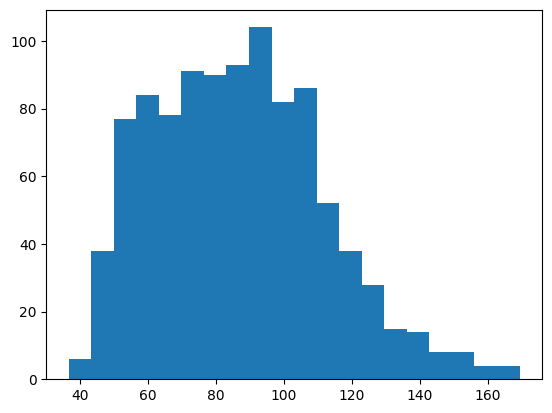

In [1308]:
plt.hist(X_eval[:, -20], bins=20)

In [45]:
data = torch.load(paths_g[5])

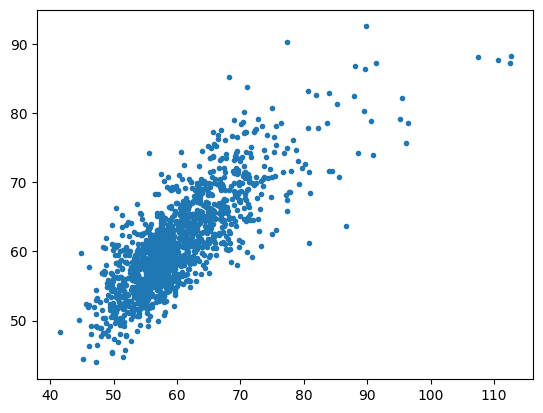

In [76]:
plt.plot(data["estimations"][('sequence', 'TokenMahalanobisDistance_decoder_19 (mean, Accuracy, 0.3)')], data["estimations"][('sequence', 'TokenMahalanobisDistance_decoder_26 (mean, Accuracy, 0.3)')], '.')

In [79]:
x = np.array([0,1,2,3])

np.mean([x, x], axis=0)

array([0., 1., 2., 3.])

In [70]:
from scipy import stats

for i in range(0, 27):
    res = stats.spearmanr(data["estimations"][('sequence', f'TokenMahalanobisDistance_decoder_{i} (mean, Accuracy, 0.3)')], data["estimations"][('sequence', 'TokenMahalanobisDistance_decoder_26 (mean, Accuracy, 0.3)')])
    print(i, res)

0 SignificanceResult(statistic=0.5883239164047777, pvalue=1.1887669896568716e-123)
1 SignificanceResult(statistic=0.6179168900266039, pvalue=9.981697136857276e-140)
2 SignificanceResult(statistic=0.7263102310814017, pvalue=1.1433281303358338e-216)
3 SignificanceResult(statistic=0.7668408379023506, pvalue=6.851694248305077e-256)
4 SignificanceResult(statistic=0.8087664712645608, pvalue=6.766480976721833e-306)
5 SignificanceResult(statistic=0.8350121085889395, pvalue=0.0)
6 SignificanceResult(statistic=0.8516739215757478, pvalue=0.0)
7 SignificanceResult(statistic=0.8536702519393674, pvalue=0.0)
8 SignificanceResult(statistic=0.831331851413418, pvalue=0.0)
9 SignificanceResult(statistic=0.799511345110778, pvalue=7.664538719511984e-294)
10 SignificanceResult(statistic=0.7920397935100403, pvalue=1.4539096213177617e-284)
11 SignificanceResult(statistic=0.7847433020025236, pvalue=7.273446198835599e-276)
12 SignificanceResult(statistic=0.7762849969532346, pvalue=3.389497040206605e-266)
13 Sig

In [75]:
for i in range(0, 27):
    print(i, data["metrics"][('sequence', f'TokenMahalanobisDistance_decoder_{i} (mean, Accuracy, 0.3)', 'Accuracy', 'prr_normalized')])

0 0.07638494187837333
1 0.1446084102147791
2 0.22935109819001603
3 0.28643317785032785
4 0.33185651868428045
5 0.3518091198728497
6 0.3798470080336639
7 0.36059571195203
8 0.3546118554900894
9 0.34592474620274294
10 0.35391148988442767
11 0.38042934483617363
12 0.4013310260439692
13 0.4144370256449713
14 0.4248290923243192
15 0.46201085794202007
16 0.5012705797055557
17 0.5512655484008924
18 0.5771019901459705
19 0.5908565292498663
20 0.5830788430329319
21 0.578020679196956
22 0.5660033991949046
23 0.5503111108462949
24 0.5423837795804004
25 0.5215101044991124
26 0.5043001970987899


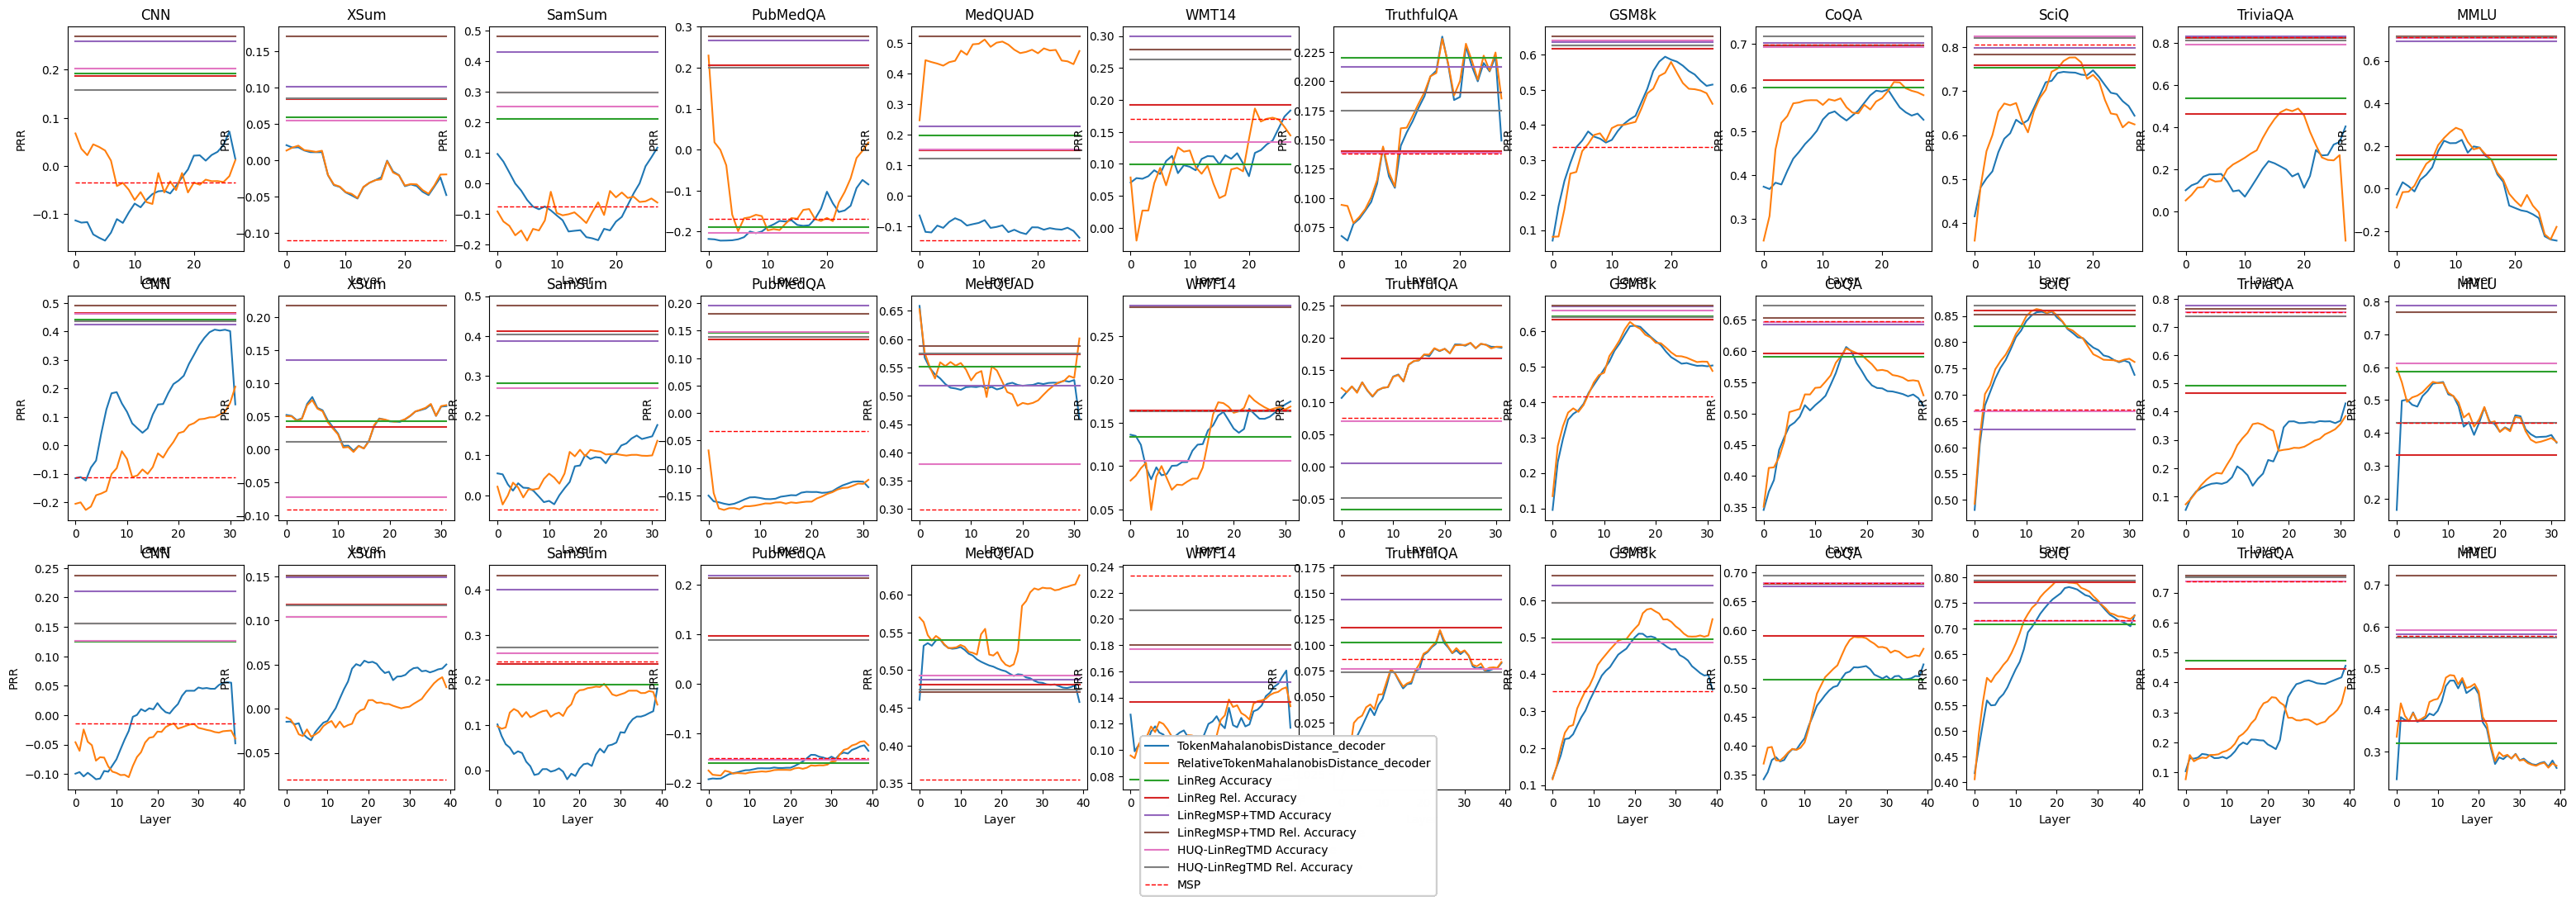

In [11]:
import matplotlib.pyplot as plt

paths = {
    "gemma": [
        "../workdir/output_layers_3/ats/google/gemma-7b/['cnn_dailymail', '3.0.0']/2024-08-16/08-50-48/ue_manager_seed1",
        "../workdir/output_layers_3/ats/google/gemma-7b/xsum/2024-08-10/11-20-43/ue_manager_seed1",
        "../workdir/output_layers_3/ats/google/gemma-7b/samsum/2024-08-14/19-48-38/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/bigbio/pubmed_qa/2024-08-15/02-48-12/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-08-11/02-18-34/ue_manager_seed1",
        "../workdir/output_layers_3/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-08-15/13-47-58/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-08-14/12-24-16/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/['gsm8k', 'main']/2024-08-10/11-20-43/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/coqa/2024-08-13/19-16-24/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/sciq/2024-08-13/12-40-22/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/['trivia_qa', 'rc.nocontext']/2024-08-14/05-46-11/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/['cais/mmlu', 'all']/2024-08-14/13-54-26/ue_manager_seed1"
    ],
    "llama": [
        "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/['cnn_dailymail', '3.0.0']/2024-08-24/17-55-46/ue_manager_seed1",
        "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-08-11/16-34-45/ue_manager_seed1",
        "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-18/05-34-35/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/bigbio/pubmed_qa/2024-08-23/07-04-09/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/keivalya/MedQuad-MedicalQnADataset/2024-08-11/16-34-44/ue_manager_seed1",
        "../workdir/output_layers_3/nmt/meta-llama/Meta-Llama-3-8B/['wmt14', 'de-en']/2024-08-23/22-52-33/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-17/21-27-43/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-11/02-18-35/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-17/05-30-16/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-17/00-46-31/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-17/13-38-44/ue_manager_seed1",
        "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-17/23-22-40/ue_manager_seed1",
    ],
    "stablelm": [
        "../workdir/output_layers_3/ats/stabilityai/stablelm-2-12b/['cnn_dailymail', '3.0.0']/2024-08-22/19-17-57/ue_manager_seed1",
        "../workdir/output_layers_3/ats/stabilityai/stablelm-2-12b/xsum/2024-08-22/20-29-56/ue_manager_seed1",
        "../workdir/output_layers_3/ats/stabilityai/stablelm-2-12b/samsum/2024-08-14/12-21-08/ue_manager_seed1",
        "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/bigbio/pubmed_qa/2024-08-15/07-23-46/ue_manager_seed1",
        "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/keivalya/MedQuad-MedicalQnADataset/2024-08-24/13-05-09/ue_manager_seed1",
        "../workdir/output_layers_3/nmt/stabilityai/stablelm-2-12b/['wmt14', 'de-en']/2024-08-16/04-16-46/ue_manager_seed1",
        "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/['truthful_qa', 'generation']/2024-08-13/21-59-52/ue_manager_seed1",
        "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/['gsm8k', 'main']/2024-08-21/11-28-41/ue_manager_seed1",
        "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/coqa/2024-08-12/21-08-16/ue_manager_seed1",
        "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/sciq/2024-08-12/13-30-15/ue_manager_seed1",
        "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/['trivia_qa', 'rc.nocontext']/2024-08-13/09-44-35/ue_manager_seed1",
        "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/['cais/mmlu', 'all']/2024-08-14/02-23-52/ue_manager_seed1",
    ]
}

ds = ["CNN", "XSum", "SamSum", "PubMedQA", "MedQUAD", "WMT14", "TruthfulQA", "GSM8k", "CoQA", 'SciQ', "TriviaQA", "MMLU"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (col.startswith(name)) and (suf in col)
    
names = ["TokenMahalanobisDistance_decoder", "RelativeTokenMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=len(paths.keys()), ncols=12, figsize=(39, 4*len(paths.keys())))
colors = plt.get_cmap('tab10').colors

def plot_chart(ax, path, d_name, metric="Accuracy", target_metric="Accuracy", update_alignscore=False):
    color = 0
    man = torch.load(path, weights_only=False)
    metric_names = [target_metric]
    df = {}    
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    if update_alignscore:
        greedy_texts = [x if len(x.strip())>0 else "-" for x in man['stats']["greedy_texts"]]
        greedy_texts = np.array(greedy_texts)
        target_texts = man['stats']["target_texts"]

        alignscores_1 = man['gen_metrics'][('sequence', 'AlignScore')]
        aggregated = True if ("truthful_qa" in path) or ("trivia_qa" in path) else False
        if aggregated:
            alignscores_2 = []
            for i, greedy_text in tqdm(enumerate(greedy_texts)):
                scores = []
                for j, target_text in enumerate(target_texts[i]):
                    scores.append(scorer({"greedy_texts": [target_text], "target_texts": [greedy_text]}, [greedy_text], [greedy_text]))
                alignscores_2.append(np.max(scores))
            alignscores_2 = np.array(alignscores_2)
        else:
            alignscores_2 = scorer({"greedy_texts": target_texts, "target_texts": greedy_texts}, greedy_texts, greedy_texts)
        
        alignscores_0 = np.mean([alignscores_1, alignscores_2], axis=0)
        
        for method in df.keys():
            estimator_values = np.array(man['estimations'][('sequence', method)])         
            rec_metrics_val = np.array(alignscores_0)
    
            ue = np.array(estimator_values)
            mean_val = prr(ue, rec_metrics_val) 
            oracle = prr(-rec_metrics_val, rec_metrics_val)
            random = get_random_scores(prr, rec_metrics_val)
            final_score = (mean_val - random) / (oracle - random)
            scores = df.get(method, [])
            scores.append(final_score)
            df[method] = scores
        metric_names += ["AlignScore (2side)"]
            
    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    
    suf = f"(mean, {metric}, 0.3)"
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) for x in cols if len(x.split("_")) > 2]    
        layers += [max(layers) + 1]
        ax.plot(layers, df0[cols].values[0], label=name, color=colors[color])
        color += 1

    for c in df0.columns:
        if "LinReg" not in c:
            continue
        if metric not in c:
            continue

        if "HUQ" in c:
            label = "HUQ-LinRegTMD"
        elif "Hybrid" in c:
            label = "LinRegMSP+TMD"
        else:
            label = "LinReg"
            
        if "relative" in c.lower():
            label += " Rel."
        if "remove_corr_3" not in c:
            continue   
        label += f" {metric}"            
        ax.plot(layers, [df0[c].iloc[0]]*len(layers), label=label, color=colors[color])

        color += 1

    ax.plot(layers, [df0['MaximumSequenceProbability'].iloc[0]]*len(layers), label="MSP", linestyle="--", color="r", linewidth=1)
    ax.set_xlabel("Layer")
    ax.set_ylabel("PRR")
    ax.set_title(d_name)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')


for i, model in enumerate(paths.keys()):
    for k, (d_name, path) in enumerate(zip(ds, paths[model])):
        if not len(path):
            continue
            
        if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA", "TruthfulQA"]:
            metric = "AlignScore"
        else:
            metric = "Accuracy"
        plot_chart(ax[i, k], path, d_name, metric=metric, target_metric=metric)

In [61]:
from lm_polygraph.generation_metrics.alignscore import AlignScore
from lm_polygraph.ue_metrics.ue_metric import get_random_scores
from tqdm import tqdm
scorer = AlignScore()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


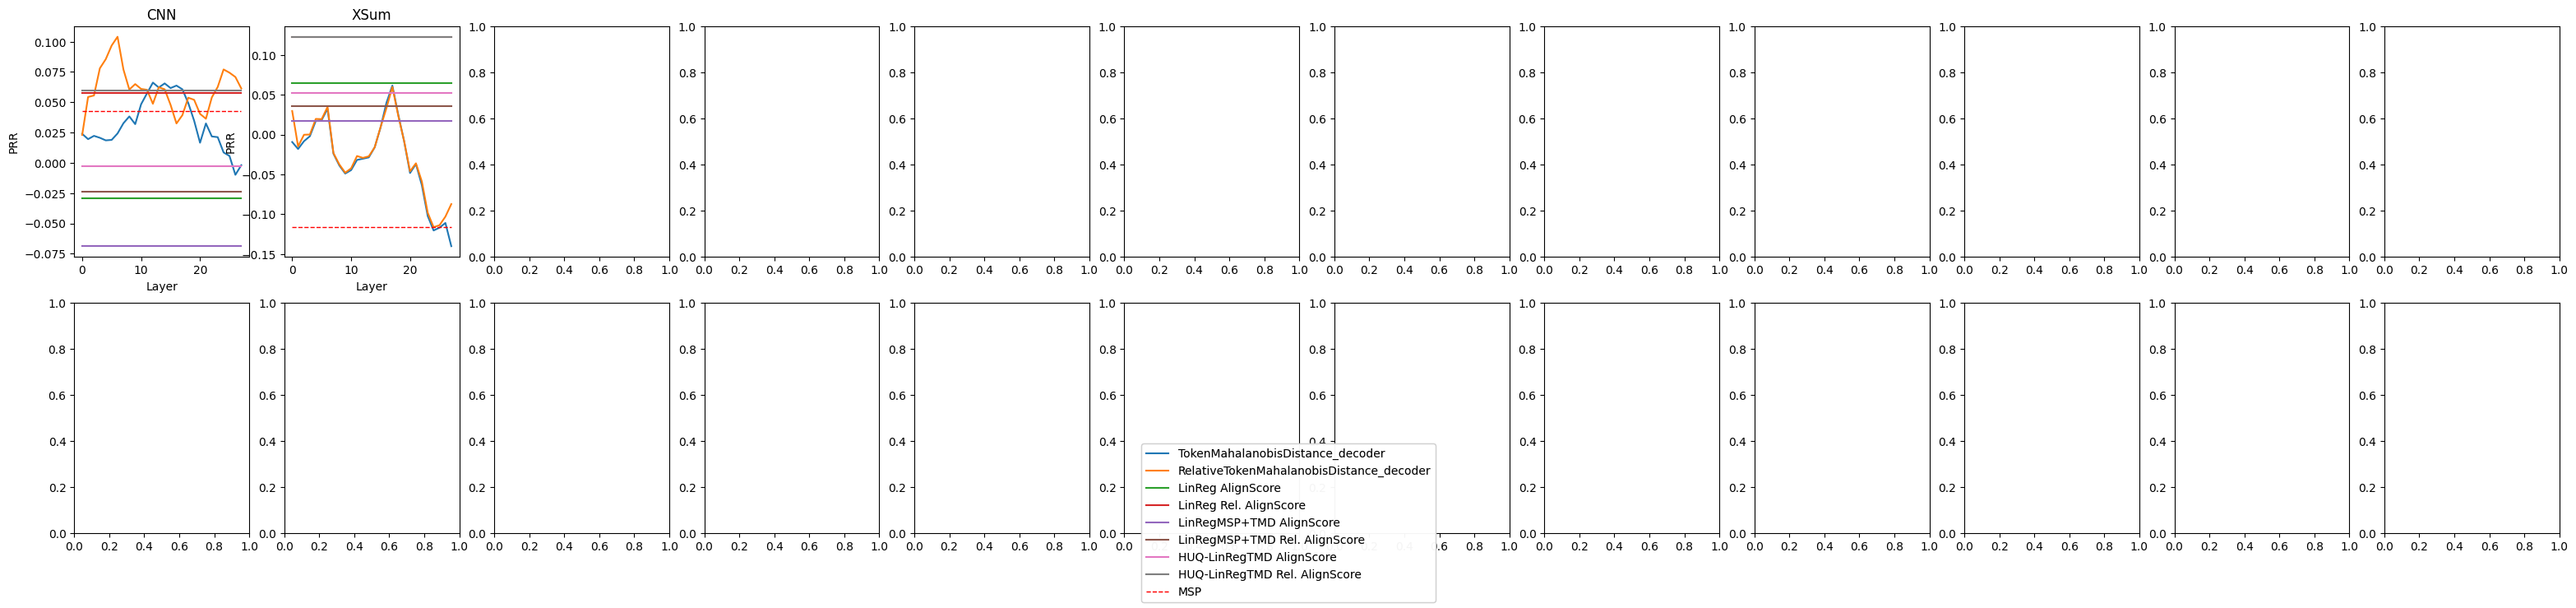

In [63]:
import matplotlib.pyplot as plt

paths = {
    "gemma": [
        "../workdir/output_layers_3/ats/google/gemma-7b/['cnn_dailymail', '3.0.0']/2024-08-16/08-50-48/ue_manager_seed1",
        "../workdir/output_layers_3/ats/google/gemma-7b/xsum/2024-08-10/11-20-43/ue_manager_seed1",
        "../workdir/output_layers_3/ats/google/gemma-7b/samsum/2024-08-14/19-48-38/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/bigbio/pubmed_qa/2024-08-15/02-48-12/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/keivalya/MedQuad-MedicalQnADataset/2024-08-11/02-18-34/ue_manager_seed1",
        "../workdir/output_layers_3/nmt/google/gemma-7b/['wmt14', 'de-en']/2024-08-15/13-47-58/ue_manager_seed1",
        "../workdir/output_layers_3/qa/google/gemma-7b/['truthful_qa', 'generation']/2024-08-14/12-24-16/ue_manager_seed1",
    ],
    "llama": [
        "",
        # "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/xsum/2024-08-11/16-34-45/ue_manager_seed1",
        # "../workdir/output_layers_3/ats/meta-llama/Meta-Llama-3-8B/samsum/2024-08-18/05-34-35/ue_manager_seed1",
        # "",
        # "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/keivalya/MedQuad-MedicalQnADataset/2024-08-11/16-34-44/ue_manager_seed1",
        # "",
        # "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['truthful_qa', 'generation']/2024-08-17/21-27-43/ue_manager_seed1",
        # "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['gsm8k', 'main']/2024-08-11/02-18-35/ue_manager_seed1",
        # "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/coqa/2024-08-17/05-30-16/ue_manager_seed1",
        # "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/sciq/2024-08-17/00-46-31/ue_manager_seed1",
        # "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['trivia_qa', 'rc.nocontext']/2024-08-17/13-38-44/ue_manager_seed1",
        # "../workdir/output_layers_3/qa/meta-llama/Meta-Llama-3-8B/['cais/mmlu', 'all']/2024-08-17/23-22-40/ue_manager_seed1",
    ],
    # "stablelm": [
    #     "",
    #     "",
    #     "../workdir/output_layers_3/ats/stabilityai/stablelm-2-12b/samsum/2024-08-14/12-21-08/ue_manager_seed1",
    #     "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/bigbio/pubmed_qa/2024-08-15/07-23-46/ue_manager_seed1",
    #     "",
    #     "../workdir/output_layers_3/nmt/stabilityai/stablelm-2-12b/['wmt14', 'de-en']/2024-08-16/04-16-46/ue_manager_seed1",
    #     "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/['truthful_qa', 'generation']/2024-08-13/21-59-52/ue_manager_seed1",
    #     "",
    #     "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/coqa/2024-08-12/21-08-16/ue_manager_seed1",
    #     "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/sciq/2024-08-12/13-30-15/ue_manager_seed1",
    #     "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/['trivia_qa', 'rc.nocontext']/2024-08-13/09-44-35/ue_manager_seed1",
    #     "../workdir/output_layers_3/qa/stabilityai/stablelm-2-12b/['cais/mmlu', 'all']/2024-08-14/02-23-52/ue_manager_seed1",
    # ]
}

ds = ["CNN", "XSum"]#, "SamSum", "PubMedQA", "MedQUAD", "WMT14", "TruthfulQA"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (col.startswith(name)) and (suf in col)
    
names = ["TokenMahalanobisDistance_decoder", "RelativeTokenMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=len(paths.keys()), ncols=12, figsize=(39, 4*len(paths.keys())))
colors = plt.get_cmap('tab10').colors

def plot_chart(ax, path, d_name, metric="Accuracy", target_metric="Accuracy", update_alignscore=False):
    color = 0
    man = torch.load(path, weights_only=False)
    metric_names = [target_metric]
    df = {}    
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    if update_alignscore:
        greedy_texts = [x if len(x.strip())>0 else "-" for x in man['stats']["greedy_texts"]]
        greedy_texts = np.array(greedy_texts)
        target_texts = man['stats']["target_texts"]

        alignscores_1 = man['gen_metrics'][('sequence', 'AlignScore')]
        aggregated = True if ("truthful_qa" in path) or ("trivia_qa" in path) else False
        if aggregated:
            alignscores_2 = []
            for i, greedy_text in tqdm(enumerate(greedy_texts)):
                scores = []
                for j, target_text in enumerate(target_texts[i]):
                    scores.append(scorer({"greedy_texts": [target_text], "target_texts": [greedy_text]}, [greedy_text], [greedy_text]))
                alignscores_2.append(np.max(scores))
            alignscores_2 = np.array(alignscores_2)
        else:
            alignscores_2 = scorer({"greedy_texts": target_texts, "target_texts": greedy_texts}, greedy_texts, greedy_texts)
        
        alignscores_0 = np.mean([alignscores_1, alignscores_2], axis=0)
        
        for method in df.keys():
            estimator_values = np.array(man['estimations'][('sequence', method)])         
            rec_metrics_val = np.array(alignscores_0)
    
            ue = np.array(estimator_values)
            mean_val = prr(ue, rec_metrics_val) 
            oracle = prr(-rec_metrics_val, rec_metrics_val)
            random = get_random_scores(prr, rec_metrics_val)
            final_score = (mean_val - random) / (oracle - random)
            scores = df.get(method, [])
            scores.append(final_score)
            df[method] = scores
        metric_names += ["AlignScore (2side)"]

    df0 = pd.DataFrame(df, index=[f'{d_name}, {m}, PRR' for m in metric_names])  
    i = 0
    if (target_metric == "AlignScore") and update_alignscore:
        i = -1
    suf = f"(mean, {metric}, 0.3)"
    for name in names:
        cols = [x for x in df0.columns if check_cond(x, name, suf)]
        layers = [int(x.split("_")[2].split(" ")[0]) for x in cols if len(x.split("_")) > 2]    
        layers += [max(layers) + 1]
        ax.plot(layers, df0[cols].values[i], label=name, color=colors[color])
        color += 1

    for c in df0.columns:
        if "LinReg" not in c:
            continue
        if metric not in c:
            continue

        if "HUQ" in c:
            label = "HUQ-LinRegTMD"
        elif "Hybrid" in c:
            label = "LinRegMSP+TMD"
        else:
            label = "LinReg"
            
        if "relative" in c.lower():
            label += " Rel."
        if "remove_corr_3" not in c:
            continue   
        label += f" {metric}"            
        ax.plot(layers, [df0[c].iloc[i]]*len(layers), label=label, color=colors[color])

        color += 1

    ax.plot(layers, [df0['MaximumSequenceProbability'].iloc[i]]*len(layers), label="MSP", linestyle="--", color="r", linewidth=1)
    ax.set_xlabel("Layer")
    ax.set_ylabel("PRR")
    ax.set_title(d_name)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')


for i, model in enumerate(paths.keys()):
    for k, (d_name, path) in enumerate(zip(ds, paths[model])):
        if not len(path):
            continue
            
        if d_name in ["CNN", "XSum", "MedQUAD", "WMT14", "SamSum", "PubMedQA", "TruthfulQA"]:
            target_metric = "AlignScore"
            metric = "AlignScore"
        else:
            metric = target_metric = "Accuracy"
        plot_chart(ax[i, k], path, d_name, metric=metric, target_metric=target_metric, update_alignscore=True)

In [64]:
" \n\n".strip()

''

In [ ]:
## Outcomes:
## more data is good
## finish exps
## sometimes not works
## alignscore 2side in tmd

In [131]:
import matplotlib.pyplot as plt

paths = {
    "llama3.1": [
        "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/['cnn_dailymail', '3.0.0']/2024-09-23/16-37-53/ue_manager_seed1",
        "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/xsum/2024-09-24/09-59-21/ue_manager_seed1",
        "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-22/11-47-10/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/bigbio/pubmed_qa/2024-09-26/09-25-56/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/keivalya/MedQuad-MedicalQnADataset/2024-09-26/09-25-56/ue_manager_seed1",
        "../workdir/output_layers_internal_final/nmt/meta-llama/Meta-Llama-3.1-8B/['wmt14', 'fr-en']/2024-09-22/16-02-15/ue_manager_seed1",
        "../workdir/output_layers_internal_final/nmt/meta-llama/Meta-Llama-3.1-8B/['wmt19', 'de-en']/2024-09-23/13-54-29/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-09-22/09-46-08/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['gsm8k', 'main']/2024-09-21/13-13-18/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/coqa/2024-09-21/17-35-26/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-21/13-14-10/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-09-22/05-46-18/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['trivia_qa', 'rc.nocontext']/2024-09-22/00-20-00/ue_manager_seed1",
    ],
    "qwen2.5": [
        "",
        "../workdir/output_layers_internal_final/ats/Qwen/Qwen2.5-7B/xsum/2024-09-29/17-22-43/ue_manager_seed1",
        "../workdir/output_layers_internal_final/ats/Qwen/Qwen2.5-7B/samsum/2024-09-28/01-54-42/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/bigbio/pubmed_qa/2024-09-28/01-21-29/ue_manager_seed1",
        "",
        "",
        "../workdir/output_layers_internal_final/nmt/Qwen/Qwen2.5-7B/['wmt19', 'de-en']/2024-09-29/10-09-33/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['truthful_qa', 'generation']/2024-09-27/20-41-49/ue_manager_seed1",
        "",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/coqa/2024-09-26/17-54-44/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/sciq/2024-09-26/09-25-56/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['trivia_qa', 'rc.nocontext']/2024-09-27/08-52-14/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['cais/mmlu', 'all']/2024-09-25/14-07-32/ue_manager_seed1"
    ],
}

ds = ["CNN", "XSum", "SamSum", "PubMedQA", "MedQUAD", "WMT14", "WMT19", "TruthfulQA", "GSM8k", "CoQA", 'SciQ', "TriviaQA", "MMLU"]
# ds = ["TriviaQA", "MMLU"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (col.startswith(name)) and (suf in col)
    
names = ["TokenMahalanobisDistance_decoder", "RelativeTokenMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=len(paths.keys()), ncols=13, figsize=(39, 4*len(paths.keys())))
colors = plt.get_cmap('tab10').colors

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    if "Mahalanobis" in name and "Relative" not in name:
        return (name in col) and (suf in col) and ("Relative" not in col)
    if "last_token" not in name:
        return (name in col) and (suf in col) and ("last_token" not in col)
    return (name in col) and (suf in col)

def plot_chart(ax, path, d_name, metric="Accuracy", metric_name="Accuracy", target_metric="Accuracy", update_alignscore=False):
    color = 0
    man = torch.load(path, weights_only=False)
    metric_names = [target_metric]
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{m}, PRR' for m in metric_names])  
    
    # names = ["RDESeq", "MahalanobisDistanceSeq", "RelativeMahalanobisDistanceSeq", "SAPLMA_decoder", "EigenScore sample_embeddings_last_token", "TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]
    names = ["TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]

    for name in names:
        if "TokenMahalanobis" in name:
            thrs = [0.0, 0.3]
        else:
            thrs = [0.3]
        for thr in thrs:
            if "SAPLMA_decoder" in name:
                cols = [x for x in df0.columns if check_cond(x, name, f"cv, {metric_name}")]
            elif ("SAPLMA_truefalse" in name) or ("Token" not in name):
                cols = [x for x in df0.columns if check_cond(x, name, "")]
            else:
                if thr == 0:
                    cols = [x for x in df0.columns if check_cond(x, name, f"(mean, , {thr})")]
                else:
                    cols = [x for x in df0.columns if check_cond(x, name, f"(mean, {metric_name}, {thr})")]
            layers = []
            for x in cols:
                try:
                    layers.append(int(x.split("_")[-1].split(" ")[0]))
                except:
                    layers.append(len(layers)+1)
            if thr == 0:
                ax.plot(layers, df0[cols].values[0], label=name+"_raw", color=colors[color])
            else:
                ax.plot(layers, df0[cols].values[0], label=name, color=colors[color])
            color += 1
            
    for i, c in enumerate(df0.columns):
        if "LinReg" not in c:
            continue
        if ("HUQ" not in c) and ("Hybrid" not in c):
            continue
        if metric_name not in c:
            continue
    
        if "HUQ" in c:
            label = "HUQ-LinRegTMD"
        elif "Hybrid" in c:
            label = "LinRegMSP+TMD"
        else:
            label = "LinReg"
            
        if "relative" in c.lower():
            label += " Rel."
        if "remove_corr_3" not in c:
            continue   
        ax.plot(layers, [df0[c].iloc[0]]*len(layers), label=label, color=colors[color])
        color += 1
    
    for i, c in enumerate(df0.columns):
        if "Factoscope" not in c:
            continue
        label = c 
        ax.plot(layers, [df0[c].iloc[0]]*len(layers), label=label, color=colors[color])
        color += 1

    ax.set_xlabel("Layer")
    ax.set_ylabel("PRR")
    ax.set_title(d_name)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.2), loc='lower center')

    ax.plot(layers, [df0.loc[:, 'MaximumSequenceProbability'].values[0]]*len(layers), "r--", label="MSP")

for i, model in enumerate(paths.keys()):
    for k, (d_name, path) in enumerate(zip(ds, paths[model])):
        if not len(path):
            continue
            
        if d_name in ["CNN", "XSum", "MedQUAD", "SamSum", "PubMedQA", "TruthfulQA"]:
            metric = "AlignScoreMean"
            metric_name = "AlignScore"
        elif d_name in ["CoQA", "SciQ", "TriviaQA"]:
            metric = "AlignScore"
            metric_name = "Accuracy"
        elif d_name in ["WMT14", "WMT19"]:
            metric = "Comet"
            metric_name = "AlignScore"
        else:
            metric = "Accuracy"
            metric_name = "Accuracy"
        plot_chart(ax[i, k], path, d_name, metric=metric, metric_name=metric_name, target_metric=metric)

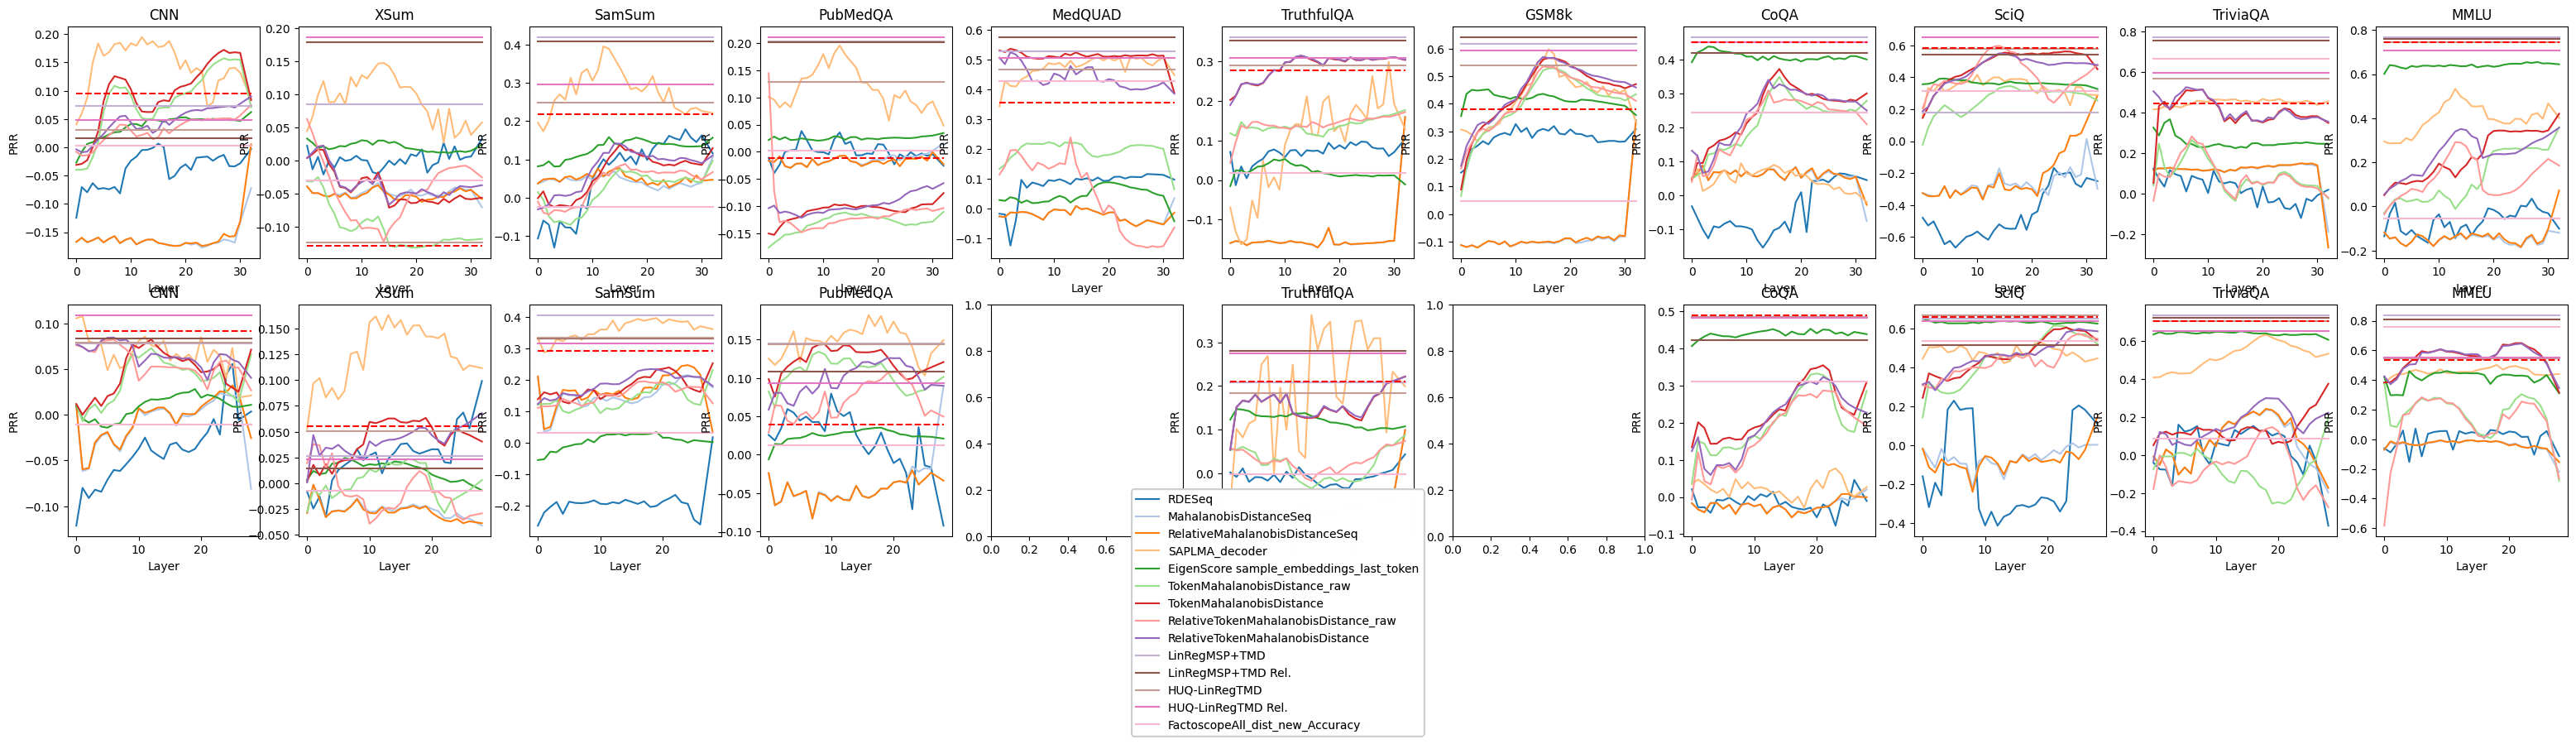

In [136]:
import matplotlib.pyplot as plt

paths = {
    "llama3.1": [
        "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/['cnn_dailymail', '3.0.0']/2024-09-23/16-37-53/ue_manager_seed1",
        "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/xsum/2024-09-24/09-59-21/ue_manager_seed1",
        "../workdir/output_layers_internal_final/ats/meta-llama/Meta-Llama-3.1-8B/samsum/2024-09-22/11-47-10/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/bigbio/pubmed_qa/2024-09-26/09-25-56/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/keivalya/MedQuad-MedicalQnADataset/2024-09-26/09-25-56/ue_manager_seed1",
        # "../workdir/output_layers_internal_final/nmt/meta-llama/Meta-Llama-3.1-8B/['wmt14', 'fr-en']/2024-09-22/16-02-15/ue_manager_seed1",
        # "../workdir/output_layers_internal_final/nmt/meta-llama/Meta-Llama-3.1-8B/['wmt19', 'de-en']/2024-09-23/13-54-29/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['truthful_qa', 'generation']/2024-09-22/09-46-08/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['gsm8k', 'main']/2024-09-21/13-13-18/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/coqa/2024-09-21/17-35-26/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/sciq/2024-09-21/13-14-10/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['cais/mmlu', 'all']/2024-09-22/05-46-18/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/meta-llama/Meta-Llama-3.1-8B/['trivia_qa', 'rc.nocontext']/2024-09-22/00-20-00/ue_manager_seed1",
    ],
    "qwen2.5": [
        "../workdir/output_layers_internal_final/ats/Qwen/Qwen2.5-7B/['cnn_dailymail', '3.0.0']/2024-09-29/17-23-22/ue_manager_seed1",
        "../workdir/output_layers_internal_final/ats/Qwen/Qwen2.5-7B/xsum/2024-09-29/17-22-43/ue_manager_seed1",
        "../workdir/output_layers_internal_final/ats/Qwen/Qwen2.5-7B/samsum/2024-09-28/01-54-42/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/bigbio/pubmed_qa/2024-09-28/01-21-29/ue_manager_seed1",
        "",
        # "",
        # "../workdir/output_layers_internal_final/nmt/Qwen/Qwen2.5-7B/['wmt19', 'de-en']/2024-09-29/10-09-33/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['truthful_qa', 'generation']/2024-09-27/20-41-49/ue_manager_seed1",
        "",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/coqa/2024-09-26/17-54-44/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/sciq/2024-09-26/09-25-56/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['trivia_qa', 'rc.nocontext']/2024-09-27/08-52-14/ue_manager_seed1",
        "../workdir/output_layers_internal_final/qa/Qwen/Qwen2.5-7B/['cais/mmlu', 'all']/2024-09-25/14-07-32/ue_manager_seed1"
    ],
}

# ds = ["CNN", "XSum", "SamSum", "PubMedQA", "MedQUAD", "WMT14", "WMT19", "TruthfulQA", "GSM8k", "CoQA", 'SciQ', "TriviaQA", "MMLU"]
ds = ["CNN", "XSum", "SamSum", "PubMedQA", "MedQUAD", "TruthfulQA", "GSM8k", "CoQA", 'SciQ', "TriviaQA", "MMLU"]

# ds = ["TriviaQA", "MMLU"]

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
        return (col.startswith(name)) and (suf in col)
    
names = ["TokenMahalanobisDistance_decoder", "RelativeTokenMahalanobisDistance_decoder"]

fig, ax = plt.subplots(nrows=len(paths.keys()), ncols=11, figsize=(39, 4*len(paths.keys())))
colors = plt.get_cmap('tab20').colors

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, Accuracy, 0.3)"):
    if "Mahalanobis" in name and "Relative" not in name:
        return (name in col) and (suf in col) and ("Relative" not in col)
    if "last_token" not in name:
        return (name in col) and (suf in col) and ("last_token" not in col)
    return (name in col) and (suf in col)

def plot_chart(ax, path, d_name, metric="Accuracy", metric_name="Accuracy", target_metric="Accuracy", update_alignscore=False):
    color = 0
    man = torch.load(path, weights_only=False)
    metric_names = [target_metric]
    df = {}
    for key in man['metrics'].keys():
        if (key[-1] == 'prr_normalized') and (key[-2] in metric_names):
            scores = df.get(key[1], [])
            scores.append(man["metrics"][key])
            df[key[1]] = scores
            
    df0 = pd.DataFrame(df, index=[f'{m}, PRR' for m in metric_names])  
    
    names = ["RDESeq", "MahalanobisDistanceSeq", "RelativeMahalanobisDistanceSeq", "SAPLMA_decoder", "EigenScore sample_embeddings_last_token", "TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]
    # names = ["TokenMahalanobisDistance", "RelativeTokenMahalanobisDistance"]

    for name in names:
        if "TokenMahalanobis" in name:
            thrs = [0.0, 0.3]
        else:
            thrs = [0.3]
        for thr in thrs:
            if "SAPLMA_decoder" in name:
                cols = [x for x in df0.columns if check_cond(x, name, f"cv, {metric_name}")]
            elif ("SAPLMA_truefalse" in name) or ("Token" not in name):
                cols = [x for x in df0.columns if check_cond(x, name, "")]
            else:
                if thr == 0:
                    cols = [x for x in df0.columns if check_cond(x, name, f"(mean, , {thr})")]
                else:
                    cols = [x for x in df0.columns if check_cond(x, name, f"(mean, {metric_name}, {thr})")]
            layers = []
            for x in cols:
                try:
                    layers.append(int(x.split("_")[-1].split(" ")[0]))
                except:
                    layers.append(len(layers)+1)
            if thr == 0:
                ax.plot(layers, df0[cols].values[0], label=name+"_raw", color=colors[color])
            else:
                ax.plot(layers, df0[cols].values[0], label=name, color=colors[color])
            color += 1
            
    for i, c in enumerate(df0.columns):
        if "LinReg" not in c:
            continue
        if ("HUQ" not in c) and ("Hybrid" not in c):
            continue
        if metric_name not in c:
            continue
    
        if "HUQ" in c:
            label = "HUQ-LinRegTMD"
        elif "Hybrid" in c:
            label = "LinRegMSP+TMD"
        else:
            label = "LinReg"
            
        if "relative" in c.lower():
            label += " Rel."
        if "remove_corr_3" not in c:
            continue   
        ax.plot(layers, [df0[c].iloc[0]]*len(layers), label=label, color=colors[color])
        color += 1
    
    for i, c in enumerate(df0.columns):
        if "Factoscope" not in c:
            continue
        label = c 
        ax.plot(layers, [df0[c].iloc[0]]*len(layers), label=label, color=colors[color])
        color += 1

    ax.set_xlabel("Layer")
    ax.set_ylabel("PRR")
    ax.set_title(d_name)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.2), loc='lower center')

    ax.plot(layers, [df0.loc[:, 'MaximumSequenceProbability'].values[0]]*len(layers), "r--", label="MSP")

for i, model in enumerate(paths.keys()):
    for k, (d_name, path) in enumerate(zip(ds, paths[model])):
        if not len(path):
            continue
            
        if d_name in ["CNN", "XSum", "MedQUAD", "SamSum", "PubMedQA", "TruthfulQA"]:
            metric = "AlignScoreMean"
            metric_name = "AlignScore"
        elif d_name in ["CoQA", "SciQ", "TriviaQA"]:
            metric = "AlignScore"
            metric_name = "Accuracy"
        elif d_name in ["WMT14", "WMT19"]:
            metric = "Comet"
            metric_name = "AlignScore"
        else:
            metric = "Accuracy"
            metric_name = "Accuracy"
        plot_chart(ax[i, k], path, d_name, metric=metric, metric_name=metric_name, target_metric=metric)

# PersonBIO

In [7]:
seed = 1

base_path = "../workdir/fc/bio/mistralai/Mistral-7B-Instruct-v0.1/['rediska0123/person-bio']/"
time = "2024-07-05/10-23-35"#"2024-07-04/17-39-32"
#"2024-07-05/12-03-36"
time = "2024-08-19/17-21-44"#"2024-08-19/14-14-44"#"2024-08-10/11-19-47"
time = "2024-08-22/10-46-21"
data = {}


for fold in range(5):
    path1 = f"{base_path}/{time}/ue_manager_seed{seed}_fold{fold}"

    data1 = torch.load(path1)
    
    for k in data1.keys():
        if isinstance(data1[k], dict):
            if k not in data.keys():
                data[k] = {}
            for k1 in data1[k].keys():
                if isinstance(data1[k][k1], list):
                    if k1 not in data[k].keys():
                        data[k][k1] = data1[k][k1]
                    else:
                        data[k][k1] += data1[k][k1]
                else:
                    if k1 not in data[k].keys():
                        data[k][k1] = data1[k][k1]
                    else:
                        data[k][k1] += data1[k][k1]
                        
        elif isinstance(data1[k], list):
            data[k] = data1[k] + data2[k]
        else:
            print(k)

/tmp/ipykernel_322004/3403711669.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data1 = torch.load(path1)


In [8]:
from lm_polygraph.ue_metrics import *

rocauc = ROCAUC()
prauc = PRAUC()

def preproc_method_name(x):
    return x

def get_table_upd(man, metric_names=['PR-AUC', "ROC-AUC"], dataset="CoQA", ue_metric="prr_normalized", 
                  update_alignscore=False, aggregated=False, return_score=False, level="claim"):
    df = {}
    methods = np.unique([x[1] for x in man['metrics'].keys() if "2side" not in x[1]])
    metric = np.array(man['gen_metrics'][('claim', 'OpenAIFactCheck')])  
    for method in methods:
        key = (level, method, "", ue_metric)
        level = "claim"
        estimator_values = np.array(man['estimations'][(level, key[1])]).flatten()         
        rec_metrics_val = np.array(metric)

        ue = np.array(estimator_values)
        ue = np.nan_to_num(ue, 0)
        final_score = prauc(ue, rec_metrics_val) 
        scores = df.get(method, [])
        scores.append(final_score)
        df[method] = scores

    for method in methods:
        key = (level, method, "", ue_metric)
        level = "claim"
        estimator_values = np.array(man['estimations'][(level, key[1])]).flatten()         
        rec_metrics_val = np.array(metric)

        ue = np.array(estimator_values)
        ue = np.nan_to_num(ue, 0)
        final_score = rocauc(ue, rec_metrics_val) 
        scores = df.get(method, [])
        scores.append(final_score)
        df[method] = scores

    df0 = pd.DataFrame(df, index=pd.MultiIndex.from_tuples([(dataset, m) for m in metric_names])).T
    aggregation = ["mean" if "mean" in x else "sum(log(p_i))" if "sum(log(p_i))" in x else "-" for x in df0.index]
    method = [preproc_method_name(x) for x in df0.index]
    df0.loc[:, (dataset, 'Aggregation')] = aggregation
    df0.loc[:, (dataset, 'Method')] = method
    return df0.reset_index(drop=True)

In [9]:
get_table_upd(data).style.background_gradient(axis=0)

In [10]:
from lm_polygraph.ue_metrics import *

rocauc = ROCAUC()
prauc = PRAUC()

def preproc_method_name(x):
    return x

def get_table_upd(man, metric_names=['PR-AUC', "ROC-AUC"], dataset="CoQA", ue_metric="prr_normalized", 
                  update_alignscore=False, aggregated=False, return_score=False, level="claim"):
    df = {}
    methods = np.unique([x[1] for x in man['estimations'].keys()])
    metric = np.array(man['gen_metrics'][('claim', 'OpenAIFactCheck')])  
    for method in methods:
        key = (level, method, "", ue_metric)
        level = "claim"
        if "relative" in method.lower() and "decoder_" in method.lower():
            level = "sequence"
            estimator_values = np.concatenate(man['estimations'][(level, key[1])])
        else:
            estimator_values = np.array(man['estimations'][(level, key[1])])
        
        rec_metrics_val = np.array(metric)

        ue = np.array(estimator_values)
        final_score = prauc(ue, rec_metrics_val) 
        scores = df.get(method, [])
        scores.append(final_score)
        df[method] = scores

    for method in methods:
        key = (level, method, "", ue_metric)
        level = "claim"
        if "relative" in method.lower() and "decoder_" in method.lower():
            level = "sequence"
            estimator_values = np.concatenate(man['estimations'][(level, key[1])])
        else:
            estimator_values = np.array(man['estimations'][(level, key[1])])       
        rec_metrics_val = np.array(metric)

        ue = np.array(estimator_values)
        final_score = rocauc(ue, rec_metrics_val) 
        scores = df.get(method, [])
        scores.append(final_score)
        df[method] = scores

    df0 = pd.DataFrame(df, index=pd.MultiIndex.from_tuples([(dataset, m) for m in metric_names])).T
    aggregation = ["mean" if "mean" in x else "sum(log(p_i))" if "sum(log(p_i))" in x else "-" for x in df0.index]
    method = [preproc_method_name(x) for x in df0.index]
    df0.loc[:, (dataset, 'Aggregation')] = aggregation
    df0.loc[:, (dataset, 'Method')] = method
    return df0.reset_index(drop=True)

In [11]:
df0 = get_table_upd(data)
df0.style.background_gradient(axis=0)

KeyError: ('sequence', 'RelativeTokenMahalanobisDistanceClaim_decoder_0 (mean, 0.0)')

/tmp/ipykernel_722/3183765198.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0.iloc[0][1]]*len(layers), label="MSP")


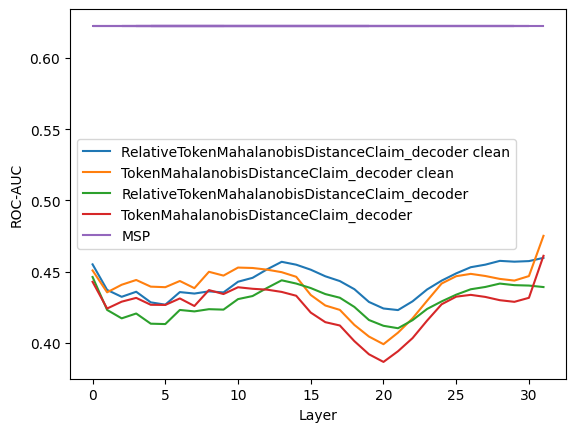

In [805]:
import matplotlib.pyplot as plt

def check_cond(col, name="TokenMahalanobisDistance_decoder", suf="(mean, 0.5)"):
    return (col.startswith(name)) and (suf in col)
    
names = ["RelativeTokenMahalanobisDistanceClaim_decoder", "TokenMahalanobisDistanceClaim_decoder"]
suf = "(mean, 0.5)"
for name in names:
    rows = [i for i, x in enumerate(df0[('CoQA', 'Method')].values) if check_cond(x, name, suf)]
    layers = np.array([int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in df0[('CoQA', 'Method')].values[rows]])
    order = np.argsort(layers)
    y = df0[('CoQA', 'ROC-AUC')].values[rows]
    plt.plot(layers[order], y[order], label=name + " clean")

suf = "(mean, 0.0)"
for name in names:
    rows = [i for i, x in enumerate(df0[('CoQA', 'Method')].values) if check_cond(x, name, suf)]
    layers = np.array([int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in df0[('CoQA', 'Method')].values[rows]])
    order = np.argsort(layers)
    y = df0[('CoQA', 'ROC-AUC')].values[rows]
    plt.plot(layers[order], y[order], label=name)


plt.plot(layers, [df0.iloc[0][1]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("ROC-AUC")
plt.legend()

/tmp/ipykernel_722/280482669.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(layers, [df0.iloc[0][0]]*len(layers), label="MSP")


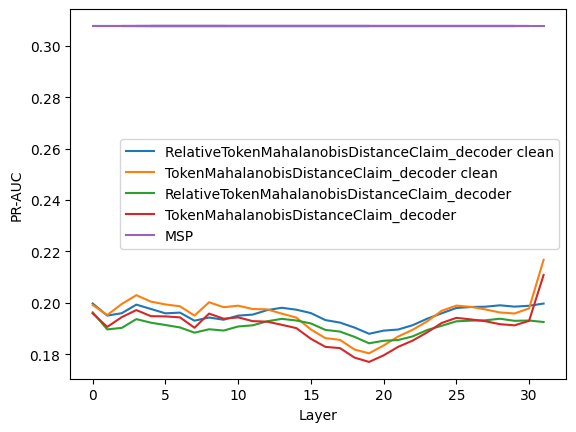

In [806]:
suf = "(mean, 0.5)"
for name in names:
    rows = [i for i, x in enumerate(df0[('CoQA', 'Method')].values) if check_cond(x, name, suf)]
    layers = np.array([int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in df0[('CoQA', 'Method')].values[rows]])
    order = np.argsort(layers)
    y = df0[('CoQA', 'PR-AUC')].values[rows]
    plt.plot(layers[order], y[order], label=name + " clean")

suf = "(mean, 0.0)"
for name in names:
    rows = [i for i, x in enumerate(df0[('CoQA', 'Method')].values) if check_cond(x, name, suf)]
    layers = np.array([int(x.split("_")[2].split(" ")[0]) if len(x.split("_")) > 2 else 31 for x in df0[('CoQA', 'Method')].values[rows]])
    order = np.argsort(layers)
    y = df0[('CoQA', 'PR-AUC')].values[rows]
    plt.plot(layers[order], y[order], label=name)

plt.plot(layers, [df0.iloc[0][0]]*len(layers), label="MSP")
plt.xlabel("Layer")
plt.ylabel("PR-AUC")
plt.legend()

In [742]:
len(data["stats"]["greedy_texts"])

80

In [705]:
from sacrebleu.metrics import BLEU, CHRF, TER

refs = [["This is a cat"]]#, ['The dog had bit the man.', 'No one was surprised.', 'The man had bitten the dog.']]
sys = ['This is cat']

bleu = BLEU(effective_order=True)

bleu.sentence_score(sys[0], [refs[0][0]])

BLEU = 45.14 100.0/50.0/50.0/0.0 (BP = 0.717 ratio = 0.750 hyp_len = 3 ref_len = 4)

In [178]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

for t, g in zip(refs[0], sys):
    print(g, t)
    print(sentence_bleu([t.split()], g.split()))

This is cat This is a cat
8.987727354491445e-155


In [220]:
smth = SmoothingFunction(k=1)
for t, g in zip(refs[0], sys):
    print(g, t)
    print(sentence_bleu([t.split()], g.split(), smoothing_function=smth.method3, auto_reweigh=True))

This is cat This is a cat
0.451386440550339


In [186]:
SmoothingFunction()

In [273]:
import nltk
hypothesis = ['This', 'is', 'cat'] 
reference = ['This', 'is', 'a', 'cat']
references = [reference] # list of references for 1 sentence.
list_of_references = [references] # list of references for all sentences in corpus.
list_of_hypotheses = [hypothesis] # list of hypotheses that corresponds to list of references.
nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses), nltk.translate.bleu_score.sentence_bleu(references, hypothesis)

(8.987727354491445e-155, 8.987727354491445e-155)

In [274]:
references, [t.split()]

([['This', 'is', 'a', 'cat']], [['This', 'is', 'a', 'cat']])

In [275]:
hypothesis, g.split()

(['This', 'is', 'cat'], ['This', 'is', 'cat'])

In [285]:
target = "yes"
gen = ' .Yes.\n'.lower().strip().rstrip('.')
bleu.sentence_score(gen, [target]).score

49.99999999999999

In [286]:
gen

'.yes'

In [ ]:
import numpy as np
from sacrebleu.metrics import BLEU

from typing import List, Dict
from .generation_metric import GenerationMetric


class RougeMetric(GenerationMetric):
    """
    Calculates BLEU metric between model-generated texts and ground truth texts.
    """

    def __init__(self):
        super().__init__(["greedy_texts"], "sequence")
        self.scorer = BLEU(effective_order=True)

    def __str__(self):
        return f"BLEU"

    def _score_single(self, t1: str, t2: str):
        return self.scorer.sentence_score(t1, [t2]).score

    def __call__(
        self,
        stats: Dict[str, np.ndarray],
        target_texts: List[str],
        target_tokens: List[List[int]],
    ) -> np.ndarray:
        """
        Calculates BLEU score between stats['greedy_texts'] and target_texts.

        Parameters:
            stats (Dict[str, np.ndarray]): input statistics, which for multiple samples includes:
                * model-generated texts in 'greedy_texts'
            target_texts (List[str]): ground-truth texts
            target_tokens (List[List[int]]): corresponding token splits for each target text
        Returns:
            np.ndarray: list of BLEU Scores for each sample in input.
        """
        return np.array(
            [
                self._score_single(hyp, ref)
                for hyp, ref in zip(stats["greedy_texts"], target_texts)
            ]
        )